In [1]:
import os,sys
import numpy as np
import pandas as pd
import collections
import pickle as pk
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
import seaborn as sns
from adjustText import adjust_text
from scipy.stats import pearsonr, spearmanr, chisquare, ttest_ind, ranksums, wilcoxon, fisher_exact, mannwhitneyu
from scipy import stats
import pybedtools
import cooler
import cooltools.lib.plotting
import cooltools
from scipy.stats import gaussian_kde
import statsmodels.api as sm

from coolpuppy import coolpup
from coolpuppy.lib import numutils
from coolpuppy.lib.puputils import divide_pups
from coolpuppy import plotpup
import cooler
import bioframe
from cooltools import expected_cis, expected_trans

from skmisc.loess import loess

import pybedtools
import pyBigWig

plt.rcParams.update(plt.rcParamsDefault)
rc={"axes.labelsize": 16, "xtick.labelsize": 12, "ytick.labelsize": 12,
    "figure.titleweight":"bold", #"font.size":14,
    "figure.figsize":(5.5,4.2), "font.weight":"regular", "legend.fontsize":10,
    'axes.labelpad':8, 'figure.dpi':300}
plt.rcParams.update(**rc)



In [2]:
mm10_tss_ann = pd.read_csv('/lab-share/Cardio-Chen-e2/Public/rongbinzheng/Genome/mm10/gencode.vM23.annotation.protein_coding.tss.csv',
                          sep = '\t', header = None)

mm10_tss_ann.columns = ['chr', 'start', 'end', 'name', 'label', 'strand']


In [3]:

fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)
from matplotlib.ticker import EngFormatter
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.patches as patches

def rectangles_around_dots(dots_df, region, loc="upper", lw=1, ec="cyan", fc="none"):
    """
    yield a series of rectangles around called dots in a given region
    """
    # select dots from the region:
    df_reg = bioframe.select(
        bioframe.select(dots_df, region, cols=("chrom1","start1","end1")),
        region,
        cols=("chrom2","start2","end2"),
    )
    rectangle_kwargs = dict(lw=lw, ec=ec, fc=fc)
    # draw rectangular "boxes" around pixels called as dots in the "region":
    for s1, s2, e1, e2 in df_reg[["start1", "start2", "end1", "end2"]].itertuples(index=False):
        width1 = e1 - s1
        width2 = e2 - s2
        if loc == "upper":
            yield patches.Rectangle((s2, s1), width2, width1, **rectangle_kwargs)
        elif loc == "lower":
            yield patches.Rectangle((s1, s2), width1, width2, **rectangle_kwargs)
        else:
            raise ValueError("loc has to be uppper or lower")
bp_formatter = EngFormatter('b')
def format_ticks(ax, x=True, y=True, rotate=True):
    """format ticks with genomic coordinates as human readable"""
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def _cont_map_(clr, ch, cond, title='', 
             clr2=None, cond2=None, w = None,
             comp_df=None, comp_df2=None,
             decimal = 0, dots_df = False,
             cmap = 'fall', vmax = 0.01, vmin = 1e-5, figsize = (10, 5),
             dot_loc = 'upper', dot_ec = 'cyan', pdf = False):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize)
    norm = LogNorm(vmax=vmax, vmin=vmin)
    if clr2 is None:
        mat = clr.matrix(balance=True).fetch(ch)
        ylabel = ''
        xlabel = ''
    else:
        mat1 = clr.matrix(balance=True).fetch(ch)
        mat2 = clr2.matrix(balance=True).fetch(ch)
        ## cond1 in lower tri, cond2 in upper tri
        w = 3 if w is None else w
        mat = np.tril(mat1, -w)+np.triu(mat2, w)
        ylabel = '%s'%cond
        xlabel = '%s'%cond2
    
    bins = clr.bins().fetch(ch)
    if ':' in ch:
        c = ch.split(':')[0]
        st, end = ch.split(':')[1].split('-')
        st, end = int(st), int(end)
    else:
        c, st, end = bins.iloc[0,0], bins.iloc[0,1], bins.iloc[-1,2]        

    im = ax.matshow(
        mat,
        norm=norm,
        cmap=cmap,
        extent=(st, end, end, st)
    )
    format_ticks(ax)
    ax.xaxis.tick_top()
    ax.tick_params(axis = 'x', rotation = 45)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, label='Corrected frequencies', cax = cax, shrink = 0.3);
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.xaxis.set_label_position('top')  
    # format_ticks(ax)
#     plt.tight_layout()
    if type(dots_df) == type(pd.DataFrame()):
        for box in rectangles_around_dots(dots_df, (c, int(st), int(end)), lw=1.5,
                                         loc = dot_loc, ec = dot_ec):
            ax.add_patch(box)
    for x in ['top', 'right', 'bottom', 'left']:
        ax.spines[x].set_visible(False)

    ## add compartment
    if comp_df is not None:
        ax1 = divider.append_axes("bottom", size="20%", pad=0.1, sharex=ax)
        # weights = clr.bins()[:]['weight'].values
        comp1 = comp_df[(comp_df['chrom']==c) & (comp_df['start']>=int(st)) & (comp_df['end']<=int(end))].fillna(0)
        ax1.plot([st, end],[0,0],'k',lw=0.25)
#         ax1.plot(comp1['start'], comp1['E1'].fillna(0))
        ax1.fill_between(
                comp1['start'].tolist(), 0, comp1['E1'].tolist(), 
                where=(comp1['E1']>0),
                edgecolor = 'none',
                facecolor = plt.cm.get_cmap('tab10')(1),
                label = 'A',
                alpha=0.8, 
            )
        ax1.fill_between(
                comp1['start'].tolist(), 0, comp1['E1'].tolist(), 
                where=(comp1['E1']<0),
                facecolor = plt.cm.get_cmap('tab10')(0),
                label = 'B',
                alpha=0.8, 
            )
#         ax1.plot(comp1.query('E1 <= 0')['start'], comp1.query('E1 <= 0')['E1'],
#                 label='B', color = plt.cm.get_cmap('tab10')(0))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), 
                   title='%s'%cond2, frameon = False)
#         ax1.set_xlabel(cond1)
        ax1.xaxis.set_visible(False)
        ax1.yaxis.set_visible(False)
        for x in ['top', 'right', 'bottom', 'left']:
            ax1.spines[x].set_visible(False)

    if comp_df2 is not None:
        ax2 = divider.append_axes("top", size="20%", pad=1, sharex=ax)
        # weights = clr.bins()[:]['weight'].values
        comp2 = comp_df2[(comp_df2['chrom']==c) & 
                         (comp_df2['start']>=int(st)) & 
                         (comp_df2['end']<=int(end))].fillna(0)
        ax2.plot([st, end],[0,0],'k',lw=0.25)
#         ax1.plot(comp1['start'], comp1['E1'].fillna(0))
        ax2.fill_between(
                comp2['start'].tolist(), 0, comp2['E1'].tolist(), 
                where=(comp2['E1']>0),
                edgecolor = 'none',
                facecolor = plt.cm.get_cmap('tab10')(1),
                label = 'A',
                alpha=0.8, 
            )
        ax2.fill_between(
                comp2['start'].tolist(), 0, comp2['E1'].tolist(), 
                where=(comp2['E1']<0),
                facecolor = plt.cm.get_cmap('tab10')(0),
                label = 'B',
                alpha=0.8, 
            )
#         ax1.plot(comp1.query('E1 <= 0')['start'], comp1.query('E1 <= 0')['E1'],
#                 label='B', color = plt.cm.get_cmap('tab10')(0))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                   title='%s'%cond2, frameon = False)
        ax2.set_xlabel(cond1)
        ax2.xaxis.set_visible(False)
        ax2.yaxis.set_visible(False)
        for x in ['top', 'right', 'bottom', 'left']:
            ax2.spines[x].set_visible(False)
    plt.suptitle(title, fontweight = 'bold') if title else None
    plt.tight_layout()
    pdf.savefig(fig) if pdf else plt.show()
    plt.close()
    
def quantile_norm(X):
    """
    Normalize the columns of X to each have the same distribution.
  
    Given an expression matrix (microarray data, read counts, etc) of M genes
    by N samples, quantile normalization ensures all samples have the same
    spread of data.
  
    The data across each row are averaged to obtain an average column. Each
    column quantile is replaced with the corresponding quantile of the average
    column.
  
    Parameters
    ----------
    X : 2D array of float, shape (M, N)
        The input data, with M rows (genes/features) and N columns (samples).
  
    Returns
    -------
    Xn : 2D array of float, shape (M, N)
        The normalized data.
    """
    # compute the quantiles
    quantiles = np.mean(np.sort(X, axis=0), axis=1)
    # compute the column-wise ranks. Each observation is replaced with its
    # rank in that column: the smallest observation is replaced by 1, the
    # second-smallest by 2, ..., and the largest by M, the number of rows.
    ranks = np.apply_along_axis(stats.rankdata, 0, X)

    # convert ranks to integer indices from 0 to M-1
    rank_indices = ranks.astype(int) - 1

    # index the quantiles for each rank with the ranks matrix
    Xn = quantiles[rank_indices]

    return Xn

### function to draw boxplot for gene expression change of up, down, stable loops
def _plot_loop_exp_(mm10_tss_ann, up_loops, down_loops, stable_loops, de, d = 10000, figsize = (5,5), pdf = False):
    mm10_promoter = mm10_tss_ann.copy()
    mm10_promoter['start'] = mm10_tss_ann['start'] - d
    mm10_promoter['end'] = mm10_tss_ann['end'] + d
    mm10_promoter = mm10_promoter[mm10_promoter['start']>0]

    up_loops = up_loops.sort_values(['chr', 'start', 'end'])
    py_up_loops = pybedtools.BedTool.from_dataframe(up_loops)
    
    down_loops = down_loops.sort_values(['chr', 'start', 'end'])
    py_down_loops = pybedtools.BedTool.from_dataframe(down_loops)
    
    stable_loops = stable_loops.sort_values(['chr', 'start', 'end'])
    py_stable_loops = pybedtools.BedTool.from_dataframe(stable_loops)

    up_prom_gene = pybedtools.BedTool.from_dataframe(mm10_promoter).intersect(py_up_loops, wa=True).to_dataframe()
    down_prom_gene = pybedtools.BedTool.from_dataframe(mm10_promoter).intersect(py_down_loops, wa=True).to_dataframe()
    stable_prom_gene = pybedtools.BedTool.from_dataframe(mm10_promoter).intersect(py_stable_loops, wa=True).to_dataframe()

    up_prom_gene = np.unique([x.split(':')[-1] for x in up_prom_gene['name'].tolist()])
    down_prom_gene = np.unique([x.split(':')[-1] for x in down_prom_gene['name'].tolist()])
    stable_prom_gene = np.unique([x.split(':')[-1] for x in stable_prom_gene['name'].tolist()])

    plot_df1 = de.loc[de.index.isin(up_prom_gene),]
    plot_df1.loc[:,'label'] = 'Up'
    plot_df2 = de.loc[de.index.isin(down_prom_gene),]
    plot_df2.loc[:,'label'] = 'Down'
    plot_df3 = de.loc[de.index.isin(stable_prom_gene),]
    plot_df3.loc[:,'label'] = 'Stable'
    plot_df = pd.concat([plot_df1, plot_df2, plot_df3])
    
    fig, ax = plt.subplots(figsize = figsize)
    col = 'log2FoldChange'
    sns.boxplot(data = plot_df, x = 'label', y = col, showfliers = False,
               width = .5)
    s1, p1 = ranksums(plot_df.query('label == "Up"')[col], 
                      plot_df.query('label == "Stable"')[col])
    s2, p2 = ranksums(plot_df.query('label == "Down"')[col], 
                      plot_df.query('label == "Stable"')[col])
    s3, p3 = ranksums(plot_df.query('label == "Up"')[col], 
                      plot_df.query('label == "Down"')[col])
    ax.hlines(0, *ax.get_xlim(), color = 'black', linestyle = 'dashed')
    ax.set(xlabel = 'Looping changes', ylabel = 'mRNA log2FoldChange')
    ax.set_title('Up vs Stable: s=%.2f, p=%.2e\nDown vs Stable: s=%.2f, p=%.2e\nUp vs Down: s=%.2f, p=%.2e'%(s1, p1, s2, p2, s3, p3))
    plt.tight_layout()
    plt.show() if not pdf else pdf.savefig(fig)
    plt.close()
    return(plot_df)


### function to get values for loop change and expression change, lowess smoothing applied
def _get_values_(df, comp = 'shNT_plusCL_vs_minusCL', value = 'log2FoldChange'):
    dx, dy = [], []
    ddf = []
    for i, line in df.iterrows():
        g = line[['r1_gene', 'r2_gene']].dropna().values.tolist()
        for j in g:
            j = j.split(';')
            for jj in j:
                ytmp = diffexp[comp].loc[jj, value] if jj in diffexp[comp].index.tolist() else np.nan
                dy.append(ytmp)
                dx.append(line['score_delta'])
                ddf.append(line.tolist()+[ytmp, jj])

    ddf = pd.DataFrame(ddf, columns = df.columns.tolist()+[value, 'gene'])
#     return(ddf)
    ddf = ddf[~pd.isna(ddf[value]) & ~pd.isna(ddf['score_delta'])]
    ddf = ddf.sort_values('score_delta')
    x, y = ddf['score_delta'], ddf[value]
    l = loess(x,y)
    l.fit()
    pred = l.predict(x, stderror=True)
    conf = pred.confidence()
    lowess = pred.values
    ll = conf.lower
    ul = conf.upper
    ddf['lowess'] = lowess
    ddf['lower_lowess'] = ll
    ddf['upper_lowess'] = ul
    return(ddf)



## define EP, PP, P-other
def _define_EP_PP_(loops, comp = 'shNT_plusCL_vs_minusCL'):
    ## EP
    q1 = '(r1_promoter == True and r2_ELS == True and r2_K27ac == True) or (r2_promoter == True and r1_ELS == True and r1_K27ac == True)'
    ## PP
    q2 = '(r1_promoter == True and r2_promoter == True)'
    ## P-other
    q3 = '(r1_promoter == True and (r2_ELS != True or r2_K27ac != True) and r2_promoter != True) or (r2_promoter == True and (r1_ELS != True or r1_K27ac != True) and r1_promoter != True)'

    ## overlap with promoter
    loops['r1'] = loops['chrom1']+':'+loops['start1'].astype('str')+'-'+loops['end1'].astype('str')
    loops['r2'] = loops['chrom2']+':'+loops['start2'].astype('str')+'-'+loops['end2'].astype('str')

    r1 = pybedtools.BedTool.from_dataframe(loops[['chrom1','start1','end1', 'r1']])
    r2 = pybedtools.BedTool.from_dataframe(loops[['chrom2','start2','end2', 'r2']])
    r1_promoter = r1.intersect(mm10_promoter_bed, wao = True).to_dataframe().drop_duplicates()
    r2_promoter = r2.intersect(mm10_promoter_bed, wao = True).to_dataframe().drop_duplicates()

    ## overlap with ELS
    r1_ELS = r1.intersect(mm10_ELS_bed, wao = True).to_dataframe().drop_duplicates()
    r2_ELS = r2.intersect(mm10_ELS_bed, wao = True).to_dataframe().drop_duplicates()

    ## overlap with K27ac
    r1_K27ac = r1.intersect(k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()
    r2_K27ac = r2.intersect(k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()

    ## overlap with ELS_K27ac
    r1_ELS_K27ac = r1.intersect(ELS_k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()
    r2_ELS_K27ac = r2.intersect(ELS_k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()

    loops['r1_promoter'] = loops['r1'].isin(r1_promoter.query('score != "."')['name'])
    loops['r2_promoter'] = loops['r2'].isin(r2_promoter.query('score != "."')['name'])
    loops['r1_ELS'] = loops['r1'].isin(r1_ELS.query('score != "."')['name'])
    loops['r2_ELS'] = loops['r2'].isin(r2_ELS.query('score != "."')['name'])
    loops['r1_K27ac'] = loops['r1'].isin(r1_K27ac.query('score != "."')['name'])
    loops['r2_K27ac'] = loops['r2'].isin(r2_K27ac.query('score != "."')['name'])
    loops['r1_ELS_K27ac'] = loops['r1'].isin(r2_ELS_K27ac.query('score != "."')['name'])
    loops['r2_ELS_K27ac'] = loops['r2'].isin(r2_ELS_K27ac.query('score != "."')['name'])
    
    r1_genes = r1_promoter.query('score != "."').groupby('name').apply(lambda df: ';'.join(set([x.split(':')[-1] for x in df['thickEnd'].unique().tolist()]))).to_dict()
    r2_genes = r2_promoter.query('score != "."').groupby('name').apply(lambda df: ';'.join(set([x.split(':')[-1] for x in df['thickEnd'].unique().tolist()]))).to_dict()


    loops['r1_gene'] = [r1_genes.get(x, np.nan) for x in loops['r1'].tolist()]
    loops['r2_gene'] = [r2_genes.get(x, np.nan) for x in loops['r2'].tolist()]

    loops['r1_mRNA_fc'] = [diffexp[comp].reindex(x.split(';'))['log2FoldChange'].mean() if not pd.isna(x) else np.nan for x in loops['r1_gene'].tolist()]
    loops['r2_mRNA_fc'] = [diffexp[comp].reindex(x.split(';'))['log2FoldChange'].mean() if not pd.isna(x) else np.nan for x in loops['r2_gene'].tolist()]

    ## define EP, PP, and PO
    EP_df = loops.query(q1)
    PP_df = loops.query(q2)
    PO_df = loops.query(q3)
    other_df = loops[~loops['label'].isin(EP_df['label'].tolist()+PP_df['label'].tolist()+PO_df['label'].tolist())]
    
    return(EP_df, PP_df, PO_df, other_df)

### identify H2AZ occupied loops
def _plot_H2AZ_overlap_v2_(loops, peaks, title = '', focus = [], flip = False):
    anchor1 = pybedtools.BedTool.from_dataframe(loops[['chrom1','start1','end1']])
    anchor2 = pybedtools.BedTool.from_dataframe(loops[['chrom2','start2','end2']])
    union_loop_an = pd.DataFrame(loops[['chrom1','start1','end1']].values.tolist()+loops[['chrom2','start2','end2']].values.tolist()).drop_duplicates()
    union_loop_an.columns = ['chrom', 'start', 'end']
    union_anchor = pybedtools.BedTool.from_dataframe(union_loop_an)
    H2AZ_overlap = {}
    if not focus:
        peaks_keys = list(peaks.keys())
    else:
        peaks_keys = focus
    for x in peaks_keys:
        tmp1 = anchor1.intersect(peaks[x], wa=True).to_dataframe().drop_duplicates()
        tmp2 = anchor2.intersect(peaks[x], wa=True).to_dataframe().drop_duplicates()
        tmp1['label'] = tmp1['chrom']+':'+tmp1['start'].astype('str')+'-'+tmp1['end'].astype('str')
        tmp2['label'] = tmp2['chrom']+':'+tmp2['start'].astype('str')+'-'+tmp2['end'].astype('str')
        loops_tmp = loops.copy()
        loops_tmp['anchor1'] = loops_tmp['chrom1']+':'+loops_tmp['start1'].astype('str')+'-'+loops_tmp['end1'].astype('str')
        loops_tmp['anchor2'] = loops_tmp['chrom2']+':'+loops_tmp['start2'].astype('str')+'-'+loops_tmp['end2'].astype('str')
        loops_tmp['anchor1_H2AZ'] = loops_tmp['anchor1'].isin(tmp1['label'])
        loops_tmp['anchor2_H2AZ'] = loops_tmp['anchor2'].isin(tmp2['label'])
        tmp_or = loops_tmp[((loops_tmp['anchor1_H2AZ']==True) | (loops_tmp['anchor2_H2AZ']==True)) & ~((loops_tmp['anchor1_H2AZ']==True) & (loops_tmp['anchor2_H2AZ']==True))]
        tmp_and = loops_tmp[(loops_tmp['anchor1_H2AZ']==True) & (loops_tmp['anchor2_H2AZ']==True)]
        H2AZ_overlap[x]={'anchor1': tmp1.shape[0], 'anchor2': tmp2.shape[0],
                                           'both_anchor':tmp_and.shape[0],'either_anchor':tmp_or.shape[0],
                                           'total_loop':loops.shape[0],
                                           'total_H2AZ':peaks[x].to_dataframe().shape[0],
                        'loops':{'both':tmp_and, 'either':tmp_or}}

    df1 = pd.DataFrame(H2AZ_overlap)
    df1 = df1.loc[['anchor1', 'anchor2', 'both_anchor', 'either_anchor']]*100/df1.loc['total_loop']
    df1 = df1.reset_index().melt(id_vars = ['index'])
    
    if flip:
        fig, ax = plt.subplots(figsize = (4, 5))
        sns.barplot(data = df1, x = 'variable', y = 'value', hue = 'index', palette = 'Paired')
        ax.set_ylim(0, 100)
        ax.tick_params(axis = 'x', rotation = 90)
    else:
        fig, ax = plt.subplots()
        sns.barplot(data = df1, y = 'variable', x = 'value', hue = 'index', palette = 'Paired')
        ax.set_xlim(0, 100)
    # ax.tick_params(axis = 'x', rotation = 90)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(label = title, pad = 20)
#     ax.set_xlim(0, 45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon = False)
    sns.despine()
    plt.show()
    return(H2AZ_overlap)


### venn diagram for peaks / bed files
def venn_mpl(a, b, colors=None, 
             outfn="out.pdf", labels=None,text=None,
             dpi=300, figsize = (5, 4)):
    """
    *a*, *b*, and *c* are filenames to BED-like files.
    *colors* is a list of matplotlib colors for the Venn diagram circles.
    *outfn* is the resulting output file.  This is passed directly to
    fig.savefig(), so you can supply extensions of .png, .pdf, or whatever your
    matplotlib installation supports.
    *labels* is a list of labels to use for each of the files; by default the
    labels are ['a','b','c']
    
    *dpi* is the dpi setting passed to matplotlib savefig
    """
    try:
        import matplotlib.pyplot as plt
        from matplotlib.patches import Circle
    except ImportError:
        sys.stderr.write(
            "matplotlib is required to make a Venn diagram with %s\n"
            % os.path.basename(sys.argv[0])
        )
        sys.exit(1)

    a = pybedtools.BedTool(a)
    b = pybedtools.BedTool(b)

    if colors is None:
        colors = ["r", "b"] #if c is not None else ["r", "b"]

    radius = 1.0
    center = 0.0
    offset = radius / 2
    s = sum([a.count(), b.count()]) #if c is None else sum([a.count(), b.count(), c.count()])
    
    if labels is None:
        labels = ["a", "b"] #if c is not None else ["a", "b"]
    aradius = radius
    bradius = aradius * b.count() / a.count()
    ab = (a + b).count()
    
    Oa = ab * aradius / a.count()
    Ob = ab * bradius / b.count()
    
    aoffset = aradius - Oa
    boffset = bradius - Ob 
    
    circle_a = Circle(
        xy=(center - aoffset, center),
        radius=aradius,
        edgecolor=colors[0],
        label=labels[0],
    )
    
    circle_b = Circle(
        xy=(center + boffset, center),
        radius=bradius,
        edgecolor=colors[1],
        label=labels[1],
    )
    
    fig = plt.figure(facecolor="w", figsize = figsize)
    ax = fig.add_subplot(111)

    for circle in (circle_a, circle_b):
        circle.set_facecolor("none")
        circle.set_linewidth(3)
        ax.add_patch(circle)


    ax.axis("tight")
    ax.axis("equal")
    ax.set_axis_off()

    kwargs = dict(horizontalalignment="center")

    
    atextset = aradius - 0.5*Oa
    btextset = bradius - 0.5*Ob 
    if text is True:
        # Unique to A
        t1 = ax.text(center - atextset, center, str((a - b).count()), **kwargs)

        # Unique to B
        t2 = ax.text(center + btextset, center, str((b - a).count()), **kwargs)

        t3 = ax.text(
                center, center, str((a + b).count()), **kwargs
            )
        adjust_text([t1, t2, t3], arrowprops=dict(arrowstyle="-", lw=0.5), save_steps = False, **kwargs)
    else:
        print([str((a - b).count()), str((a + b).count()), str((b - a).count())])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 8)
    plt.tight_layout()
    fig.savefig(outfn, dpi=dpi) if outfn else None
    plt.show()
    plt.close(fig)


### looping analysis by Peakahu


In [ ]:
## load loop probability for each dot in pooled data

shNT_plusCL_all = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_mapq5_merge.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_plusCL_all[key] = scores

shNT_minusCL_all = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_minusCL_mapq5_merge.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_minusCL_all[key] = scores
        
KD_plusCL_all = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/KD_plusCL_mapq5_merge.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        KD_plusCL_all[key] = scores
#### load loop probability for each dot in each replicate
shNT_plusCL_rep1 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_plusCL_rep1.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_plusCL_rep1[key] = scores

shNT_plusCL_rep2 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_plusCL_rep2.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_plusCL_rep2[key] = scores
shNT_plusCL_rep3 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_plusCL_rep3.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_plusCL_rep3[key] = scores
shNT_plusCL_rep4 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_plusCL_rep4.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_plusCL_rep4[key] = scores

shNT_minusCL_rep1 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_minusCL_rep1.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_minusCL_rep1[key] = scores

shNT_minusCL_rep2 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_minusCL_rep2.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_minusCL_rep2[key] = scores
shNT_minusCL_rep3 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_minusCL_rep3.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_minusCL_rep3[key] = scores
shNT_minusCL_rep4 = collections.defaultdict()
with open('./merge_pairs_mapq5/remove100bp/replicate/loops/shNT_minusCL_rep4.pairs.mapq5.pairs_5000.bedpe') as source:
    for line in source:
        p = line.rstrip().split('\t')
        key = (p[0], int(p[1]), int(p[2]), p[3], int(p[4]), int(p[5]))
        scores = list(map(float, p[-2:])) 
        shNT_minusCL_rep4[key] = scores

### identify confident dots by restricting loop probability > 0.95
prob_cut = 0.95
shNT_plusCL_good = [x for x in shNT_plusCL_all if shNT_plusCL_all[x][0] > prob_cut]
shNT_minusCL_good = [x for x in shNT_minusCL_all if shNT_minusCL_all[x][0] > prob_cut]

shNT_union_good = collections.defaultdict()
for x in shNT_plusCL_good + shNT_minusCL_good:
    if x in shNT_union_good:
        continue
    v1 = shNT_plusCL_all[x] if x in shNT_plusCL_all else [0, 0]
    v2 = shNT_minusCL_all[x] if x in shNT_minusCL_all else [0, 0]
    v3 = KD_plusCL_all[x] if x in KD_plusCL_all else [0, 0]
    v11 = shNT_plusCL_rep1[x] if x in shNT_plusCL_rep1 else [0, 0]
    v12 = shNT_plusCL_rep2[x] if x in shNT_plusCL_rep2 else [0, 0]
    v13 = shNT_plusCL_rep3[x] if x in shNT_plusCL_rep3 else [0, 0]
    v14 = shNT_plusCL_rep4[x] if x in shNT_plusCL_rep4 else [0, 0]
    v21 = shNT_minusCL_rep1[x] if x in shNT_minusCL_rep1 else [0, 0]
    v22 = shNT_minusCL_rep2[x] if x in shNT_minusCL_rep2 else [0, 0]
    v23 = shNT_minusCL_rep3[x] if x in shNT_minusCL_rep3 else [0, 0]
    v24 = shNT_minusCL_rep4[x] if x in shNT_minusCL_rep4 else [0, 0]
    shNT_union_good[x] = v1+v2+v3+v11+v12+v13+v14+v21+v22+v23+v24

## generate a dataframe, include all the information, all scores in pooled and replicated data
loop_dots = []
for x in list(shNT_union_good.keys()):
    loop_dots.append(list(x)+shNT_union_good[x])
loop_dots = pd.DataFrame(loop_dots, columns = ['chrom1', 'start1', 'end1',
                                              'chrom2', 'start2', 'end2',
                                              'prob_shNT_plusCL', 'score_shNT_plusCL', 
                                              'prob_shNT_minusCL', 'score_shNT_minusCL', 
                                              'prob_KD_plusCL', 'score_KD_plusCL', 
                                              'prob_shNT_plusCL_rep1', 'score_shNT_plusCL_rep1', 
                                              'prob_shNT_plusCL_rep2', 'score_shNT_plusCL_rep2', 
                                              'prob_shNT_plusCL_rep3', 'score_shNT_plusCL_rep3', 
                                              'prob_shNT_plusCL_rep4', 'score_shNT_plusCL_rep4', 
                                              'prob_shNT_minusCL_rep1', 'score_shNT_minusCL_rep1', 
                                              'prob_shNT_minusCL_rep2', 'score_shNT_minusCL_rep2', 
                                               'prob_shNT_minusCL_rep3', 'score_shNT_minusCL_rep3', 
                                              'prob_shNT_minusCL_rep4', 'score_shNT_minusCL_rep4'])

loop_dots.to_csv('loop_dots.csv', index = None)


In [34]:
### identify differential dots by 2-fold change thresthold
loop_dots = pd.read_csv('loop_dots.csv')
cord = ['chrom1','start1','end1','chrom2','start2','end2']

loop_dots['log2fc'] = loop_dots.apply(lambda row: np.log2(row['prob_shNT_plusCL'])-np.log2(np.clip(row['prob_shNT_minusCL'], a_min=0.0001, a_max = 1)), axis = 1)
loop_dots['label'] = loop_dots[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)

loop_dots.index = loop_dots['label'].tolist()
## define up and down dots using 2-fold as cutoff
up_dots = loop_dots.query('log2fc > 1')
up_dots['Type'] = 'plusCL specific'
down_dots = loop_dots.query('log2fc < -1')
down_dots['Type'] = 'minusCL specific'
stable_dots = loop_dots.query('log2fc >= -1 and log2fc <= 1')
stable_dots['Type'] = 'No'

# ## output dots to pool them as loops in Peakachu
# cord = ['chrom1','start1','end1','chrom2','start2','end2']
# up_dots[cord+['prob_shNT_plusCL','score_shNT_plusCL']].to_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_specific_dots_5000.bedpe',
#                                                              sep = '\t', index = None, header = None)
# down_dots[cord+['prob_shNT_minusCL','score_shNT_minusCL']].to_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_minusCL_specific_dots_5000.bedpe',
#                                                              sep = '\t', index = None, header = None)
# stable_dots[cord+['prob_shNT_minusCL','score_shNT_minusCL']].to_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_minusCL_stable_dots_5000.bedpe',
#                                                              sep = '\t', index = None, header = None)


<ipython-input-34-2a8c4d474338>:5: RuntimeWarning: divide by zero encountered in log2
  loop_dots['log2fc'] = loop_dots.apply(lambda row: np.log2(row['prob_shNT_plusCL'])-np.log2(np.clip(row['prob_shNT_minusCL'], a_min=0.0001, a_max = 1)), axis = 1)


In [7]:
### read in the Peakachu pooled loops
up_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_specific_loops_5000.pool.bedpe',
                      sep = '\t', header = None)
up_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
up_loop['size1'] = up_loop['end1'] - up_loop['start1']
up_loop['size2'] = up_loop['end2'] - up_loop['start2']
up_loop['distance'] = up_loop['start2'] - up_loop['start1']

###
down_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_minusCL_specific_loops_5000.pool.bedpe',
                       sep = '\t', header = None)
down_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
down_loop['size1'] = down_loop['end1'] - down_loop['start1']
down_loop['size2'] = down_loop['end2'] - down_loop['start2']
down_loop['distance'] = down_loop['start2'] - down_loop['start1']
####
stable_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_minusCL_stable_loops_5000.pool.bedpe',
                       sep = '\t', header = None)
stable_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
stable_loop['size1'] = stable_loop['end1'] - stable_loop['start1']
stable_loop['size2'] = stable_loop['end2'] - stable_loop['start2']
stable_loop['distance'] = stable_loop['start2'] - stable_loop['start1']

up_loop['label'] = up_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)
down_loop['label'] = down_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)
stable_loop['label'] = stable_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)

## show the interaction frequency of up and down loops
##
df1 = loop_dots[loop_dots['label'].isin(up_loop['label'])]
df1['Type'] = 'Up'
df2 = loop_dots[loop_dots['label'].isin(down_loop['label'])]
df2['Type'] = 'Down'
df3 = loop_dots[loop_dots['label'].isin(stable_loop['label'])]
df3['Type'] = 'No'
union_loops = pd.concat([df1, df2, df3])
union_loops['loop_length'] = np.abs(union_loops['start1'] - union_loops['start2'])


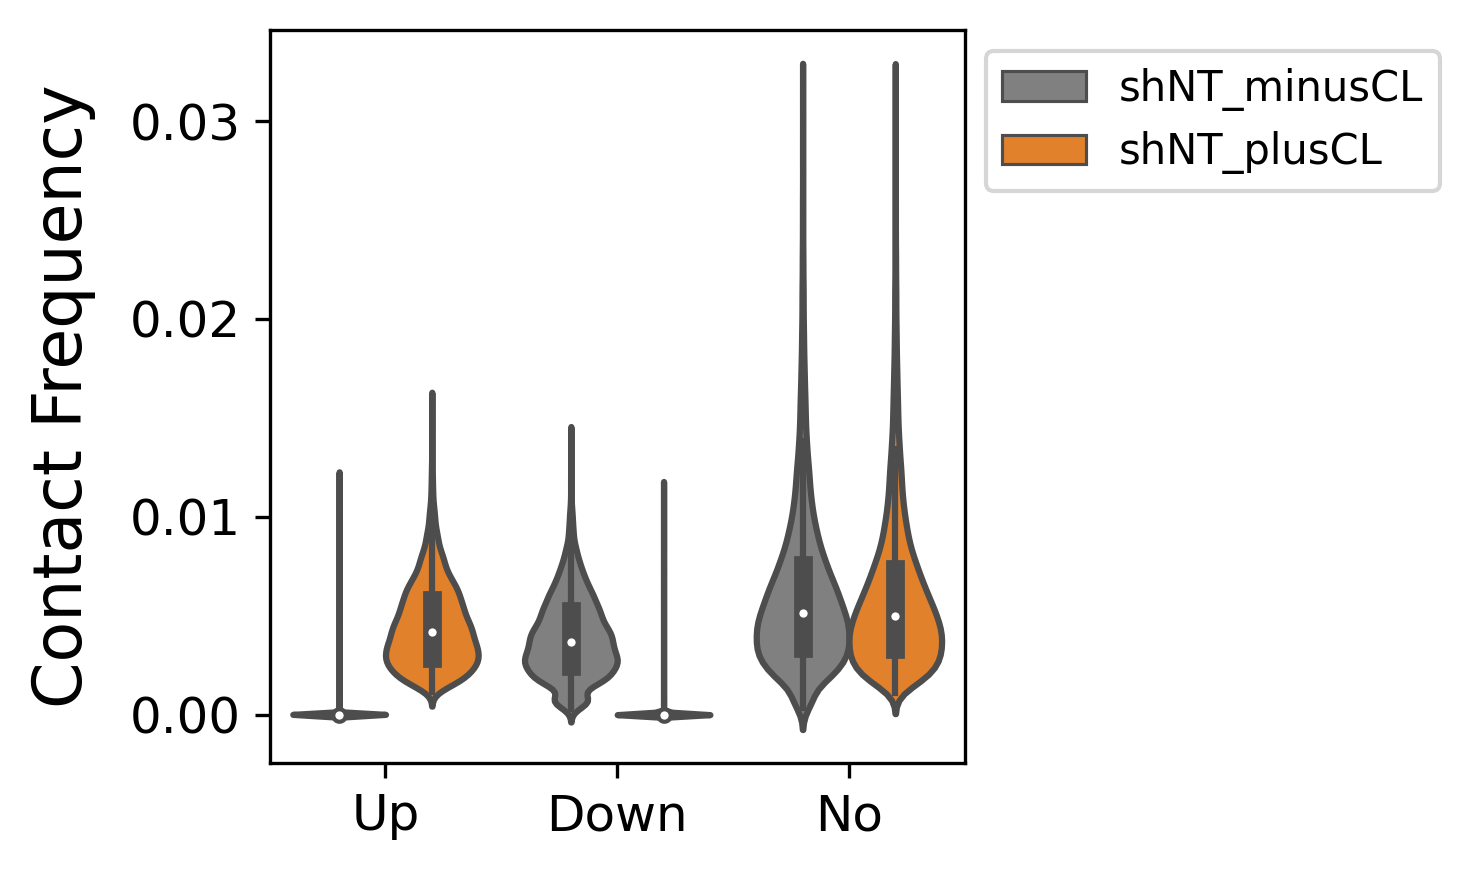

In [8]:
## quantile-normalization and show the loop scores for diff loops
plot_df = pd.DataFrame(quantile_norm(union_loops[['score_shNT_plusCL', 'score_shNT_minusCL']]),
            columns = ['shNT_plusCL', 'shNT_minusCL'])
plot_df['Type']=union_loops['Type'].tolist()
pplot_df = plot_df.melt(id_vars = ['Type'])
pplot_df['variable'] = pd.Categorical(pplot_df['variable'], ['shNT_minusCL', 'shNT_plusCL'])
pplot_df['Type'] = pd.Categorical(pplot_df['Type'], ['Up', 'Down', 'No'])

## plot
fig, ax = plt.subplots(figsize = (5, 3))
sns.violinplot(data = pplot_df, x = 'Type', y = 'value',
               hue = 'variable', ax = ax, scale = 'width', 
               palette={'shNT_minusCL':'grey', 
                        'shNT_plusCL':plt.cm.get_cmap('tab10')(1)})
ax.set(xlabel = '', ylabel = 'Contact Frequency')
ax.legend(title = '', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
fig.savefig('Figures/diff_loop_violin.pdf')


In [9]:
plot_df.groupby('Type').apply(lambda df: ttest_ind(df['shNT_plusCL'], df['shNT_minusCL']))


Type
Down                    (-175.53407326589135, 0.0)
No      (-1.3830188926314058, 0.16666804579576353)
Up                        (184.8443390508133, 0.0)
dtype: object

### APA plot

In [10]:
r = 10000
cond1 = 'shNT_plusCL'
cond2 = 'shNT_minusCL'
cond3 = 'KD_plusCL'
## load cool file for APA plots
cool1_path = './merge_pairs_mapq5/remove100bp/cool/'+cond1+'_mapq5_merge.pairs_%s.cool'%r
cool2_path = './merge_pairs_mapq5/remove100bp/cool/'+cond2+'_mapq5_merge.pairs_%s.cool'%r
cool3_path = './merge_pairs_mapq5/remove100bp/cool/'+cond3+'_mapq5_merge.pairs_%s.cool'%r

clr1 = cooler.Cooler(cool1_path)
clr2 = cooler.Cooler(cool2_path)
clr3 = cooler.Cooler(cool3_path)

# Use bioframe to fetch the genomic features from the UCSC.
# mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
# mm10_cens = bioframe.fetch_centromeres('mm10')
# mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)
d = pk.load(open('mm10_bioframe.pk', 'rb'))
mm10_chromsizes=d['mm10_chromsizes']
mm10_cens=d['mm10_cens']
mm10_arms=d['mm10_arms']
# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[clr1.chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

### compute expected loop scores as background
# expected1 = expected_cis(
#             clr1,
#             ignore_diags=0,
#             view_df=mm10_arms,
#             chunksize=100000)
# out = open('expected1.pk', 'wb')
# pk.dump(expected1, out)
# out.close()

# expected2 = expected_cis(
#             clr2,
#             ignore_diags=0,
#             view_df=mm10_arms,
#             chunksize=1000000)
# out = open('expected2.pk', 'wb')
# pk.dump(expected2, out)
# out.close()

# expected3 = expected_cis(
#             clr3,
#             ignore_diags=0,
#             view_df=mm10_arms,
#             chunksize=1000000)
# out = open('expected3.pk', 'wb')
# pk.dump(expected3, out)
# out.close()

out = open('expected1_10k.pk', 'rb')
expected1 = pk.load(out)
out.close()

out = open('expected2_10k.pk', 'rb')
expected2 = pk.load(out)
out.close()

out = open('expected3_10k.pk', 'rb')
expected3 = pk.load(out)
out.close()


In [ ]:
### plot APA for up loop in three conditions
pup1 = coolpup.pileup(clr1, up_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)


plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, 
#              vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

pup2 = coolpup.pileup(clr2, up_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

pup3 = coolpup.pileup(clr3, up_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()


In [ ]:
### plot APA for down loop in three conditions

pup1 = coolpup.pileup(clr1, down_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)


plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, 
             vmax = 4.1, vmin = 1.3,
             height=1.5)
plt.show()

pup2 = coolpup.pileup(clr2, down_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 3, vmin = 1.3,
             height=1.5)
plt.show()

pup3 = coolpup.pileup(clr3, down_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4.1, vmin = 1.3,
             height=1.5)
plt.show()


In [ ]:
### plot APA for no change loop in three conditions

pup1 = coolpup.pileup(clr1, stable_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)


plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, 
#              vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

pup2 = coolpup.pileup(clr2, stable_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 6.2, vmin = 1.5,
             height=1.5)
plt.show()

pup3 = coolpup.pileup(clr3, stable_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected2,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 6.2, vmin = 1.5,
             height=1.5)
plt.show()


### integrate loop change with gene expression


In [12]:
## load differential expression result and expression TPM matrix
out = open('20221212_RNA-seq_diffexp_repCorrect.pk', 'rb')
diffexp = pk.load(out)
out.close()

exp_tpm = pd.read_csv('tpm_matrix.csv', index_col = 0)


In [ ]:
### diff loop with gene expression change in boxplot
up_loop_anchor = up_loop[['chrom1', 'start1', 'end1']].values.tolist()+up_loop[['chrom2', 'start2', 'end2']].values.tolist()
up_loop_anchor = pd.DataFrame(up_loop_anchor, columns = ['chr', 'start', 'end'])
down_loop_anchor =down_loop[['chrom1', 'start1', 'end1']].values.tolist()+down_loop[['chrom2', 'start2', 'end2']].values.tolist()
down_loop_anchor = pd.DataFrame(down_loop_anchor, columns = ['chr', 'start', 'end'])
stable_loop_anchor =stable_loop[['chrom1', 'start1', 'end1']].values.tolist()+stable_loop[['chrom2', 'start2', 'end2']].values.tolist()
stable_loop_anchor = pd.DataFrame(stable_loop_anchor, columns = ['chr', 'start', 'end'])

pdf = PdfPages('Figures/all_loop_mRNA_fc.pdf')
plot_df = _plot_loop_exp_(mm10_tss_ann, up_loop_anchor, down_loop_anchor, 
                stable_loop_anchor, diffexp['shNT_plusCL_vs_minusCL'], d = 5000, figsize = (4,4.5),
                         pdf = pdf)
pdf.close()


In [18]:
### classify loops into E-P, P-P, P-O, and check them with gene expression change in boxplot

## EP
q1 = '(r1_promoter == True and r2_ELS == True and r2_K27ac == True) or (r2_promoter == True and r1_ELS == True and r1_K27ac == True)'
## PP
q2 = '(r1_promoter == True and r2_promoter == True)'
## P-other
q3 = '(r1_promoter == True and (r2_ELS != True or r2_K27ac != True) and r2_promoter != True) or (r2_promoter == True and (r1_ELS != True or r1_K27ac != True) and r1_promoter != True)'

d = 5000

## promoter define from mm10 genome
mm10_promoter = mm10_tss_ann.copy()
mm10_promoter['start'] = mm10_tss_ann['start'] - d
mm10_promoter['end'] = mm10_tss_ann['end'] + d
mm10_promoter = mm10_promoter[mm10_promoter['start']>0]

mm10_promoter_bed = pybedtools.BedTool.from_dataframe(mm10_promoter)

## define enhancer
mm10_cRE = pd.read_csv('./mm10-cCREs.bed', sep = '\t', header = None)
mm10_ELS = mm10_cRE[mm10_cRE[5].str.contains('ELS')]
mm10_ELS_bed = pybedtools.BedTool.from_dataframe(mm10_ELS)
mm10_ELS_bed = mm10_ELS_bed.intersect(mm10_promoter_bed, v = True, wa = True)
## our data 
k27ac_plusCL_rep1 = pd.read_csv('./histone/H3K27ac_plusCL.rep1_peaks.narrowPeak', sep = '\t', header = None)
k27ac_plusCL_rep2 = pd.read_csv('./histone/H3K27ac_plusCL.rep2_peaks.narrowPeak', sep = '\t', header = None)
k27ac_minusCL_rep1 = pd.read_csv('./histone/H3K27ac_minusCL.rep1_peaks.narrowPeak', sep = '\t', header = None)
k27ac_minusCL_rep2 = pd.read_csv('./histone/H3K27ac_minusCL.rep2_peaks.narrowPeak', sep = '\t', header = None)
k27ac_union_peaks = pd.concat([k27ac_plusCL_rep1, k27ac_plusCL_rep2, k27ac_minusCL_rep1, k27ac_minusCL_rep2])
k27ac_union_peaks_bed = pybedtools.BedTool.from_dataframe(k27ac_union_peaks.iloc[:,0:3])
k27ac_union_peaks_bed = k27ac_union_peaks_bed.intersect(mm10_promoter_bed, v = True, wa = True)

ELS_k27ac_union_peaks_bed = mm10_ELS_bed.intersect(k27ac_union_peaks_bed, wa = True)


### annotate 
# union_loops_genes = pd.concat([up_dots, down_dots, stable_dots]) 
union_loops_genes = union_loops.copy()
score_qnorm = pd.DataFrame(quantile_norm(union_loops[['score_shNT_plusCL', 'score_shNT_minusCL']]),
            columns = ['shNT_plusCL', 'shNT_minusCL'])
union_loops_genes['score_shNT_plusCL'] = score_qnorm['shNT_plusCL'].tolist()
union_loops_genes['score_shNT_minusCL'] = score_qnorm['shNT_minusCL'].tolist()

union_loops_genes['r1'] = union_loops_genes['chrom1']+':'+union_loops_genes['start1'].astype('str')+'-'+union_loops_genes['end1'].astype('str')
union_loops_genes['r2'] = union_loops_genes['chrom2']+':'+union_loops_genes['start2'].astype('str')+'-'+union_loops_genes['end2'].astype('str')
## overlap with promoter
r1 = pybedtools.BedTool.from_dataframe(union_loops_genes[['chrom1','start1','end1', 'r1']])
r2 = pybedtools.BedTool.from_dataframe(union_loops_genes[['chrom2','start2','end2', 'r2']])
r1_promoter = r1.intersect(mm10_promoter_bed, wao = True).to_dataframe().drop_duplicates()
r2_promoter = r2.intersect(mm10_promoter_bed, wao = True).to_dataframe().drop_duplicates()

## overlap with ELS
r1_ELS = r1.intersect(mm10_ELS_bed, wao = True).to_dataframe().drop_duplicates()
r2_ELS = r2.intersect(mm10_ELS_bed, wao = True).to_dataframe().drop_duplicates()

## overlap with K27ac
r1_K27ac = r1.intersect(k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()
r2_K27ac = r2.intersect(k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()

## overlap with ELS_K27ac
r1_ELS_K27ac = r1.intersect(ELS_k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()
r2_ELS_K27ac = r2.intersect(ELS_k27ac_union_peaks_bed, wao = True).to_dataframe().drop_duplicates()

union_loops_genes['r1_promoter'] = union_loops_genes['r1'].isin(r1_promoter.query('score != "."')['name'])
union_loops_genes['r2_promoter'] = union_loops_genes['r2'].isin(r2_promoter.query('score != "."')['name'])
union_loops_genes['r1_ELS'] = union_loops_genes['r1'].isin(r1_ELS.query('score != "."')['name'])
union_loops_genes['r2_ELS'] = union_loops_genes['r2'].isin(r2_ELS.query('score != "."')['name'])
union_loops_genes['r1_K27ac'] = union_loops_genes['r1'].isin(r1_K27ac.query('score != "."')['name'])
union_loops_genes['r2_K27ac'] = union_loops_genes['r2'].isin(r2_K27ac.query('score != "."')['name'])
union_loops_genes['r1_ELS_K27ac'] = union_loops_genes['r1'].isin(r2_ELS_K27ac.query('score != "."')['name'])
union_loops_genes['r2_ELS_K27ac'] = union_loops_genes['r2'].isin(r2_ELS_K27ac.query('score != "."')['name'])


r1_genes = r1_promoter.query('score != "."').groupby('name').apply(lambda df: ';'.join(set([x.split(':')[-1] for x in df['thickEnd'].unique().tolist()]))).to_dict()
r2_genes = r2_promoter.query('score != "."').groupby('name').apply(lambda df: ';'.join(set([x.split(':')[-1] for x in df['thickEnd'].unique().tolist()]))).to_dict()


union_loops_genes['r1_gene'] = [r1_genes.get(x, np.nan) for x in union_loops_genes['r1'].tolist()]
union_loops_genes['r2_gene'] = [r2_genes.get(x, np.nan) for x in union_loops_genes['r2'].tolist()]

union_loops_genes['r1_mRNA_fc'] = [diffexp['shNT_plusCL_vs_minusCL'].reindex(x.split(';'))['log2FoldChange'].mean() if not pd.isna(x) else np.nan for x in union_loops_genes['r1_gene'].tolist()]
union_loops_genes['r2_mRNA_fc'] = [diffexp['shNT_plusCL_vs_minusCL'].reindex(x.split(';'))['log2FoldChange'].mean() if not pd.isna(x) else np.nan for x in union_loops_genes['r2_gene'].tolist()]

## define EP, PP, and PO
EP_df = union_loops_genes.query(q1)

PP_df = union_loops_genes.query(q2)

PO_df = union_loops_genes.query(q3)
OO_df = union_loops_genes[~union_loops_genes['label'].isin(EP_df['label'].tolist()+PP_df['label'].tolist()+PO_df['label'].tolist())]

## calculate scores
EP_df['score_delta'] = EP_df['score_shNT_plusCL'] - EP_df['score_shNT_minusCL']
EP_df['mRNA_fc'] = EP_df[['r1_mRNA_fc', 'r2_mRNA_fc']].apply(lambda row: row.dropna().mean(), axis = 1)

PP_df['score_delta'] = PP_df['score_shNT_plusCL'] - PP_df['score_shNT_minusCL']
PP_df['mRNA_fc'] = PP_df[['r1_mRNA_fc', 'r2_mRNA_fc']].apply(lambda row: row.dropna().mean(), axis = 1)

PO_df['score_delta'] = PO_df['score_shNT_plusCL'] - PO_df['score_shNT_minusCL']
PO_df['mRNA_fc'] = PO_df[['r1_mRNA_fc', 'r2_mRNA_fc']].apply(lambda row: row.dropna().mean(), axis = 1)

### unique gene and unique loop for each row, convenient for visulization 
EP_ddf = _get_values_(EP_df)
PP_ddf = _get_values_(PP_df)
PO_ddf = _get_values_(PO_df)


In [35]:
### classify different loop types for up, down, and no change loops 
up_EP_loop, up_PP_loop, up_PO_loop, up_OO_loop = _define_EP_PP_(up_dots[up_dots['label'].isin(up_loop['label'])])
up_EP_loop['group'] = 'E-P'
up_PP_loop['group'] = 'P-P'
up_PO_loop['group'] = 'P-O'
up_OO_loop['group'] = 'O-O'
up_loop_union = pd.concat([up_EP_loop, up_PP_loop, up_PO_loop, up_OO_loop])

down_EP_loop, down_PP_loop, down_PO_loop, down_OO_loop = _define_EP_PP_(down_dots[down_dots['label'].isin(down_loop['label'])])
down_EP_loop['group'] = 'E-P'
down_PP_loop['group'] = 'P-P'
down_PO_loop['group'] = 'P-O'
down_OO_loop['group'] = 'O-O'
down_loop_union = pd.concat([down_EP_loop, down_PP_loop, down_PO_loop, down_OO_loop])


In [ ]:
## generate gene table for E-P, P-P, and P-O
tab_res = []
for i, line in EP_ddf.iterrows():
    loop = line['label']
    delta = line['score_delta']
    lowess_value = line['lowess']
    for g in line[['r1_gene', 'r2_gene']].dropna().tolist():
        tab_res.append([loop, delta, 'E-P', g, lowess_value])
        
for i, line in PP_ddf.iterrows():
    loop = line['label']
    delta = line['score_delta']
    lowess_value = line['lowess']
    for g in line[['r1_gene', 'r2_gene']].dropna().tolist():
        tab_res.append([loop, delta, 'P-P', g, lowess_value])
        
for i, line in PO_ddf.iterrows():
    loop = line['label']
    delta = line['score_delta']
    lowess_value = line['lowess']
    for g in line[['r1_gene', 'r2_gene']].dropna().tolist():
        tab_res.append([loop, delta, 'P-O', g, lowess_value])
        
tab_res = pd.DataFrame(tab_res, columns = ['loop', 'delta_contact', 'loop_type', 'gene', 'gene_lowess'])
tab_res = pd.merge(tab_res, diffexp['shNT_plusCL_vs_minusCL'], left_on = 'gene', right_index = True)
tab_res = tab_res.sort_values(['delta_contact', 'log2FoldChange'], ascending = False)
## diff loop
loop_de_label = []
for x in tab_res['loop'].tolist():
    if x in up_dots.index.tolist():
        loop_de_label.append('Up')
    elif x in down_dots.index.tolist():
        loop_de_label.append('Down')
    else:
        loop_de_label.append('No')
tab_res['diff_loop'] = loop_de_label
    
tab_res.to_csv('plusCL_vs_minusCL_loop_target_gene_diffexp.tsv', sep = '\t', index = None)


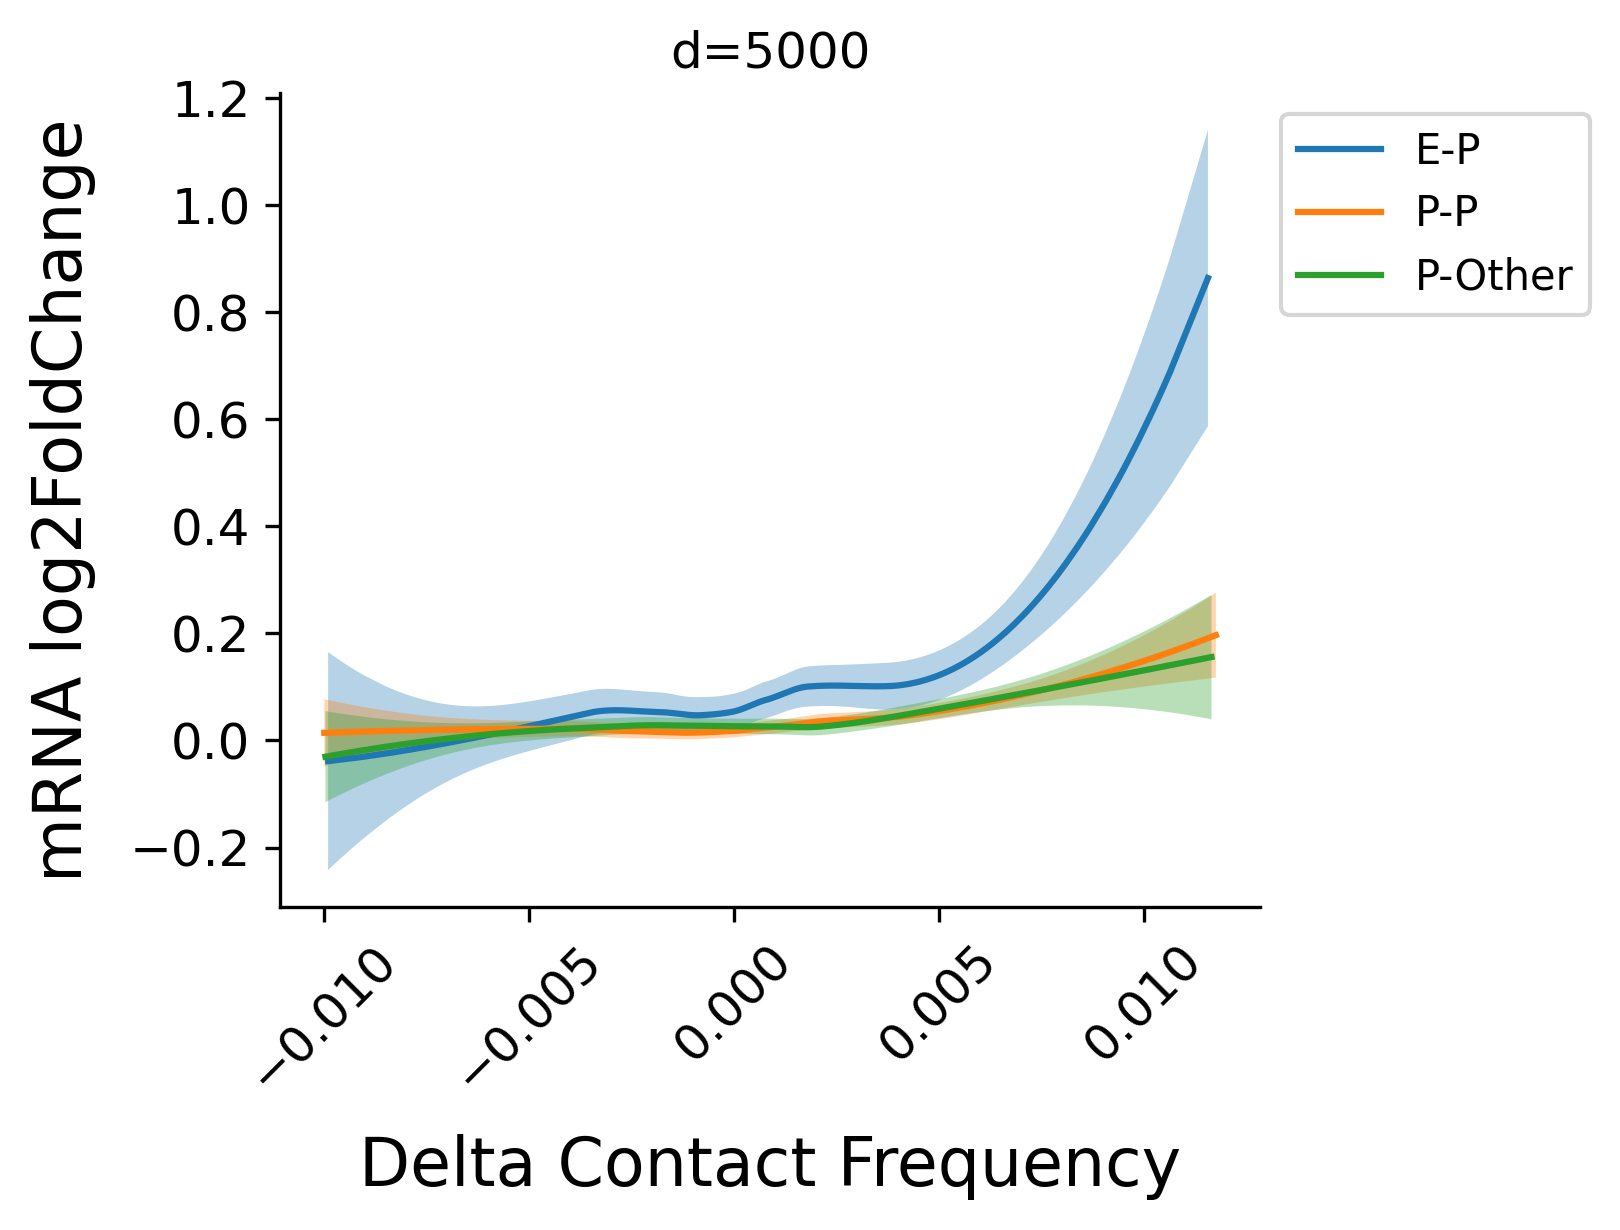

In [29]:
### plot loop delta contact vs. gene expression change
fig, ax = plt.subplots()
q = 'score_delta > -0.010 and score_delta < 0.012'
ax.plot(EP_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'], EP_ddf.drop_duplicates(['label', 'gene']).query(q)['lowess'], label = 'E-P')
ax.plot(PP_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'], PP_ddf.drop_duplicates(['label', 'gene']).query(q)['lowess'], label = 'P-P')
ax.plot(PO_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'], PO_ddf.drop_duplicates(['label', 'gene']).query(q)['lowess'], label = 'P-Other')
ax.fill_between(EP_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'],EP_ddf.drop_duplicates(['label', 'gene']).query(q)['lower_lowess'],EP_ddf.drop_duplicates(['label', 'gene']).query(q)['upper_lowess'],alpha=.33)
ax.fill_between(PP_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'],PP_ddf.drop_duplicates(['label', 'gene']).query(q)['lower_lowess'],PP_ddf.drop_duplicates(['label', 'gene']).query(q)['upper_lowess'],alpha=.33)
ax.fill_between(PO_ddf.drop_duplicates(['label', 'gene']).query(q)['score_delta'],PO_ddf.drop_duplicates(['label', 'gene']).query(q)['lower_lowess'],PO_ddf.drop_duplicates(['label', 'gene']).query(q)['upper_lowess'],alpha=.33)
ax.set(xlabel = 'Delta Contact Frequency', ylabel = 'mRNA log2FoldChange',
      title = 'd=%s'%d)
ax.tick_params(axis = 'x', rotation = 45)
ax.legend(title = '', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
sns.despine()
# fig.savefig('Figures/diffloop_vs_mRNA_fc.pdf')
plt.show()


In [32]:
### read loops identified for each condition
shNT_plusCL_allLoop = pd.read_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_plusCL_mapq5_merge.pairs_5000_loops.0.95.bedpe',
                                 sep = '\t', header = None)
shNT_plusCL_allLoop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
shNT_plusCL_allLoop['label'] = shNT_plusCL_allLoop[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)

shNT_minusCL_allLoop = pd.read_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/shNT_minusCL_mapq5_merge.pairs_5000_loops.0.95.bedpe',
                                  sep = '\t', header = None)
shNT_minusCL_allLoop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
shNT_minusCL_allLoop['label'] = shNT_minusCL_allLoop[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)

KD_plusCL_allLoop = pd.read_csv('./merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/KD_plusCL_mapq5_merge.pairs_5000_loops.0.95.bedpe',
                                 sep = '\t', header = None)
KD_plusCL_allLoop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
KD_plusCL_allLoop['label'] = KD_plusCL_allLoop[['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2']].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)


### define E-P, P-P, P-O loops for each condition
shNT_plusCL_EP, shNT_plusCL_PP, shNT_plusCL_PO, shNT_plusCL_other_df = _define_EP_PP_(shNT_plusCL_allLoop)
shNT_plusCL_EP['group'] = 'EP'
shNT_plusCL_PP['group'] = 'PP'
shNT_plusCL_PO['group'] = 'PO'

shNT_minusCL_EP, shNT_minusCL_PP, shNT_minusCL_PO, shNT_minusCL_other_df = _define_EP_PP_(shNT_minusCL_allLoop)
shNT_minusCL_EP['group'] = 'EP'
shNT_minusCL_PP['group'] = 'PP'
shNT_minusCL_PO['group'] = 'PO'

KD_plusCL_EP, KD_plusCL_PP, KD_plusCL_PO, KD_plusCL_other_df = _define_EP_PP_(KD_plusCL_allLoop)
KD_plusCL_EP['group'] = 'EP'
KD_plusCL_PP['group'] = 'PP'
KD_plusCL_PO['group'] = 'PO'


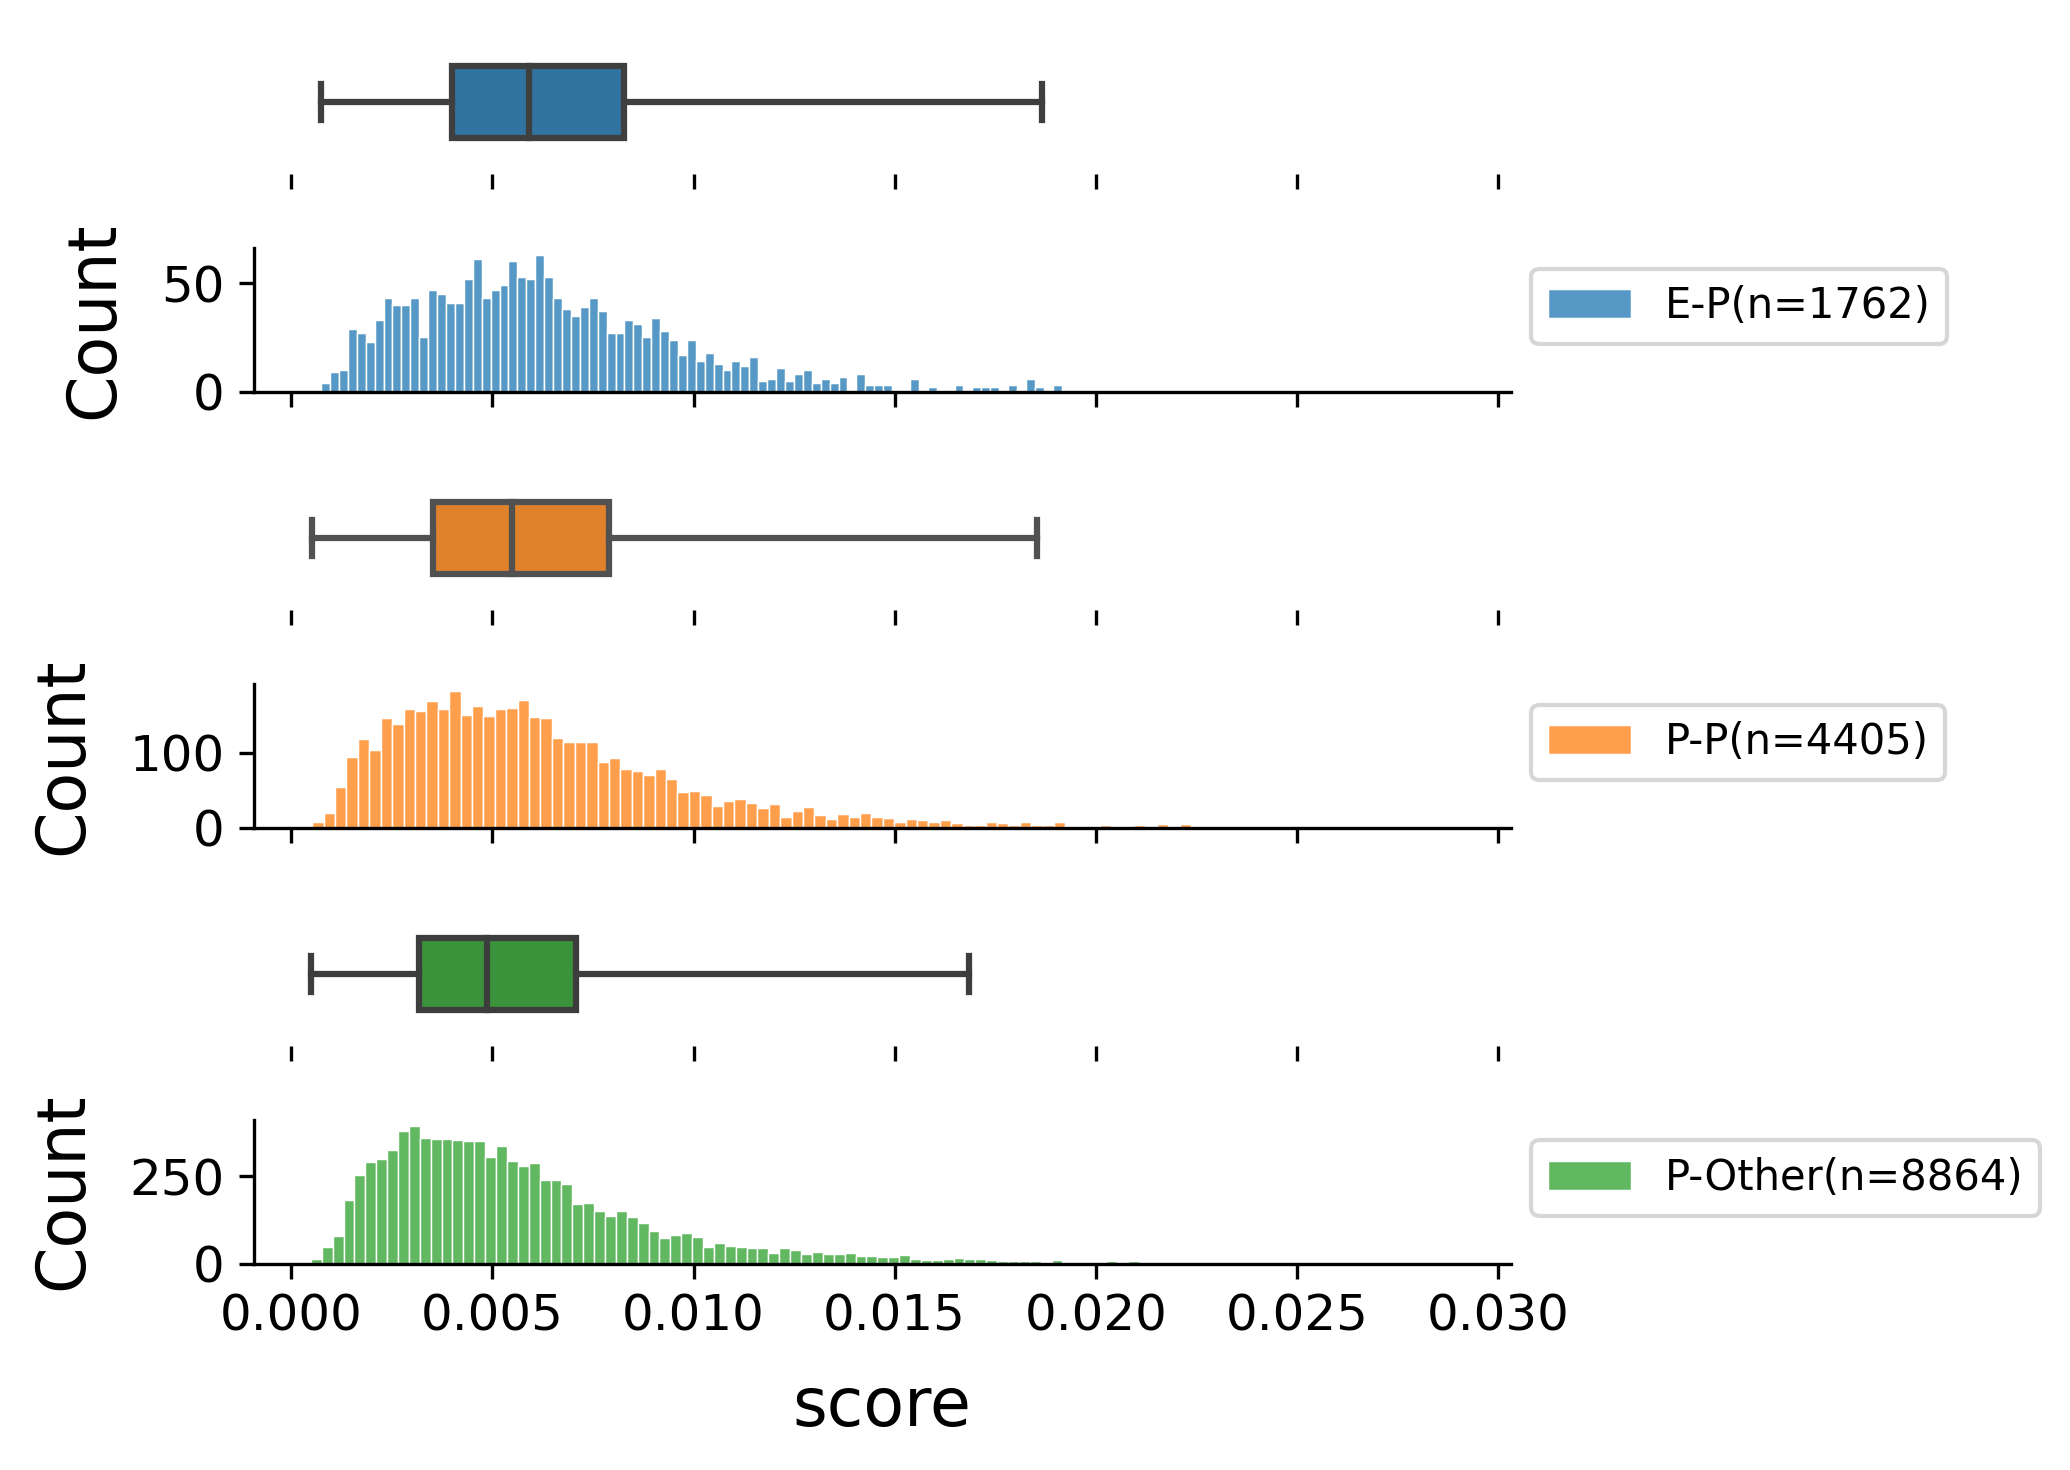

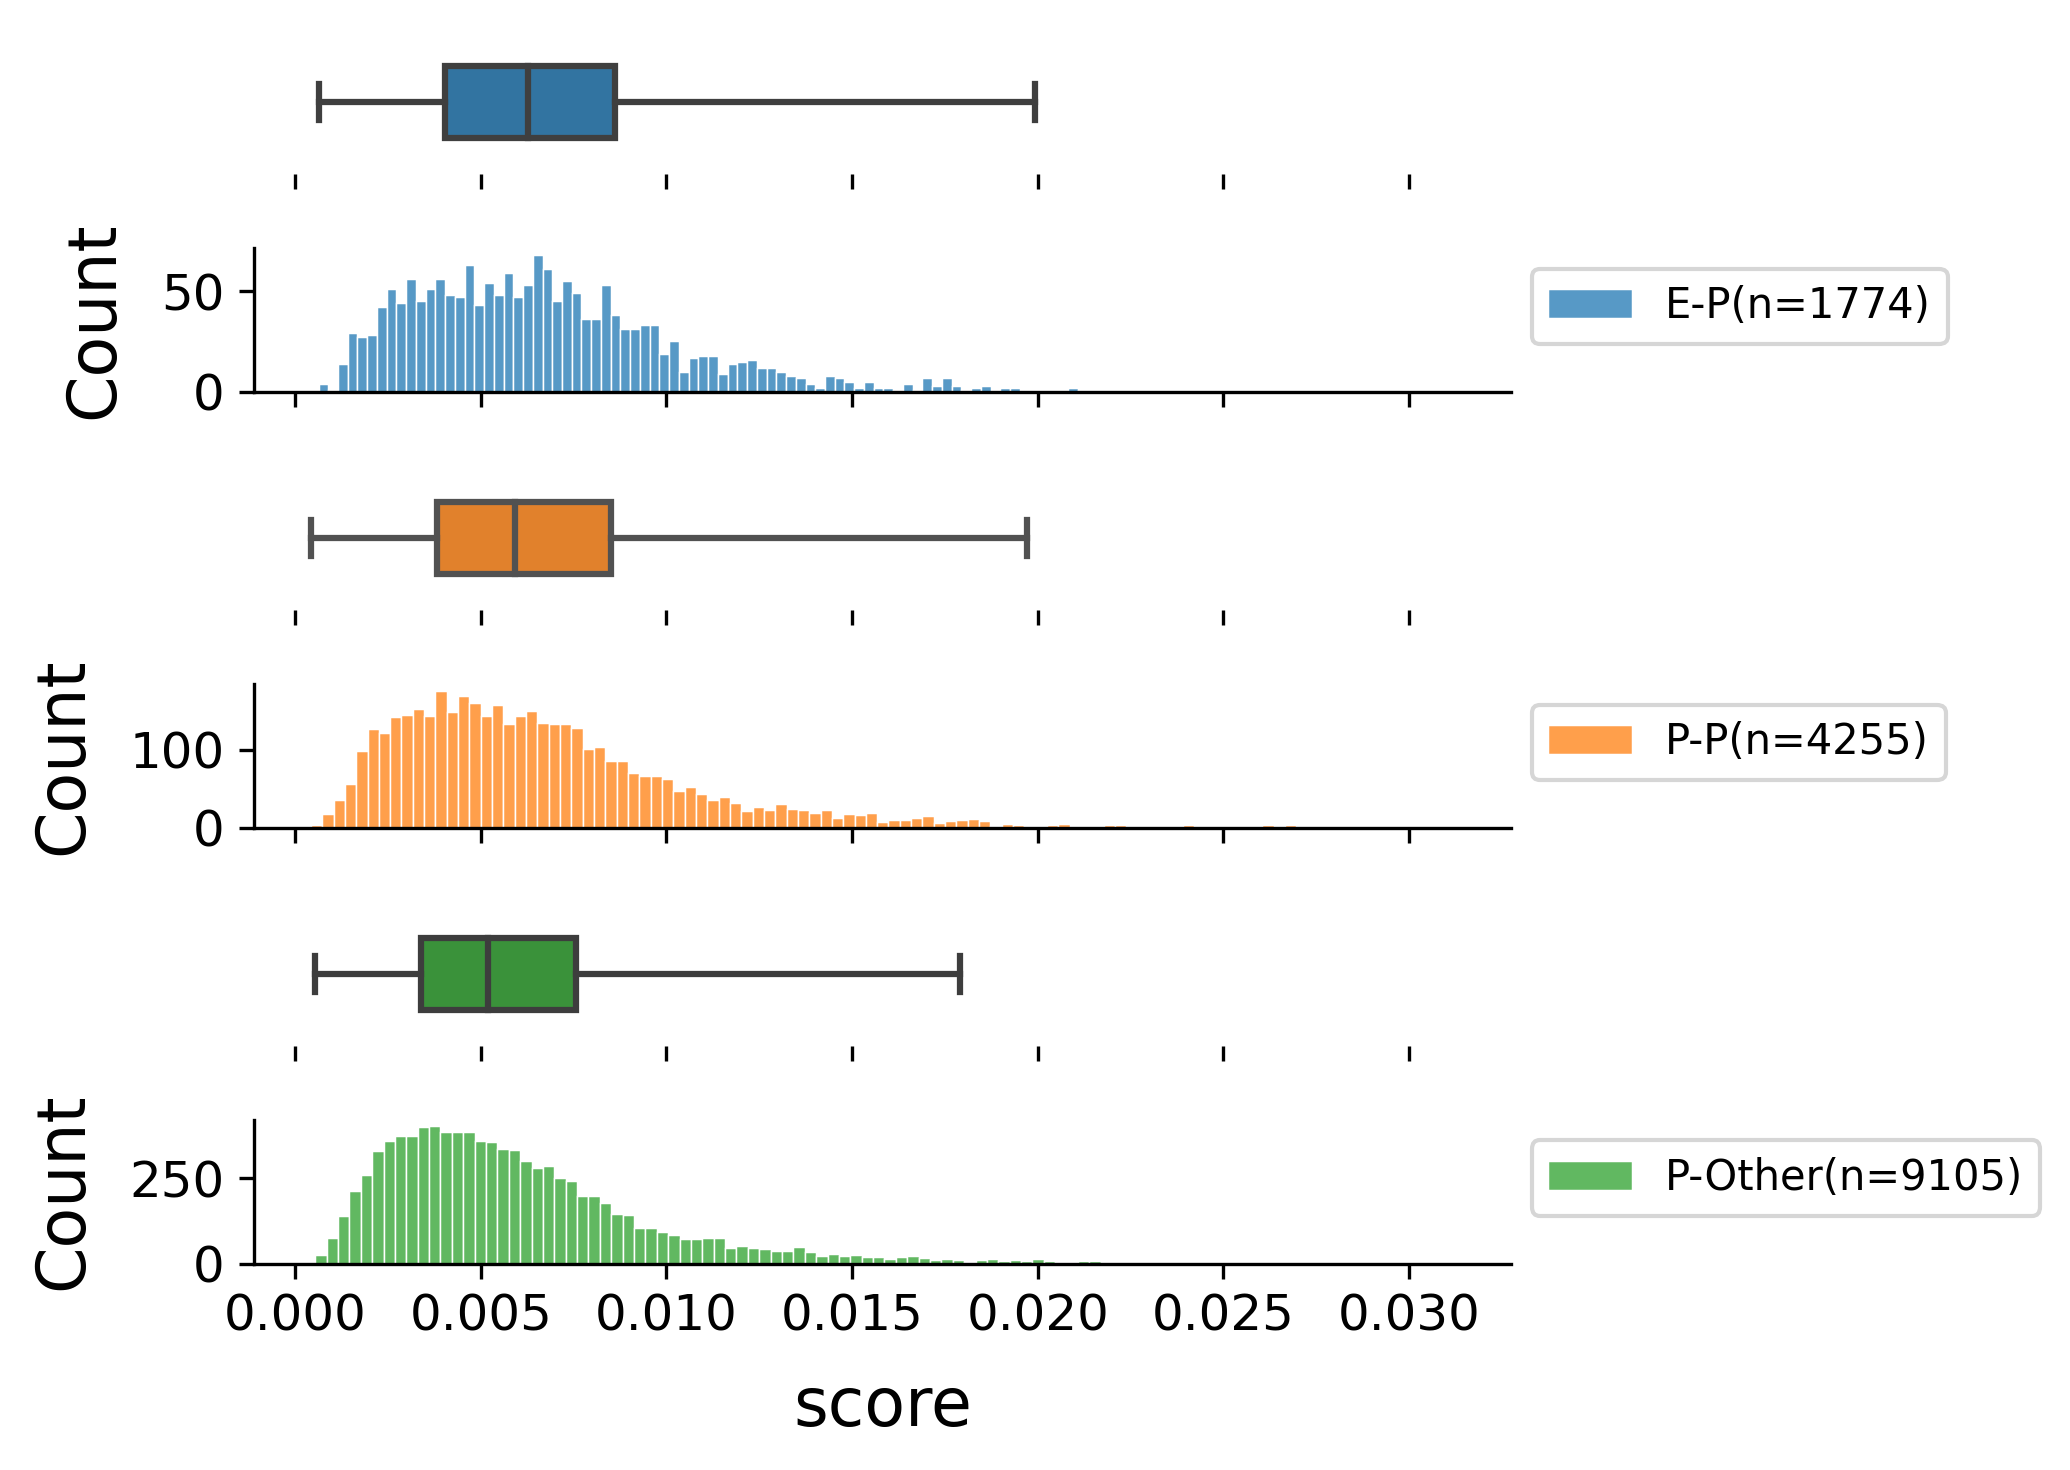

In [36]:
### plot histgram and boxplot to show loop contact frequency for three type of loops
fig, ax = plt.subplots(figsize = (7, 5), nrows = 6, ncols = 1, sharex=True)

sns.boxplot(data = shNT_plusCL_EP, y = 'group', x = 'score', ax = ax[0], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(0), whis = 2.5, width = .5)
sns.histplot(shNT_plusCL_EP['score'], label = 'E-P(n=%s)'%shNT_plusCL_EP.shape[0], 
             ax = ax[1], bins = 100, color = plt.cm.get_cmap('tab10')(0), edgecolor = 'white')

sns.boxplot(data = shNT_plusCL_PP, y = 'group', x = 'score', ax = ax[2], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(1), whis = 2.5, width = .5)
ax[2].set(xlabel = '')
sns.histplot(shNT_plusCL_PP['score'], label = 'P-P(n=%s)'%shNT_plusCL_PP.shape[0], 
             ax = ax[3], bins = 100, color = plt.cm.get_cmap('tab10')(1), edgecolor = 'white')

sns.boxplot(data = shNT_plusCL_PO, y = 'group', x = 'score', ax = ax[4], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(2), whis = 2.5, width = .5)
ax[4].set(xlabel = '')
sns.histplot(shNT_plusCL_PO['score'], label = 'P-Other(n=%s)'%shNT_plusCL_PO.shape[0],
             ax = ax[5], bins = 100, color = plt.cm.get_cmap('tab10')(2), edgecolor = 'white')

for i in [0, 2, 4]:
    ax[i].set(xlabel = '', ylabel = '')
#     ax[i].set_xticks([])
    ax[i].set_yticks([])
    sns.despine(ax = ax[i], left = True, bottom = True)
for i in [1, 3, 5]:
    sns.despine(ax = ax[i])
    ax[i].legend(title = '', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# fig.savefig('Figures/shNT_plusCL_EP_PP_PO_hist_box.pdf')
plt.show()


fig, ax = plt.subplots(figsize = (7, 5), nrows = 6, ncols = 1, sharex=True)

sns.boxplot(data = shNT_minusCL_EP, y = 'group', x = 'score', ax = ax[0], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(0), whis = 2.5, width = .5)
sns.histplot(shNT_minusCL_EP['score'], label = 'E-P(n=%s)'%shNT_minusCL_EP.shape[0], 
             ax = ax[1], bins = 100, color = plt.cm.get_cmap('tab10')(0), edgecolor = 'white')

sns.boxplot(data = shNT_minusCL_PP, y = 'group', x = 'score', ax = ax[2], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(1), whis = 2.5, width = .5)
ax[2].set(xlabel = '')
sns.histplot(shNT_minusCL_PP['score'], label = 'P-P(n=%s)'%shNT_minusCL_PP.shape[0], 
             ax = ax[3], bins = 100, color = plt.cm.get_cmap('tab10')(1), edgecolor = 'white')

sns.boxplot(data = shNT_minusCL_PO, y = 'group', x = 'score', ax = ax[4], 
            showfliers = False, color = plt.cm.get_cmap('tab10')(2), whis = 2.5, width = .5)
ax[4].set(xlabel = '')
sns.histplot(shNT_minusCL_PO['score'], label = 'P-Other(n=%s)'%shNT_minusCL_PO.shape[0],
             ax = ax[5], bins = 100, color = plt.cm.get_cmap('tab10')(2), edgecolor = 'white')

for i in [0, 2, 4]:
    ax[i].set(xlabel = '', ylabel = '')
#     ax[i].set_xticks([])
    ax[i].set_yticks([])
    sns.despine(ax = ax[i], left = True, bottom = True)
for i in [1, 3, 5]:
    sns.despine(ax = ax[i])
    ax[i].legend(title = '', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
# fig.savefig('Figures/shNT_minusCL_EP_PP_PO_hist_box.pdf')
plt.show()



### H2AZ KD Micro-C

In [37]:
#### define H2AZ KD diff loops
cord = ['chrom1','start1','end1','chrom2','start2','end2']
loop_dots_copy = pd.read_csv('loop_dots.csv')

loop_dots_copy['log2fc'] = loop_dots_copy.apply(lambda row: np.log2(row['prob_KD_plusCL'])-np.log2(np.clip(row['prob_shNT_plusCL'], a_min=0.0001, a_max = 1)), axis = 1)
loop_dots_copy['delta'] = loop_dots_copy['prob_KD_plusCL'] - loop_dots_copy['prob_shNT_plusCL']
loop_dots_copy['label'] = loop_dots_copy[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)

## define up and down dots using 2-fold as cutoff
KD_up_dots = loop_dots_copy.query('log2fc > 1')
KD_up_dots['Type'] = 'KD_vs_shNT_plusCL_up'
KD_down_dots = loop_dots_copy.query('log2fc < -1')
KD_down_dots['Type'] = 'KD_vs_shNT_plusCL_down'
KD_stable_dots = loop_dots_copy.query('log2fc >= -1 and log2fc <= 1')
KD_stable_dots['Type'] = 'KD_vs_shNT_plusCL_No'

### read in the Peakachu pooled loops
KD_up_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/KD_vs_shNT_plusCL_up_loops_5000.pool.bedpe',
                      sep = '\t', header = None)
KD_up_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
KD_up_loop['size1'] = KD_up_loop['end1'] - KD_up_loop['start1']
KD_up_loop['size2'] = KD_up_loop['end2'] - KD_up_loop['start2']
KD_up_loop['distance'] = KD_up_loop['start2'] - KD_up_loop['start1']

###
KD_down_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/KD_vs_shNT_plusCL_down_loops_5000.pool.bedpe',
                       sep = '\t', header = None)
KD_down_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
KD_down_loop['size1'] = KD_down_loop['end1'] - KD_down_loop['start1']
KD_down_loop['size2'] = KD_down_loop['end2'] - KD_down_loop['start2']
KD_down_loop['distance'] =KD_down_loop['start2'] - KD_down_loop['start1']
####
KD_stable_loop = pd.read_csv('merge_pairs_mapq5/remove100bp/loops/Peakahu_analysis/KD_vs_shNT_plusCL_stable_loops_5000.pool.bedpe',
                       sep = '\t', header = None)
KD_stable_loop.columns = ['chrom1', 'start1', 'end1', 'chrom2', 'start2', 'end2', 'prob', 'score']
KD_stable_loop['size1'] = KD_stable_loop['end1'] - KD_stable_loop['start1']
KD_stable_loop['size2'] = KD_stable_loop['end2'] - KD_stable_loop['start2']
KD_stable_loop['distance'] = KD_stable_loop['start2'] - KD_stable_loop['start1']

KD_up_loop['label'] = KD_up_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)
KD_down_loop['label'] = KD_down_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)
KD_stable_loop['label'] = KD_stable_loop[cord].apply(lambda x: '-'.join(x.astype('str').tolist()), axis = 1)



<ipython-input-37-55a3721a4999>:5: RuntimeWarning: divide by zero encountered in log2
  loop_dots_copy['log2fc'] = loop_dots_copy.apply(lambda row: np.log2(row['prob_KD_plusCL'])-np.log2(np.clip(row['prob_shNT_plusCL'], a_min=0.0001, a_max = 1)), axis = 1)


{'Up': 760, 'Down': 7748, 'Stable': 17091}


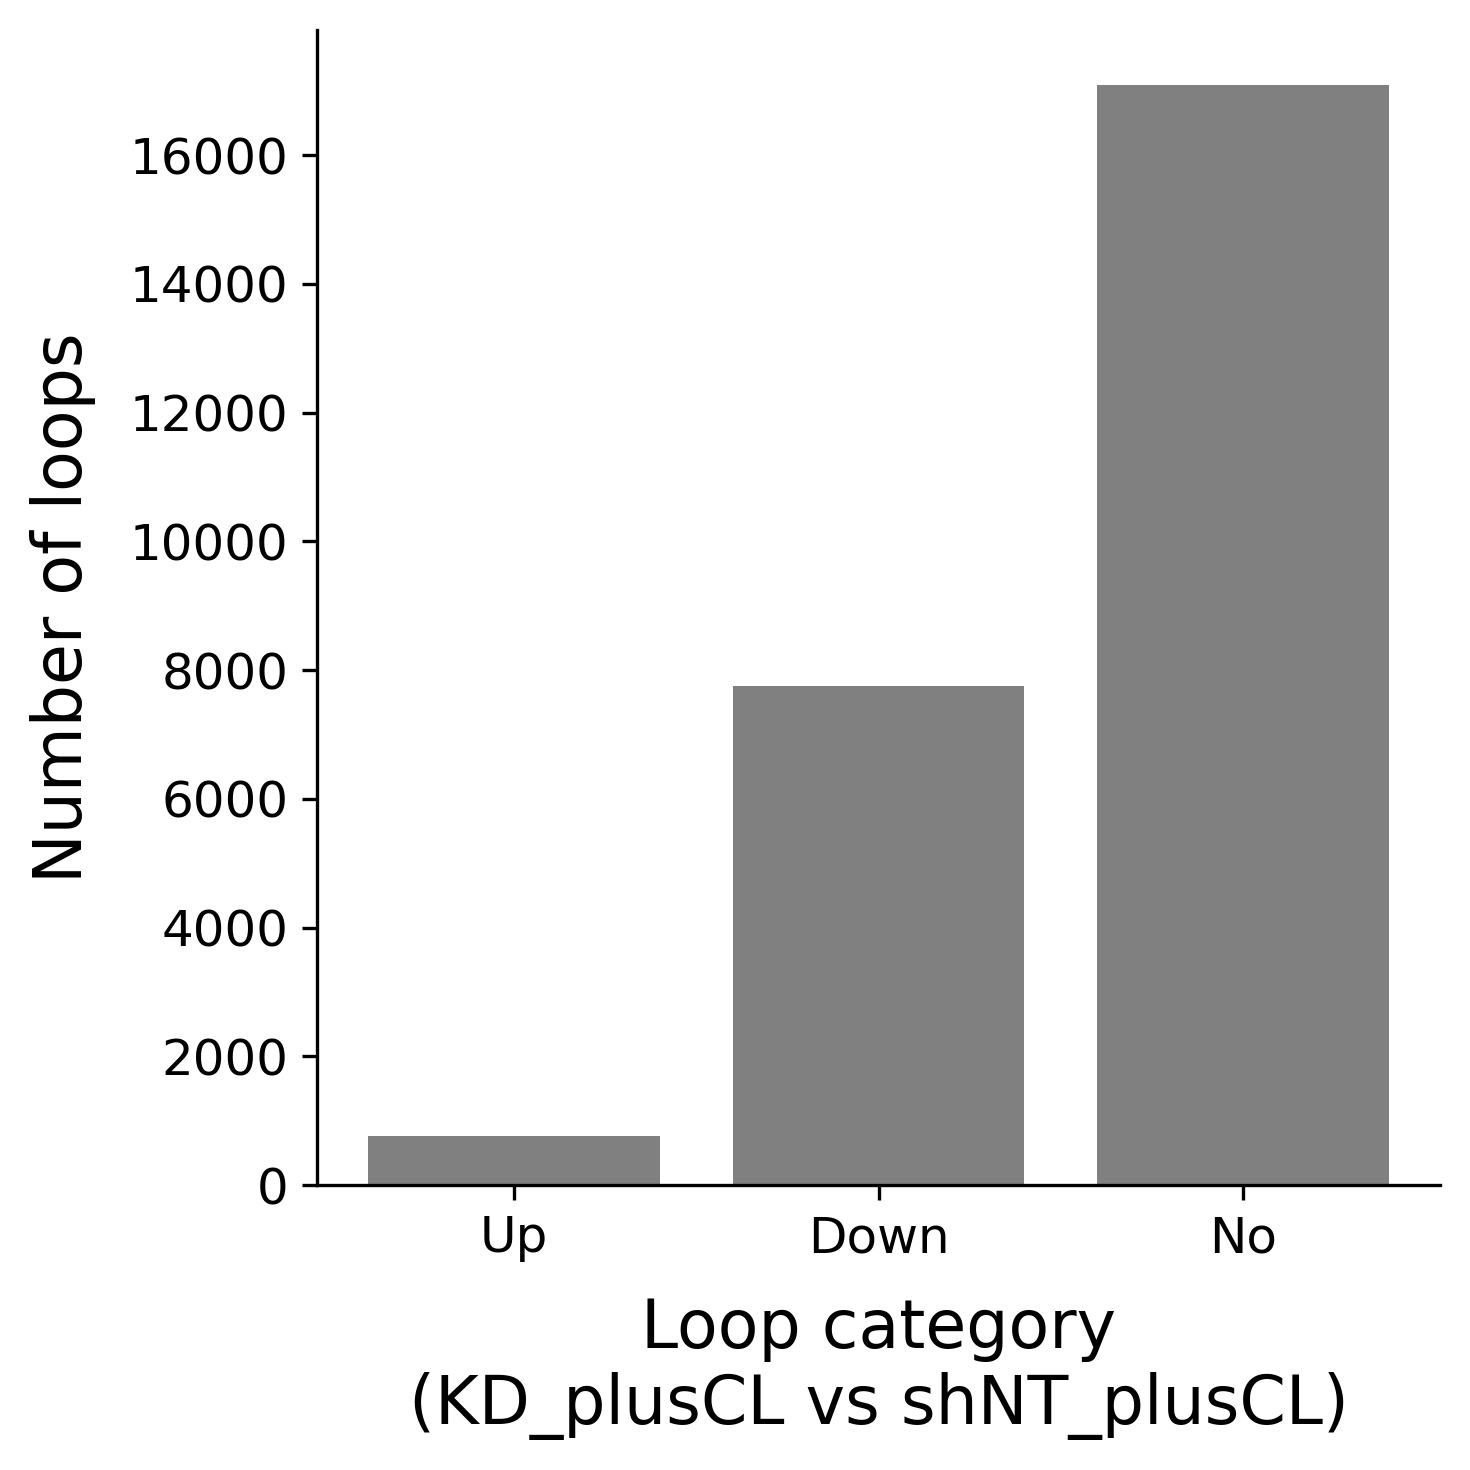

In [38]:
### barplot showing the number of differential loops upon H2AZ KD
print({'Up':KD_up_loop.shape[0], 'Down':KD_down_loop.shape[0], 'Stable':KD_stable_loop.shape[0]})
fig, ax = plt.subplots(figsize = (5,5))
ax.bar(['Up', 'Down', 'No'], 
       [KD_up_loop.shape[0], KD_down_loop.shape[0], KD_stable_loop.shape[0]],
      color = 'grey')
ax.set(xlabel='Loop category\n(KD_plusCL vs shNT_plusCL)',
      ylabel = 'Number of loops')
sns.despine()
plt.tight_layout()
fig.savefig('Figures/Number_diffLoop_upon_H2AZ_KD.pdf')
plt.show()

In [39]:
### classify E-P, P-P, P-O loops for down-regulated loops upon H2AZ KD
KD_down_EP_df, KD_down_PP_df, KD_down_PO_df, KD_down_other_df = _define_EP_PP_(KD_down_loop, comp = 'plusCL_KD_vs_shNT')

KD_down_EP_df['group'] = 'E-P'
KD_down_PP_df['group'] = 'P-P'
KD_down_PO_df['group'] = 'P-O'
KD_down_other_df['group'] = 'O-O'
KD_down_loop_union = pd.concat([KD_down_EP_df, KD_down_PP_df, KD_down_PO_df, KD_down_other_df])
KD_down_loop_union.index = KD_down_loop_union['label']


In [ ]:
### APA plot

### up by H2AZ KD
pup1 = coolpup.pileup(clr1, KD_up_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)


plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, 
             vmax = 4.2, vmin = 1.2,
             height=1.5)
plt.show()
plotpup.plot(pup1,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, 
             vmax = 4.2, vmin = 1.2,
             height=1.5)
plt.show()

pup1 = coolpup.pileup(clr3, KD_up_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)


plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()


plotpup.plot(pup1,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()

### down by H2AZ KD

pup2 = coolpup.pileup(clr1, KD_down_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()

pup2 = coolpup.pileup(clr3, KD_down_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

### no change by H2AZ KD
pup3 = coolpup.pileup(clr1, KD_stable_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected1,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()
plotpup.plot(pup3,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 3.4, vmin = 1.1,
             height=1.5)
plt.show()

pup3 = coolpup.pileup(clr3, KD_stable_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 6.6, vmin = 1.5,
             height=1.5)
plt.show()
plotpup.plot(pup3,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 6.6, vmin = 1.5,
             height=1.5)
plt.show()




### H2AZ-dependant loops - CL induce and H2AZ KD down loops - 2fold change

In [42]:
## identify H2AZ-dependant loops - CL induce and KD down loops - 2fold change
tmp = pd.DataFrame(quantile_norm(loop_dots[['score_shNT_plusCL', 'score_shNT_minusCL', 'score_KD_plusCL']].copy()), 
                   columns = ['score_shNT_plusCL', 'score_shNT_minusCL', 'score_KD_plusCL'], index = loop_dots['label'].tolist())

CL_induce_KD_down = up_dots[up_dots['label'].isin(KD_down_dots['label']) & up_dots['label'].isin(up_loop['label'])]
CL_induce_KD_down['score_KD_plusCL'] = tmp.loc[CL_induce_KD_down['label'].tolist(), 'score_KD_plusCL'].tolist()
CL_induce_KD_down['score_shNT_plusCL'] = tmp.loc[CL_induce_KD_down['label'].tolist(), 'score_shNT_plusCL'].tolist()
CL_induce_KD_down['score_shNT_minusCL'] = tmp.loc[CL_induce_KD_down['label'].tolist(), 'score_shNT_minusCL'].tolist()


CL_induce_KD_down_EP, CL_induce_KD_down_PP, CL_induce_KD_down_PO, CL_induce_KD_down_OO = _define_EP_PP_(CL_induce_KD_down, comp = 'plusCL_KD_vs_shNT')

CL_induce_KD_down_tmp = pd.concat([CL_induce_KD_down_EP, CL_induce_KD_down_PP, CL_induce_KD_down_PO, CL_induce_KD_down_OO])
CL_induce_KD_down_tmp['group'] = ['E-P']*CL_induce_KD_down_EP.shape[0]+['P-P']*CL_induce_KD_down_PP.shape[0]+['P-O']*CL_induce_KD_down_PO.shape[0]+['O-O']*CL_induce_KD_down_OO.shape[0]

CL_induce_KD_down_tmp['score_delta'] = CL_induce_KD_down_tmp['score_KD_plusCL'] - CL_induce_KD_down_tmp['score_shNT_plusCL']
CL_induce_KD_down_tmp['mRNA_fc'] = CL_induce_KD_down_tmp[['r1_mRNA_fc', 'r2_mRNA_fc']].apply(lambda row: row.dropna().mean(), axis = 1)

CL_induce_KD_down_exp = _get_values_(CL_induce_KD_down_tmp, comp = 'plusCL_KD_vs_shNT')
CL_induce_KD_down_z = _get_values_(CL_induce_KD_down_tmp, comp = 'plusCL_KD_vs_shNT', value = 'stat')


In [41]:
## APA plot for H2AZ-dependant loops - CL induce and KD down loops - 2fold change
tmp_loop = up_dots[up_dots['label'].isin(KD_down_dots['label']) & up_dots['label'].isin(up_loop['label'])]

pup2 = coolpup.pileup(clr3, tmp_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

## CL induce and KD down loops - 2fold change, for EP, PP, PO
##### E-P
tmp_loop = up_dots[up_dots['label'].isin(KD_down_dots['label']) & 
                   up_dots['label'].isin(up_loop_union.query('group == "E-P"')['label'])]

pup2 = coolpup.pileup(clr3, tmp_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.8, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.8, vmin = 1.3,
             height=1.5)
plt.show()
##### P-P
tmp_loop = up_dots[up_dots['label'].isin(KD_down_dots['label']) & 
                   up_dots['label'].isin(up_loop_union.query('group == "P-P"')['label'])]

pup2 = coolpup.pileup(clr3, tmp_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.5, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.5, vmin = 1.3,
             height=1.5)
plt.show()

#### P-O 
tmp_loop = up_dots[up_dots['label'].isin(KD_down_dots['label']) & 
                   up_dots['label'].isin(up_loop_union.query('group == "P-O"')['label'])]

pup2 = coolpup.pileup(clr3, tmp_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.9, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.9, vmin = 1.3,
             height=1.5)
plt.show()



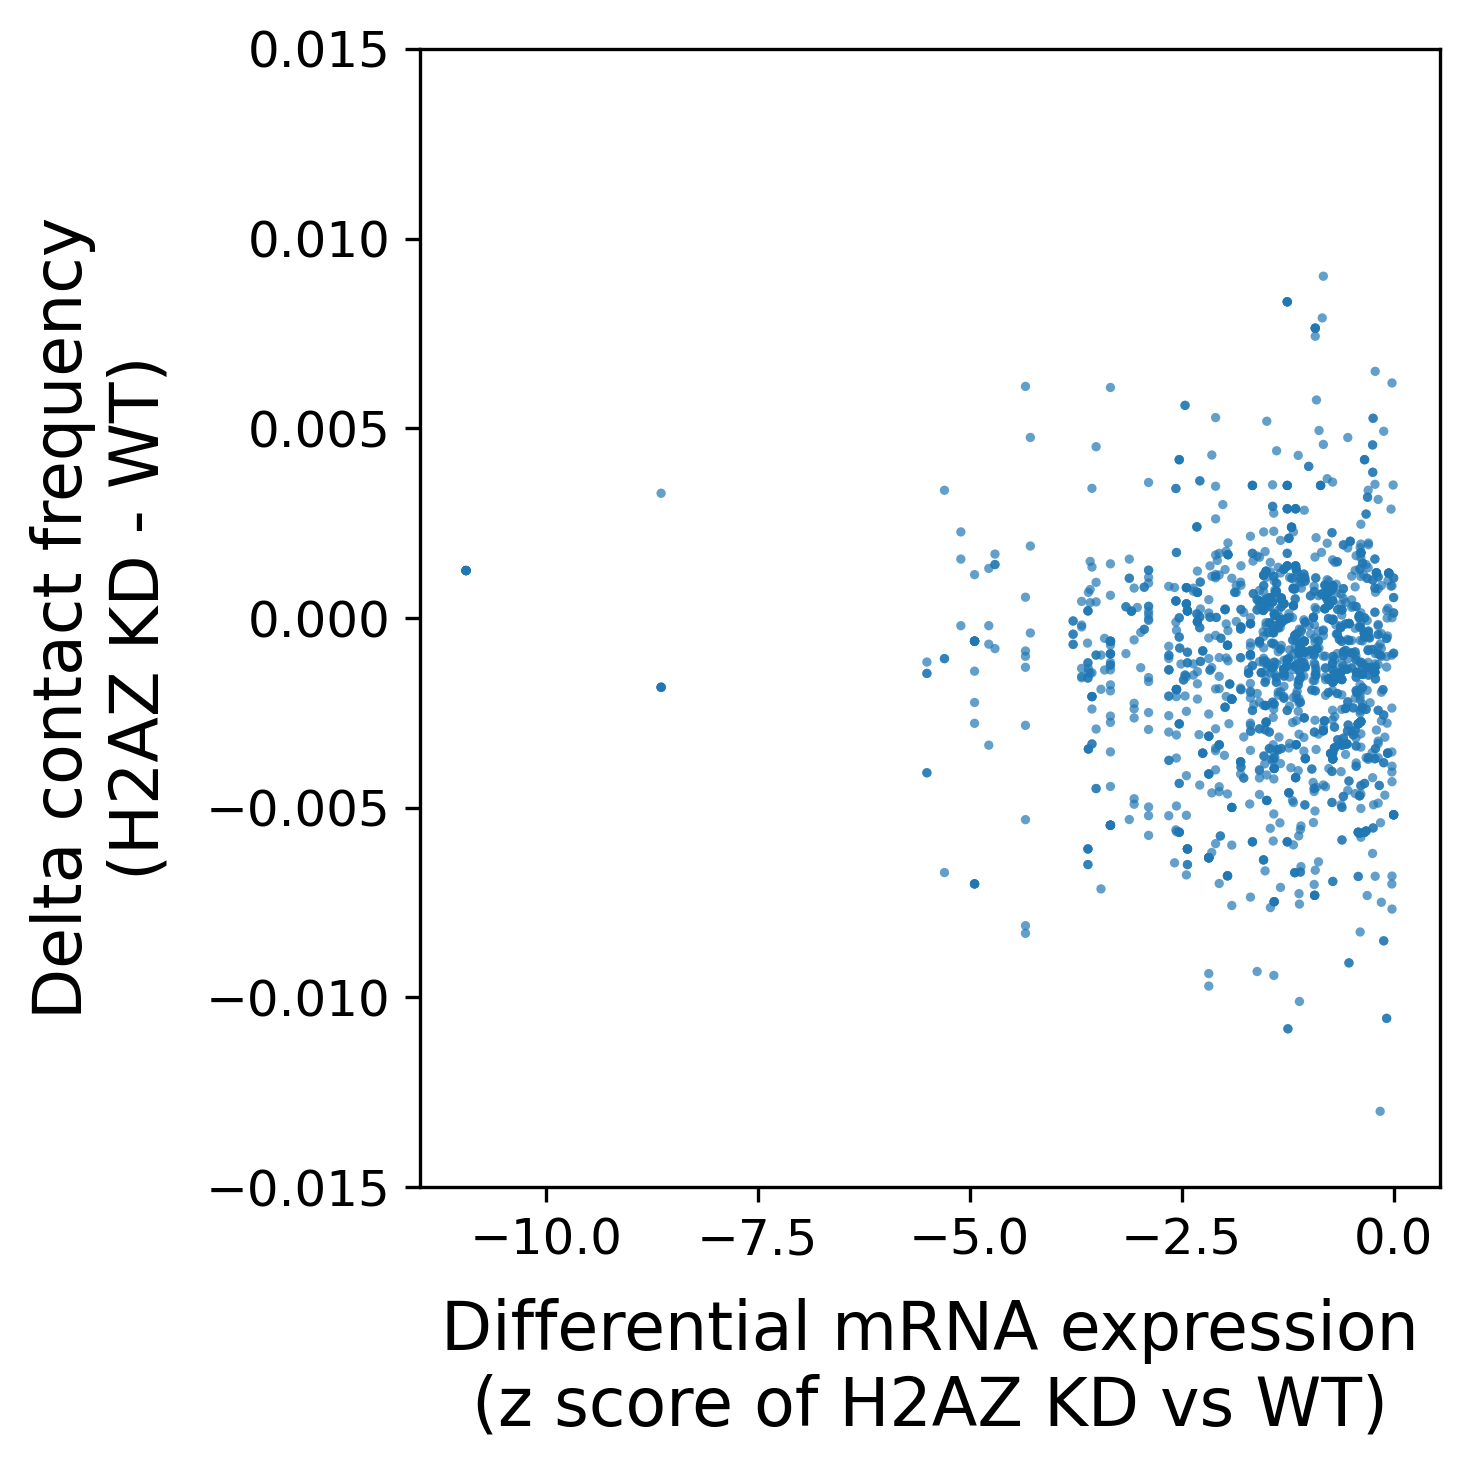

In [44]:
### analyze the loop change and differental expression upon H2AZ KD, particularly for H2AZ-dependant loops and genes
KD_stable_loop['Type'] = 'No'
KD_up_loop['Type'] = 'Up'
KD_down_loop['Type'] = 'Down'

KD_union_loop = pd.concat([KD_up_loop, KD_down_loop, KD_stable_loop])
KD_union_loop_EP, KD_union_loop_PP, KD_union_loop_PO, KD_union_loop_OO = _define_EP_PP_(KD_union_loop, comp = 'plusCL_KD_vs_shNT')
KD_union_loop_EP['group'] = 'EP'
KD_union_loop_PP['group'] = 'PP'
KD_union_loop_PO['group'] = 'PO'
KD_union_loop_OO['group'] = 'OO'
KD_union_loop = pd.concat([KD_union_loop_EP, KD_union_loop_PP, KD_union_loop_PO, KD_union_loop_OO])

tmp = pd.DataFrame(quantile_norm(loop_dots[['score_shNT_plusCL', 'score_shNT_minusCL', 'score_KD_plusCL']].copy()), 
                   columns = ['score_shNT_plusCL', 'score_shNT_minusCL', 'score_KD_plusCL'], index = loop_dots['label'].tolist())
KD_union_loop['score_KD_plusCL'] = tmp.loc[KD_union_loop['label'].tolist(), 'score_KD_plusCL'].tolist()
KD_union_loop['score_shNT_plusCL'] = tmp.loc[KD_union_loop['label'].tolist(), 'score_shNT_plusCL'].tolist()
KD_union_loop['score_delta'] = KD_union_loop['score_KD_plusCL'] - KD_union_loop['score_shNT_plusCL']

tmp = pd.DataFrame(quantile_norm(loop_dots[['prob_shNT_plusCL', 'prob_KD_plusCL']].copy()), 
                   columns = ['prob_shNT_plusCL', 'prob_KD_plusCL'], index = loop_dots['label'].tolist())
KD_union_loop['prob_KD_plusCL'] = tmp.loc[KD_union_loop['label'].tolist(), 'prob_KD_plusCL'].tolist()
KD_union_loop['prob_shNT_plusCL'] = tmp.loc[KD_union_loop['label'].tolist(), 'prob_shNT_plusCL'].tolist()
KD_union_loop['prob_delta'] = KD_union_loop['prob_KD_plusCL'] - KD_union_loop['prob_shNT_plusCL']

KD_union_loop_df = _get_values_(KD_union_loop, comp = 'plusCL_KD_vs_shNT', value = 'stat')

## CL induce and H2AZ KD impaired genes
g1 = diffexp['plusCL_KD_vs_shNT'].query('log2FoldChange < 0')
cut = np.log2(1.5)
g2 = diffexp['shNT_plusCL_vs_minusCL'].query('log2FoldChange > @cut and padj < 0.05')
g = np.intersect1d(g1.index, g2.index)

## down
index1 = [len(np.intersect1d(x.split(';'), g)) > 0 if not pd.isna(x) else False for x in KD_union_loop_df['r1_gene'].tolist()]
index2 = [len(np.intersect1d(x.split(';'), g)) > 0 if not pd.isna(x) else False for x in KD_union_loop_df['r2_gene'].tolist()]
focus_df = KD_union_loop_df.loc[np.array(index1) | np.array(index2),]

focus_df['r1_gene'] = [';'.join(list(np.intersect1d(x.split(';'), g))) if not pd.isna(x) else x for x in focus_df['r1_gene'].tolist()]
focus_df['r2_gene'] = [';'.join(list(np.intersect1d(x.split(';'), g))) if not pd.isna(x) else x for x in focus_df['r2_gene'].tolist()]
focus_df['r1_gene'] = [np.nan if x == '' else x for x in focus_df['r1_gene'].tolist()]
focus_df['r2_gene'] = [np.nan if x == '' else x for x in focus_df['r2_gene'].tolist()]

focus_df = _get_values_(focus_df.drop(['stat'], axis = 1), comp = 'plusCL_KD_vs_shNT', value = 'stat')


fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = focus_df.query('group != "OO"'), x = 'stat', y = 'score_delta',
                edgecolor = 'none', s = 5, alpha = .7)
ax.set(xlabel = 'Differential mRNA expression\n(z score of H2AZ KD vs WT)',
      ylabel = 'Delta contact frequency\n(H2AZ KD - WT)')
ax.set_ylim(-0.015, 0.015)
plt.tight_layout()
# fig.savefig('Figures/CL_induce_H2AZKD_down_gene_associated_loop_changes_scatter.pdf')
plt.show()


### H2AZ ChIP-seq data integration

In [4]:
## ChIP-seq path
H2AZ_path = {'ChIP_04082022_H2AZ_plusCL_rep1':'../H2AZ_Danpos/ChIP_04082022_H2AZ_plusCL_vs_IgG_rep1/pooled/ChIP_04082022_H2AZ_plusCL_unique_rep1.sorted.bam.dedup.bgsub.Fnor.peaks.xls',
            'ChIP_04082022_H2AZ_plusCL_rep2':'../H2AZ_Danpos/ChIP_04082022_H2AZ_plusCL_vs_IgG_rep2/pooled/ChIP_04082022_H2AZ_plusCL_unique_rep2.sorted.bam.dedup.bgsub.Fnor.peaks.xls',
            'ChIP_04082022_H2AZ_plusCL_rep3':'../H2AZ_Danpos/ChIP_04082022_H2AZ_plusCL_vs_IgG_rep3/pooled/ChIP_04082022_H2AZ_plusCL_unique_rep3.sorted.bam.dedup.bgsub.Fnor.peaks.xls',
            }

H2AZ_peaks = {}
for x in H2AZ_path:
    tmp = pd.read_csv(H2AZ_path[x], sep = '\t').query('width_above_cutoff > 147')
    H2AZ_peaks[x] = pybedtools.BedTool.from_dataframe(tmp)
    
### highly reproduciable peaks by replicates
H2AZ_plusCL_reprod_peaks = H2AZ_peaks['ChIP_04082022_H2AZ_plusCL_rep2'].intersect(H2AZ_peaks['ChIP_04082022_H2AZ_plusCL_rep1'], wa=True).intersect(H2AZ_peaks['ChIP_04082022_H2AZ_plusCL_rep3'], wa=True).to_dataframe().drop_duplicates()
H2AZ_plusCL_reprod_peaks_bed = pybedtools.BedTool.from_dataframe(H2AZ_plusCL_reprod_peaks)

H2AZ_bw = {'ChIP_04082022_H2AZ_plusCL_rep1':'../H2AZ_Macs/H2AZCLrep1.rep1_treat_pileup.bw',
            'ChIP_04082022_H2AZ_plusCL_rep2':'../H2AZ_Macs/H2AZCLrep2.rep1_treat_pileup.bw',
            'ChIP_04082022_H2AZ_plusCL_rep3':'../H2AZ_Macs/H2AZCLrep3.rep1_treat_pileup.bw',
}


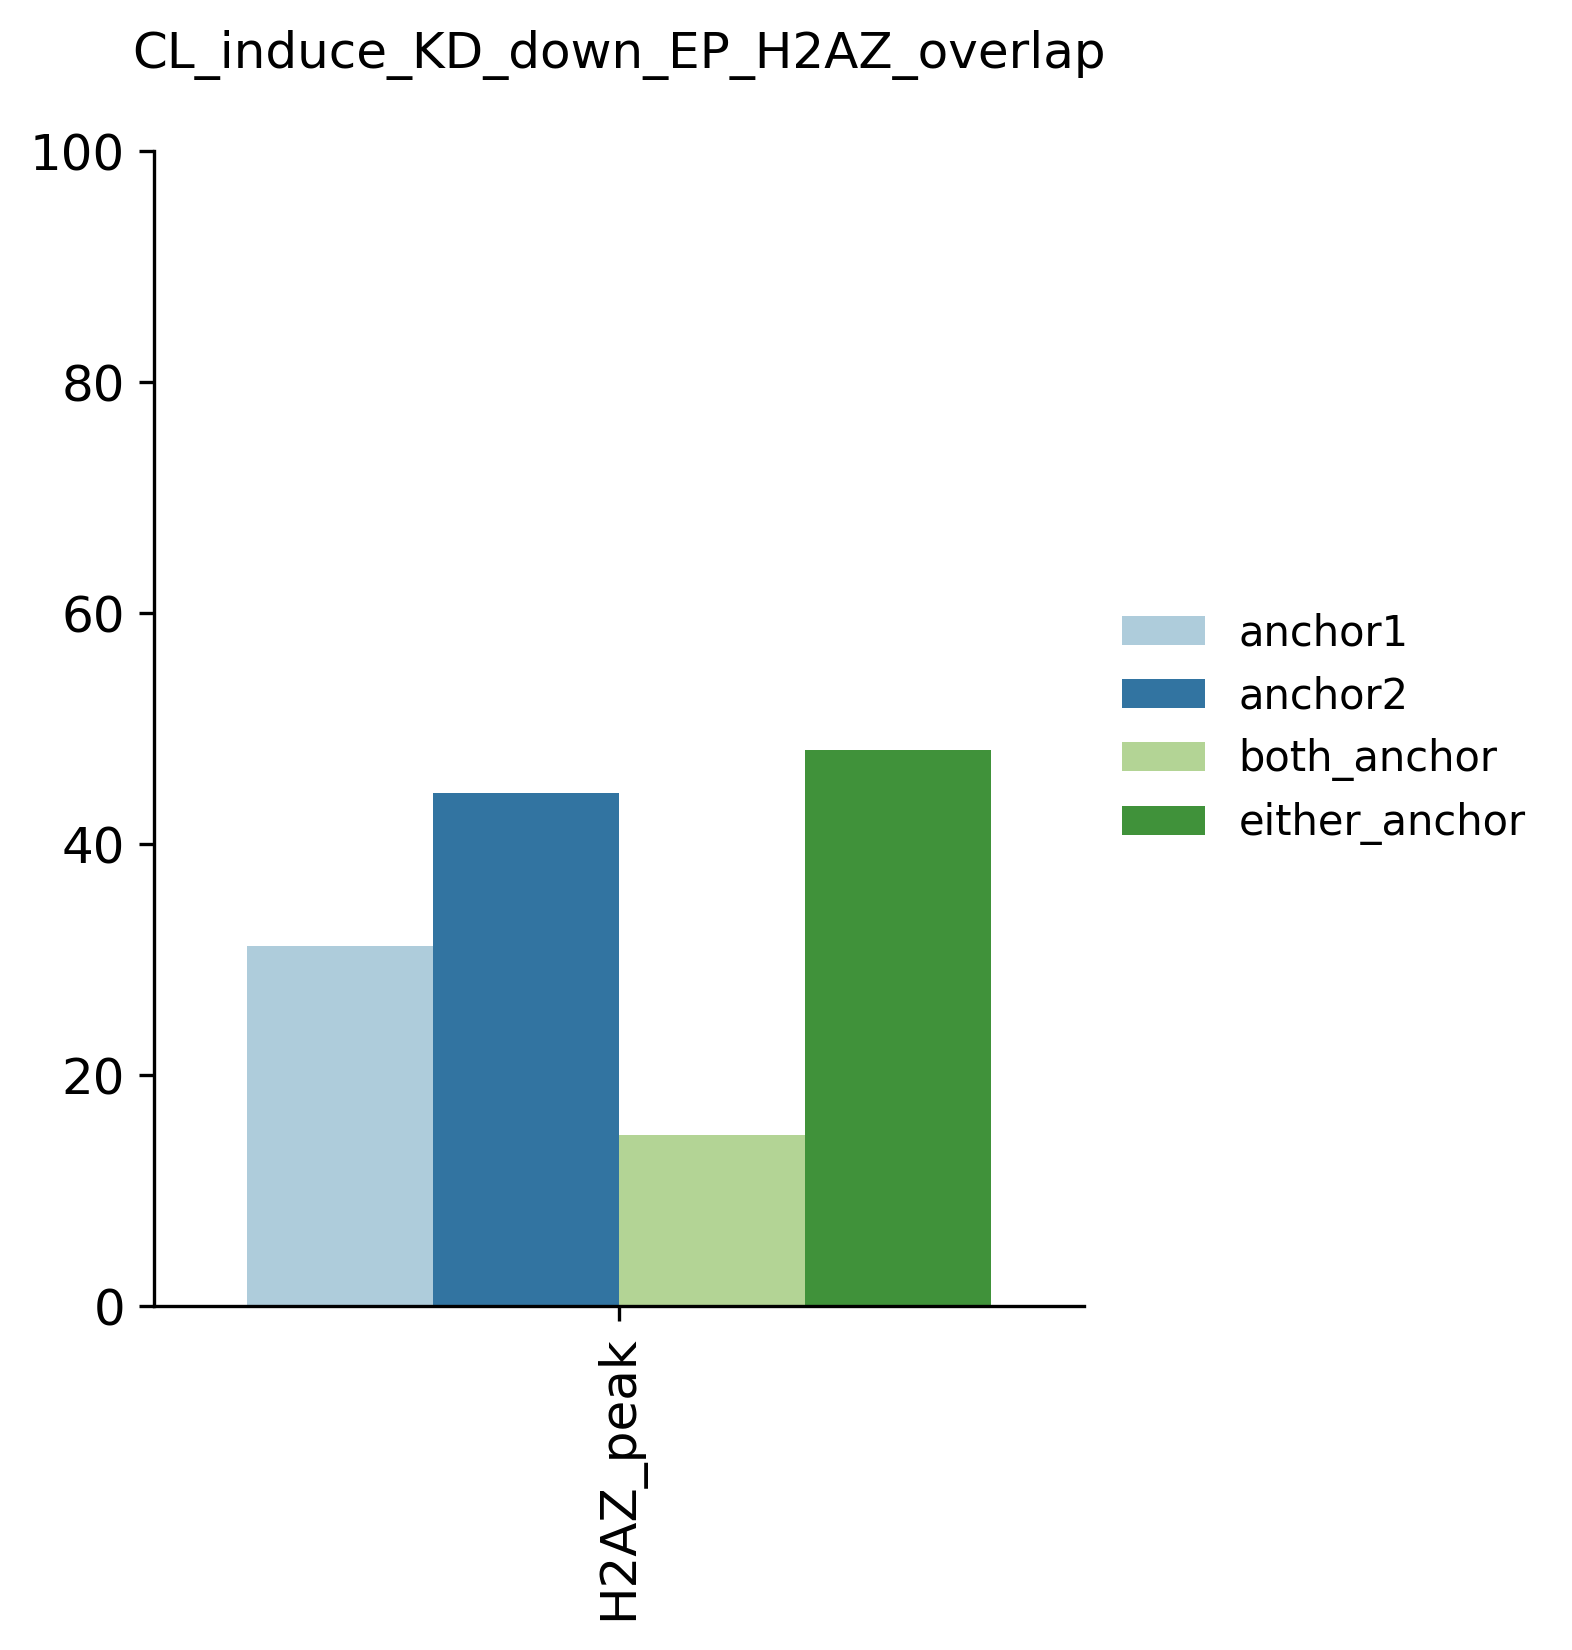

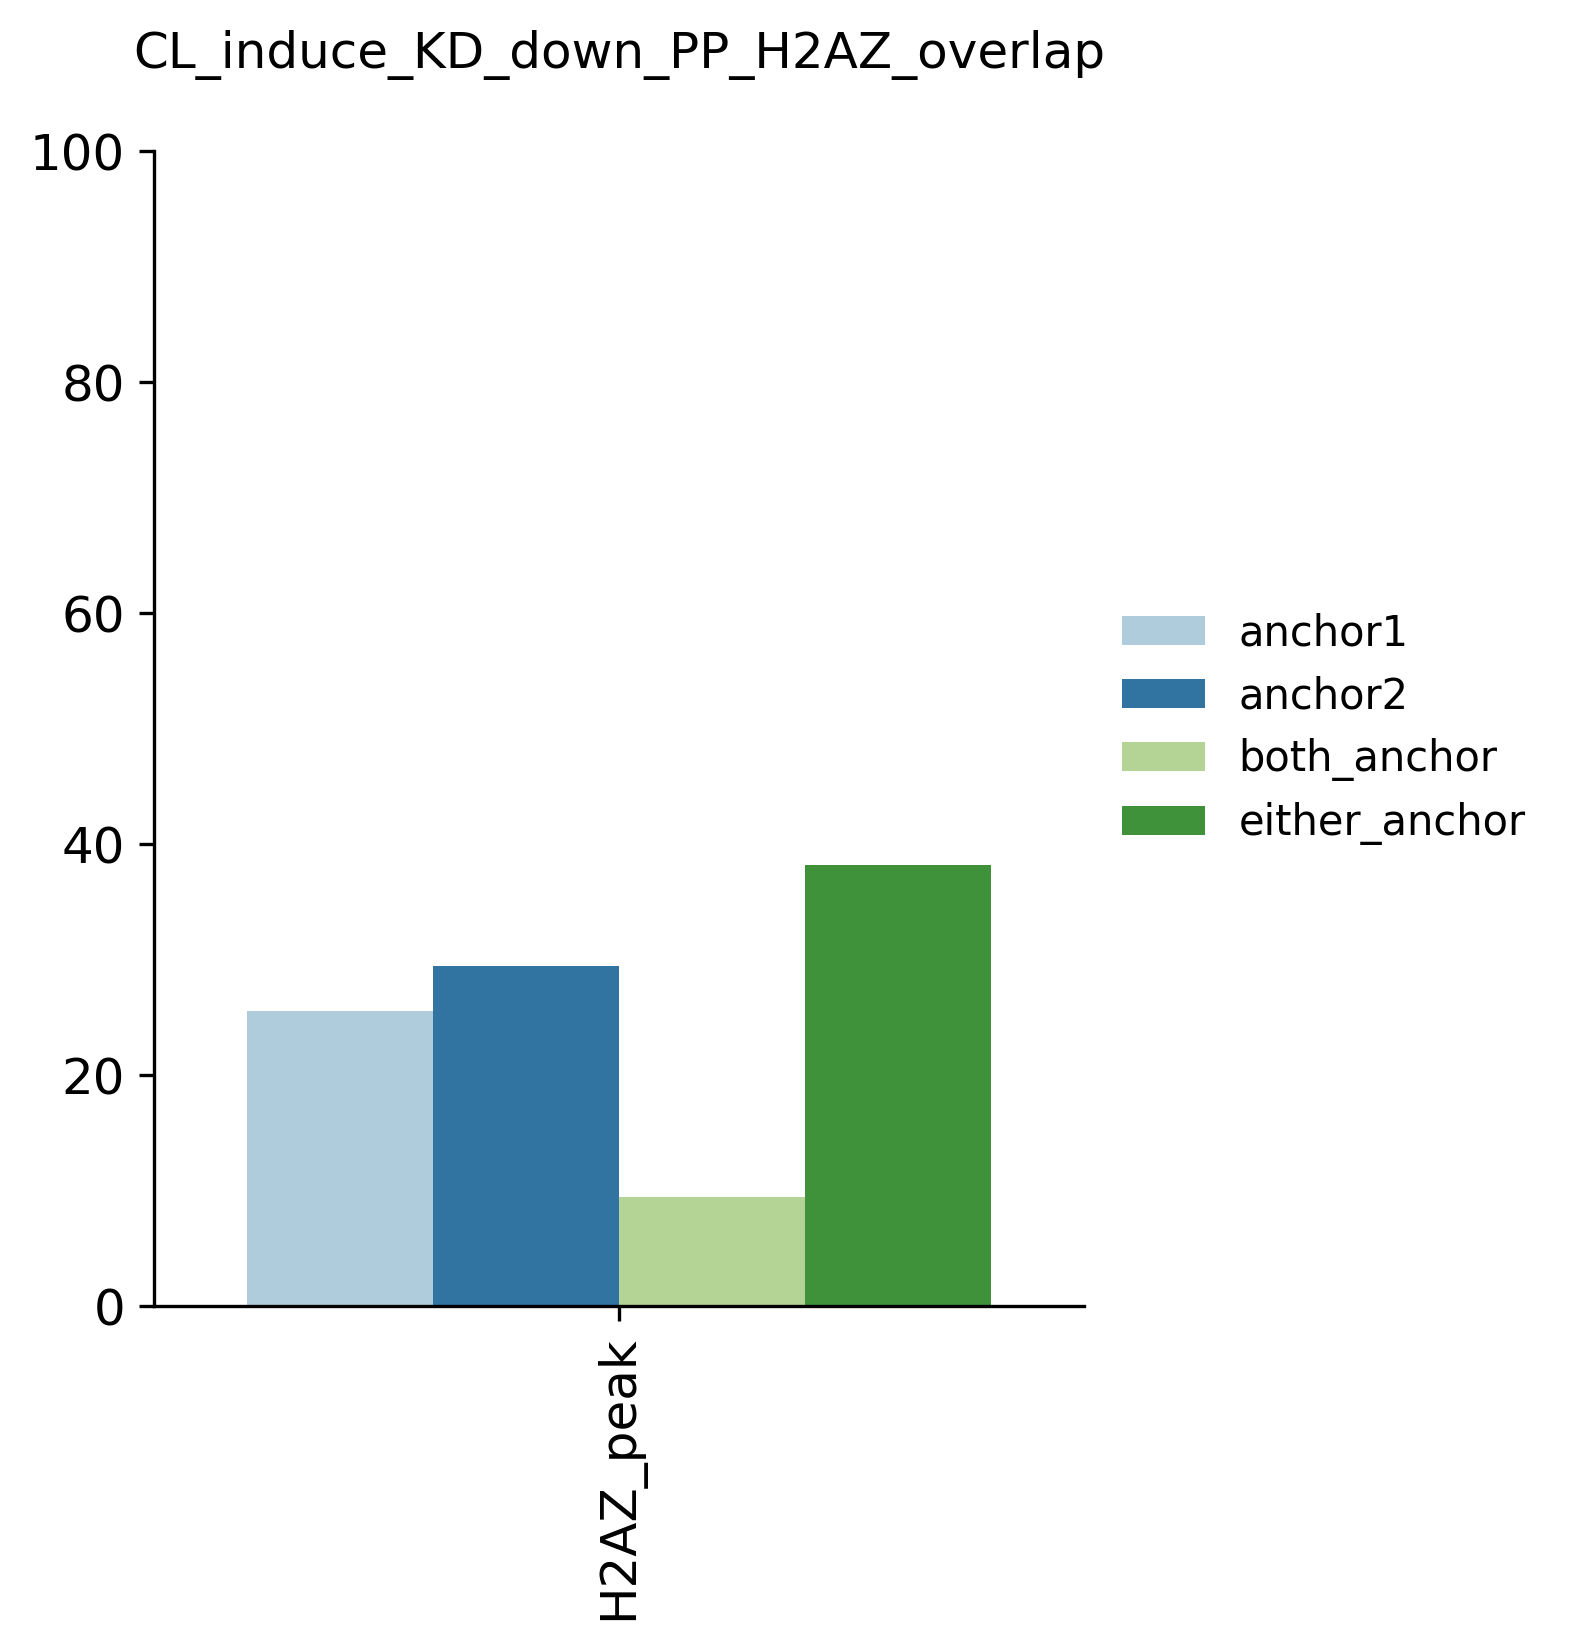

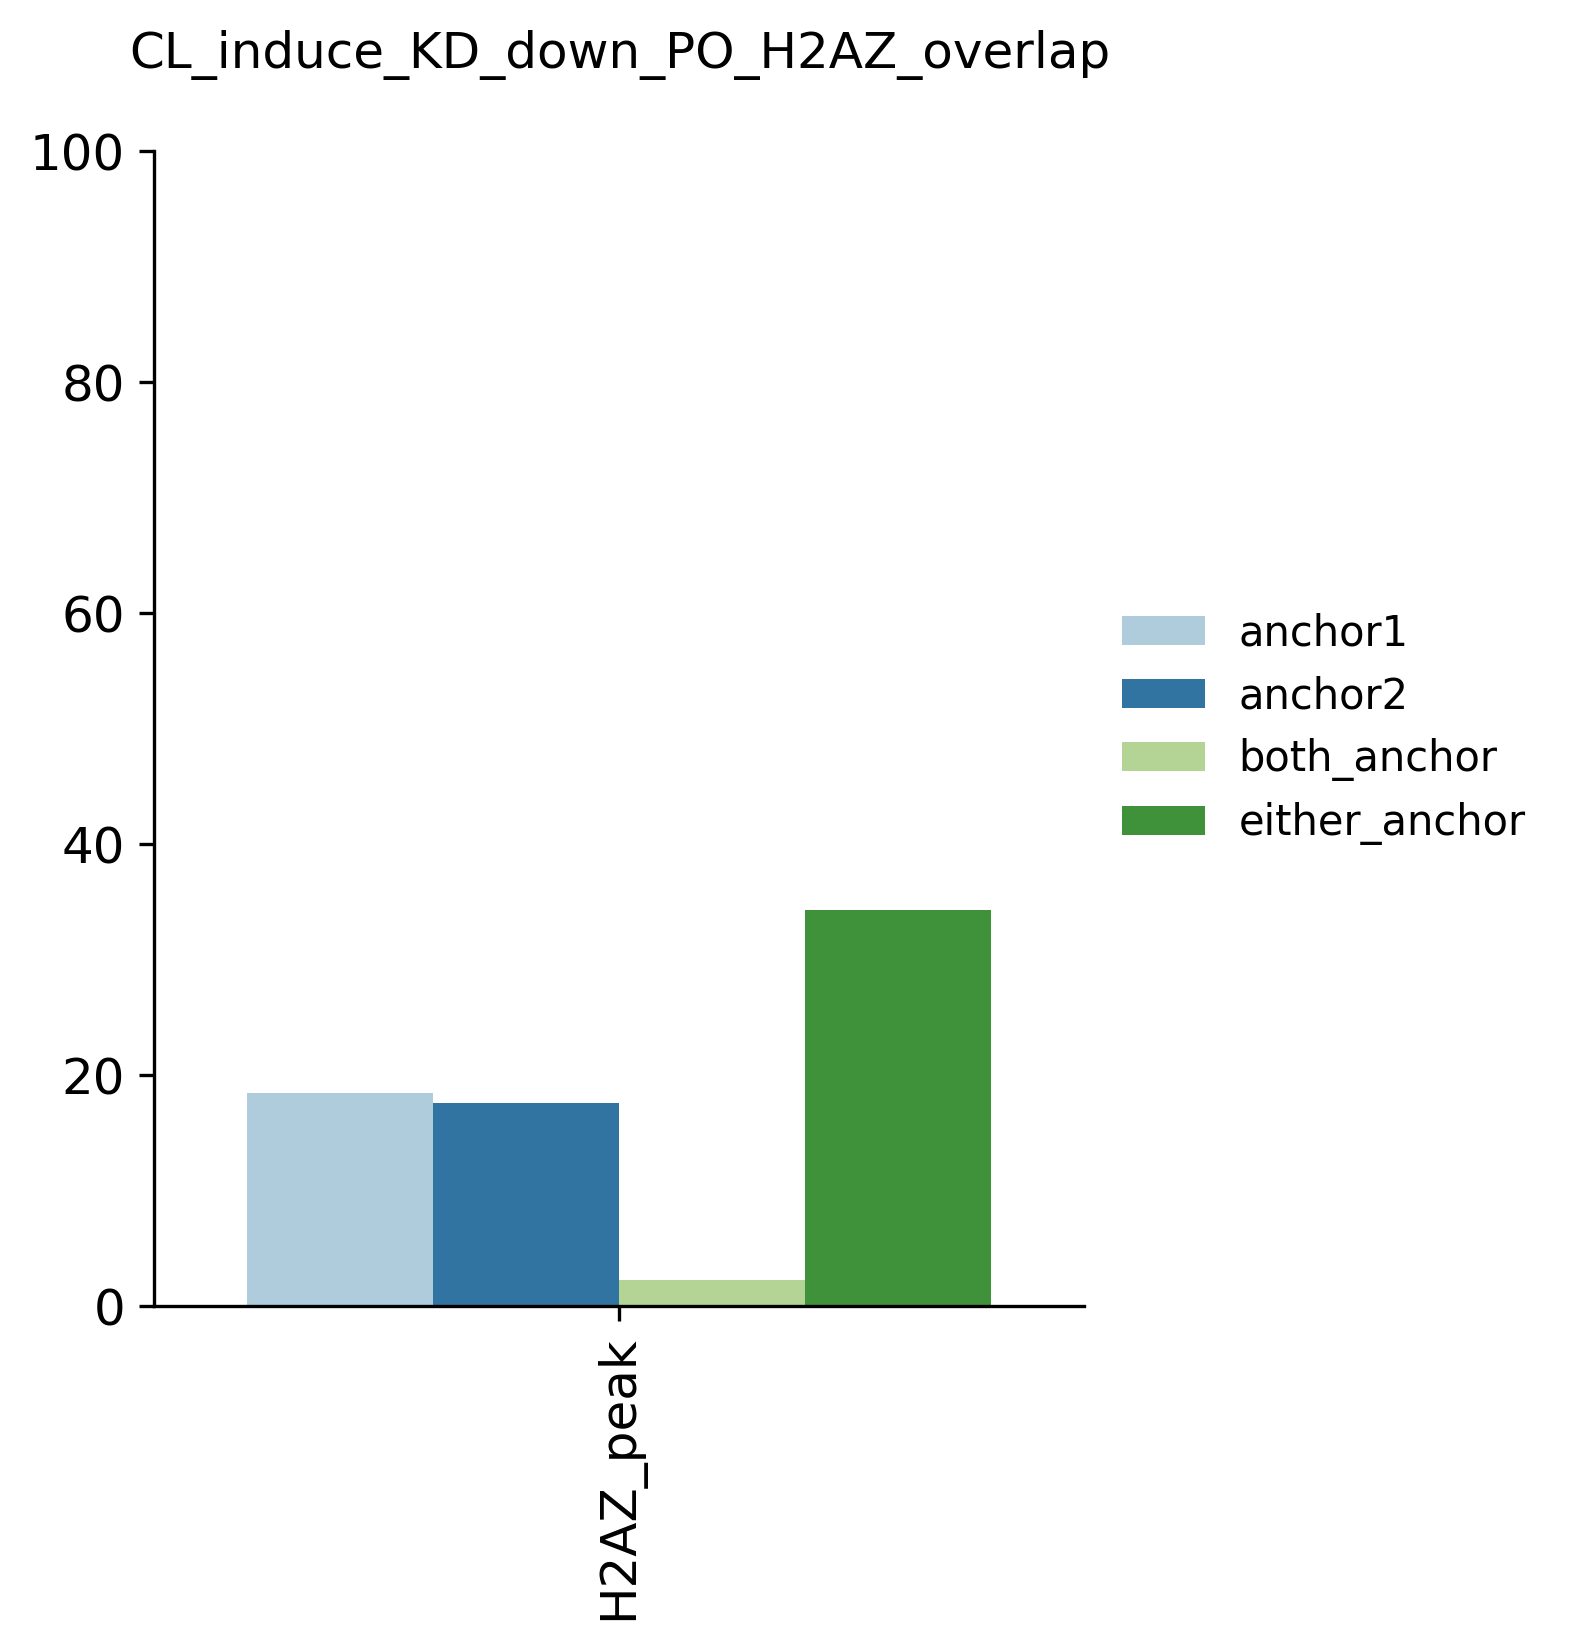

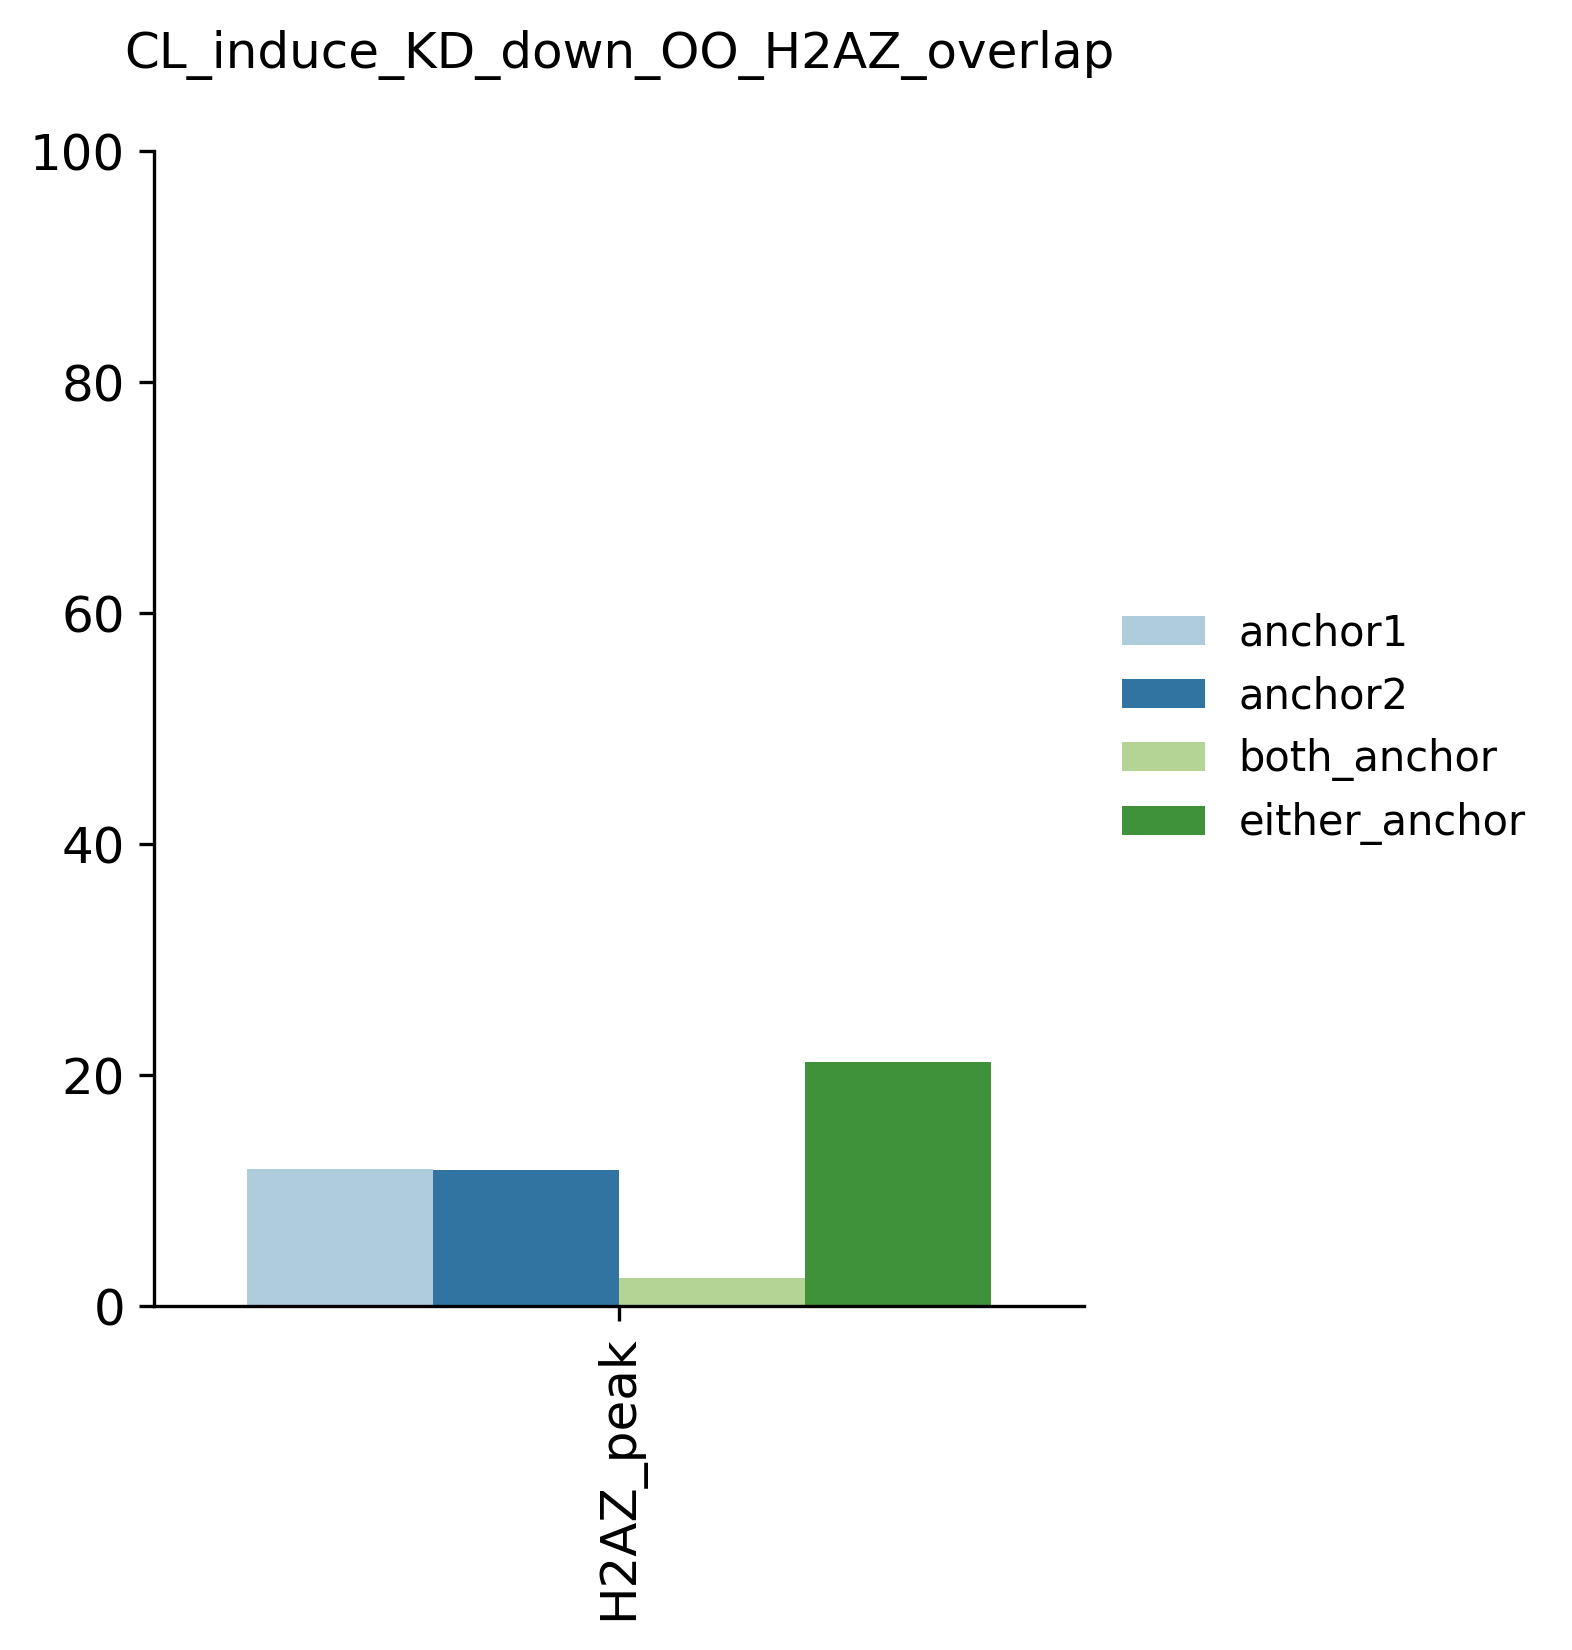

In [48]:
### identify H2A.Z occupied loops within H2AZ-dependant loops
EP_res = _plot_H2AZ_overlap_v2_(loops=CL_induce_KD_down_EP, peaks={'H2AZ_peak': H2AZ_plusCL_reprod_peaks_bed}, title = 'CL_induce_KD_down_EP_H2AZ_overlap',flip = True)
PP_res = _plot_H2AZ_overlap_v2_(loops=CL_induce_KD_down_PP, peaks={'H2AZ_peak': H2AZ_plusCL_reprod_peaks_bed}, title = 'CL_induce_KD_down_PP_H2AZ_overlap',flip = True)
PO_res = _plot_H2AZ_overlap_v2_(loops=CL_induce_KD_down_PO, peaks={'H2AZ_peak': H2AZ_plusCL_reprod_peaks_bed}, title = 'CL_induce_KD_down_PO_H2AZ_overlap',flip = True)
OO_res = _plot_H2AZ_overlap_v2_(loops=CL_induce_KD_down_OO, peaks={'H2AZ_peak': H2AZ_plusCL_reprod_peaks_bed}, title = 'CL_induce_KD_down_OO_H2AZ_overlap',flip = True)



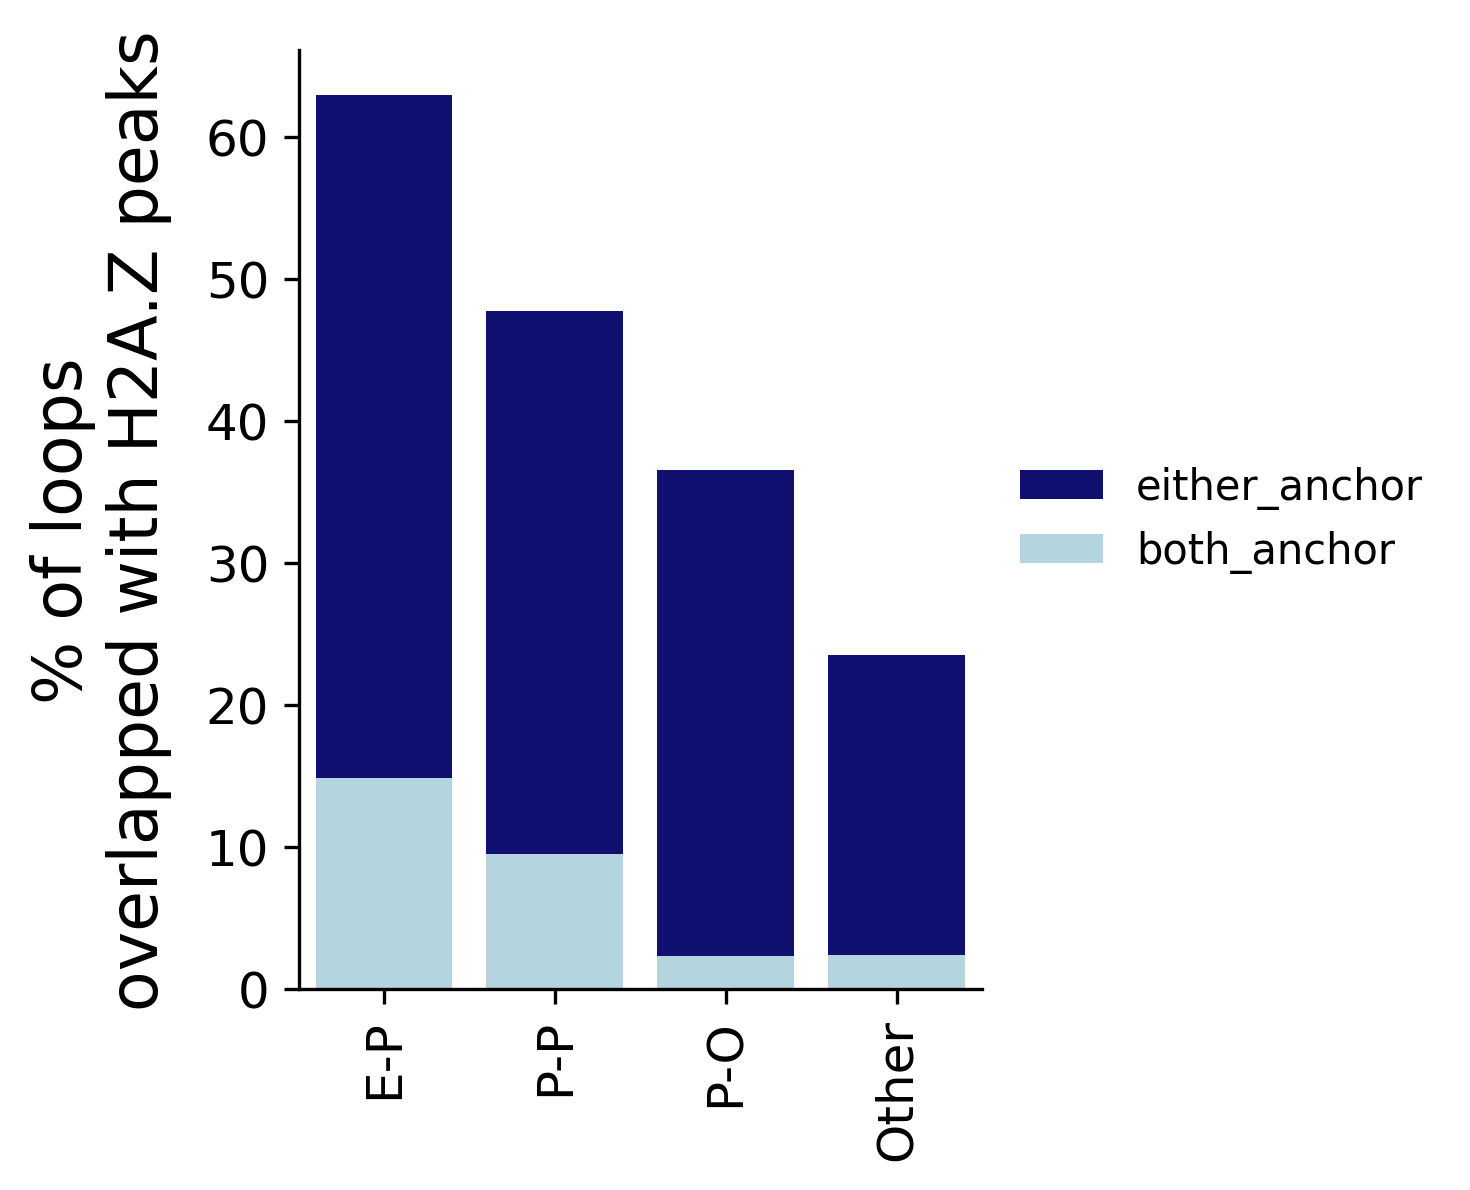

In [49]:
### stacked barplot showing H2AZ loop percentage

df = pd.DataFrame({'E-P':EP_res['H2AZ_peak'], 'P-P': PP_res['H2AZ_peak'], 'P-O':PO_res['H2AZ_peak'], 'Other': OO_res['H2AZ_peak']})
df1 = df.loc[['anchor1', 'anchor2', 'both_anchor', 'either_anchor']]*100/df.loc['total_loop']
df1 = df1.reset_index().melt(id_vars = ['index'])
df1 = df1[df1['index'].isin(['both_anchor', 'either_anchor'])]

fig, ax = plt.subplots(figsize = (5, 4))
sns.barplot(data = df1.groupby('variable').sum().reset_index(), 
            x = 'variable', y = 'value', color = 'navy', order = ['E-P', 'P-P', 'P-O', 'Other'],
           label = 'either_anchor')
sns.barplot(data = df1.query('index == "both_anchor"'), 
            x = 'variable', y = 'value', color = 'lightblue', order = ['E-P', 'P-P', 'P-O', 'Other'],
           label = 'both_anchor')
# ax.set_ylim(0, 100)
ax.tick_params(axis = 'x', rotation = 90)
# ax.tick_params(axis = 'x', rotation = 90)
ax.set(xlabel = '', ylabel = '% of loops \noverlapped with H2A.Z peaks')
ax.set_title(label = '', pad = 20)
#     ax.set_xlim(0, 45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon = False)
plt.tight_layout()
sns.despine()
# fig.savefig('CL_induce_H2AZ_down_percent_H2AZ_stacked.pdf')
plt.show()



In [63]:
## label loops with H2AZ binding status
both_anchor_loops = pd.DataFrame()
for t, r, l in [['EP', EP_res, CL_induce_KD_down_EP],
         ['PP', PP_res, CL_induce_KD_down_PP],
         ['PO', PO_res, CL_induce_KD_down_PO],
         ['OO', OO_res, CL_induce_KD_down_OO]]:
    both_anchor_loops = pd.concat([both_anchor_loops, 
                                   r['H2AZ_peak']['loops']['both']])
    
either_anchor_loops = pd.DataFrame()
for t, r, l in [['EP', EP_res, CL_induce_KD_down_EP],
         ['PP', PP_res, CL_induce_KD_down_PP],
         ['PO', PO_res, CL_induce_KD_down_PO],
         ['OO', OO_res, CL_induce_KD_down_OO]]:
    either_anchor_loops = pd.concat([either_anchor_loops, 
                                   r['H2AZ_peak']['loops']['either']])
    
    
H2AZ_status = []
for x in CL_induce_KD_down_tmp['label'].tolist():
    if x in both_anchor_loops['label'].tolist():
        H2AZ_status.append('both')
    elif x in either_anchor_loops['label'].tolist():
        H2AZ_status.append('either')
    else:
        H2AZ_status.append('unbound')

CL_induce_KD_down_tmp['H2AZ_status'] = H2AZ_status
CL_induce_KD_down_tmp['score_delta_KD_vs_shNT']=CL_induce_KD_down_tmp['score_KD_plusCL'] - CL_induce_KD_down_tmp['score_shNT_plusCL']
CL_induce_KD_down_tmp['score_delta_plusCL_vs_minusCL']=CL_induce_KD_down_tmp['score_shNT_plusCL'] - CL_induce_KD_down_tmp['score_shNT_minusCL']
CL_induce_KD_down_tmp['loop_length'] = CL_induce_KD_down_tmp['start2']-CL_induce_KD_down_tmp['start1']
CL_induce_KD_down_tmp['H2AZ_status_new'] = ['bound' if x != 'unbound' else x for x in CL_induce_KD_down_tmp['H2AZ_status'].tolist()]


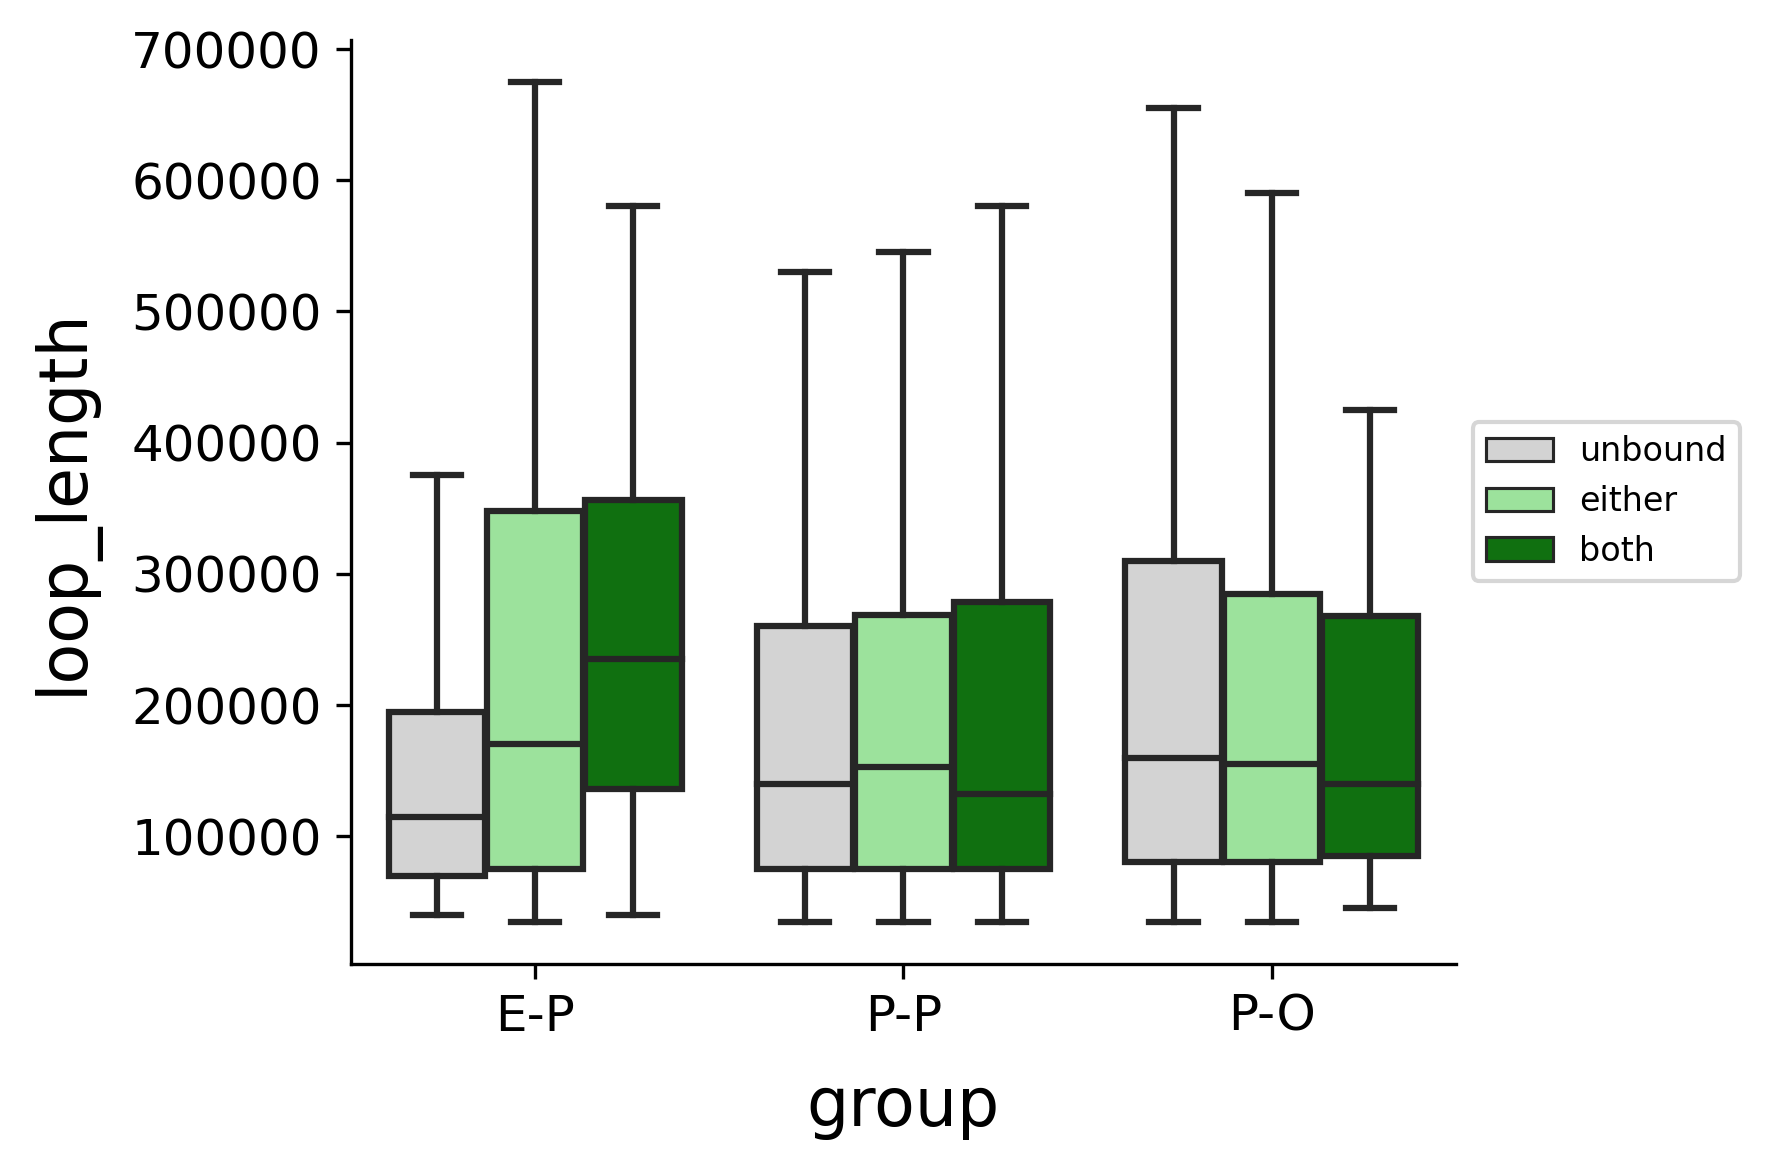

In [62]:
### boxplot showing the loop length of H2AZ-occupied loops

fig, ax = plt.subplots(figsize = (6, 4))
sns.boxplot(data = CL_induce_KD_down_tmp.query('group != "O-O"'), x = 'group', 
               y = 'loop_length', hue = 'H2AZ_status', showfliers = False,
            palette = {'unbound':'lightgrey', 'either': 'lightgreen', 'both':'green'}
           )
sns.despine()
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5), fontsize = 8)
plt.tight_layout()
fig.savefig('./Figures/loop_length_H2AZ_occupied.pdf')
plt.show()


/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


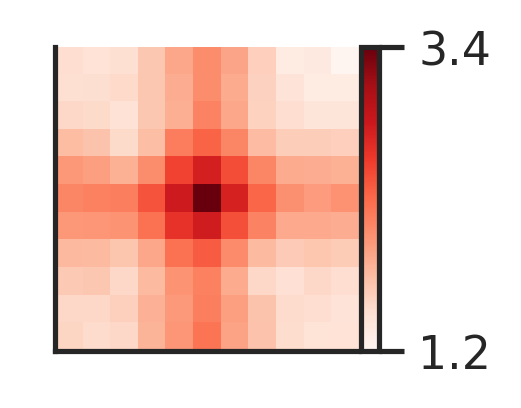

/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_a

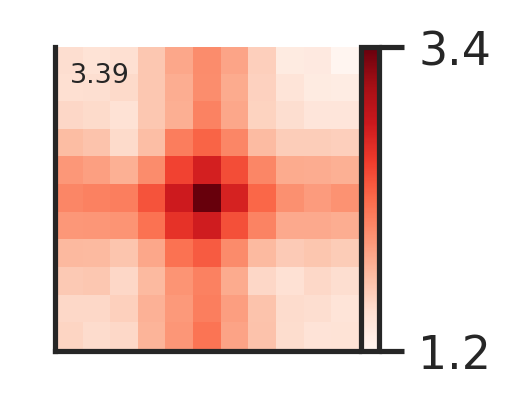

/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


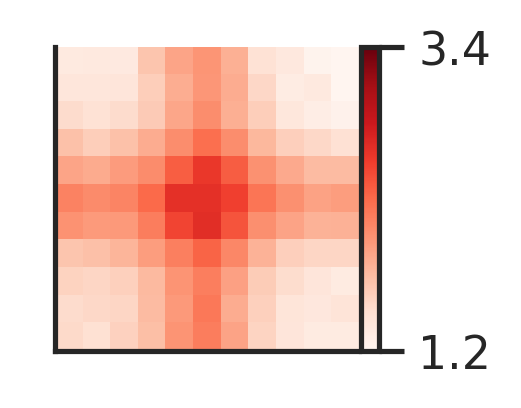

/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_a

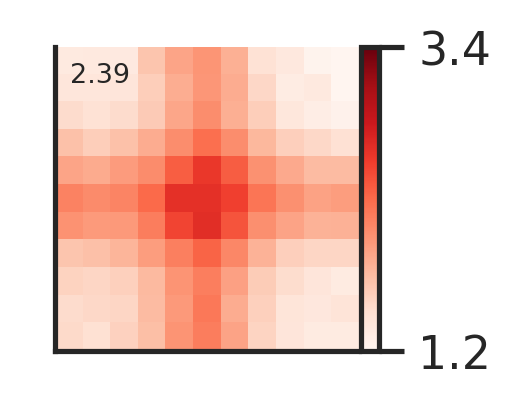

/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


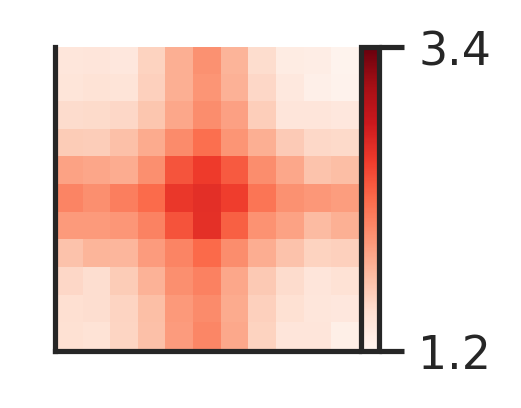

/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/lab-share/Cardio-Chen-e2/Public/rongbinzheng/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_a

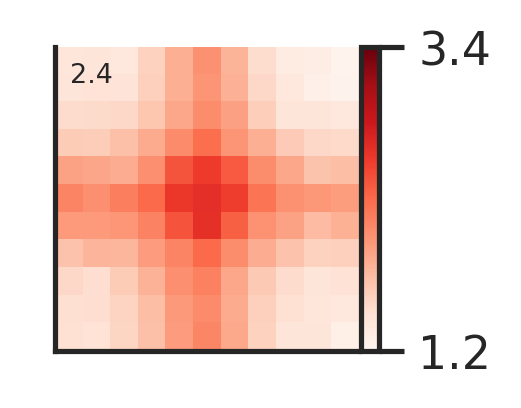

In [68]:
### APA for H2AZ occupied loops
H2AZ_occupied_loop = CL_induce_KD_down_tmp.query('H2AZ_status_new == "bound"').drop_duplicates('label')
### plusCL
pup1 = coolpup.pileup(clr1, H2AZ_occupied_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup1,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

plotpup.plot(pup1,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
#              vmax = 4, vmin = 1.3,
             height=1.5)
plt.show()

### minusCL
pup2 = coolpup.pileup(clr2, H2AZ_occupied_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup2,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.4, vmin = 1.2,
             height=1.5)
plt.show()

plotpup.plot(pup2,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.4, vmin = 1.2,
             height=1.5)
plt.show()


### H2AZ KD
pup3 = coolpup.pileup(clr3, H2AZ_occupied_loop,
                      features_format='bedpe', view_df=mm10_arms,
                      expected_df = expected3,
#                       rescale=True, rescale_flank=1, 
                        flank=50000, nproc=2, min_diag = 0)
plotpup.plot(pup3,
             score=False,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.4, vmin = 1.2,
             height=1.5)
plt.show()

plotpup.plot(pup3,
             score=True,
             center = 1,
             cmap='Reds',
             sym=False, #scale='log', 
             vmax = 3.4, vmin = 1.2,
             height=1.5)
plt.show()



### Integrate ATAC-seq data with H2AZ and loops

In [5]:
## ATAC-seq path
ATAC_path = {'shNT_minusCL_rep2':'../ATAC/danpos/e200/shNT_minusCL_rep2/pooled/bam_shNT_minusCL_rep2_unique.sorted.bam.dedup.Fnor.peaks.xls',
            'shNT_minusCL_rep3':'../ATAC/danpos/e200/shNT_minusCL_rep3/pooled/bam_shNT_minusCL_rep3_unique.sorted.bam.dedup.Fnor.peaks.xls',
            'shNT_plusCL_rep2':'../ATAC/danpos/e200/shNT_plusCL_rep2/pooled/bam_shNT_plusCL_rep2_unique.sorted.bam.dedup.Fnor.peaks.xls',
            'shNT_plusCL_rep3':'../ATAC/danpos/e200/shNT_plusCL_rep3/pooled/bam_shNT_plusCL_rep3_unique.sorted.bam.dedup.Fnor.peaks.xls',
            'KD_plusCL_rep2':'../ATAC/danpos/e200/KD_plusCL_rep2/pooled/bam_KD_plusCL_rep2_unique.sorted.bam.dedup.Fnor.peaks.xls',
            'KD_plusCL_rep3':'../ATAC/danpos/e200/KD_plusCL_rep3/pooled/bam_KD_plusCL_rep3_unique.sorted.bam.dedup.Fnor.peaks.xls',
            }

ATAC_peaks = {}
for x in ATAC_path:
    tmp = pd.read_csv(ATAC_path[x], sep = '\t')
    ATAC_peaks[x] = pybedtools.BedTool.from_dataframe(tmp)
## reproduciable peaks in two replicates
ATAC_peaks_reprod =  {'shNT_minusCL':ATAC_peaks['shNT_minusCL_rep2'].intersect(ATAC_peaks['shNT_minusCL_rep3'], wa=True).to_dataframe().drop_duplicates(),
                      'shNT_plusCL':ATAC_peaks['shNT_plusCL_rep2'].intersect(ATAC_peaks['shNT_plusCL_rep3'], wa=True).to_dataframe().drop_duplicates(),
                      'KD_plusCL':ATAC_peaks['KD_plusCL_rep2'].intersect(ATAC_peaks['KD_plusCL_rep3'], wa=True).to_dataframe().drop_duplicates()}

ATAC_peaks_reprod_bed =  {x:pybedtools.BedTool.from_dataframe(ATAC_peaks_reprod[x]) for x in ATAC_peaks_reprod}


bw_path_list = {#'shNT_minusCL_rep1':'../ATAC/bw/shNT_minusCL_rep1.rep1_treat_pileup.bw',
            'shNT_minusCL_rep2':'../ATAC/bw/shNT_minusCL_rep2.rep1_treat_pileup.bw',
            'shNT_minusCL_rep3':'../ATAC/bw/shNT_minusCL_rep3.rep1_treat_pileup.bw',
            #'shNT_plusCL_rep1':'../ATAC/bw/shNT_plusCL_rep1.rep1_treat_pileup.bw',
            'shNT_plusCL_rep2':'../ATAC/bw/shNT_plusCL_rep2.rep1_treat_pileup.bw',
            'shNT_plusCL_rep3':'../ATAC/bw/shNT_plusCL_rep3.rep1_treat_pileup.bw',
            #'KD_plusCL_rep1':'../ATAC/bw/KD_plusCL_rep1.rep1_treat_pileup.bw',
            'KD_plusCL_rep2':'../ATAC/bw/KD_plusCL_rep2.rep1_treat_pileup.bw',
            'KD_plusCL_rep3':'../ATAC/bw/KD_plusCL_rep3.rep1_treat_pileup.bw',
            }


In [6]:
out = open('loop_set.pk', 'rb')
d = pk.load(out)
out.close()

union_loops= d['union_loops']
union_loops_genes = d['union_loops_genes']
up_loop = d['up_loop']
down_loop = d['down_loop']
up_loop_union = d['up_loop_union']
CL_induce_KD_down = d['CL_induce_KD_down']
CL_induce_KD_down_tmp = d['CL_induce_KD_down_tmp']
KD_down_loop = d['KD_down_loop']
shNT_plusCL_allLoop = d['shNT_plusCL_allLoop']
EP_res=d['EP_res']
PP_res=d['PP_res']
PO_res=d['PO_res']
OO_res=d['OO_res']
CL_induce_KD_down_EP=d['CL_induce_KD_down_EP']
CL_induce_KD_down_PP=d['CL_induce_KD_down_PP']
CL_induce_KD_down_PO=d['CL_induce_KD_down_PO']
CL_induce_KD_down_OO=d['CL_induce_KD_down_OO']
        

['11390', '28780', '44241']


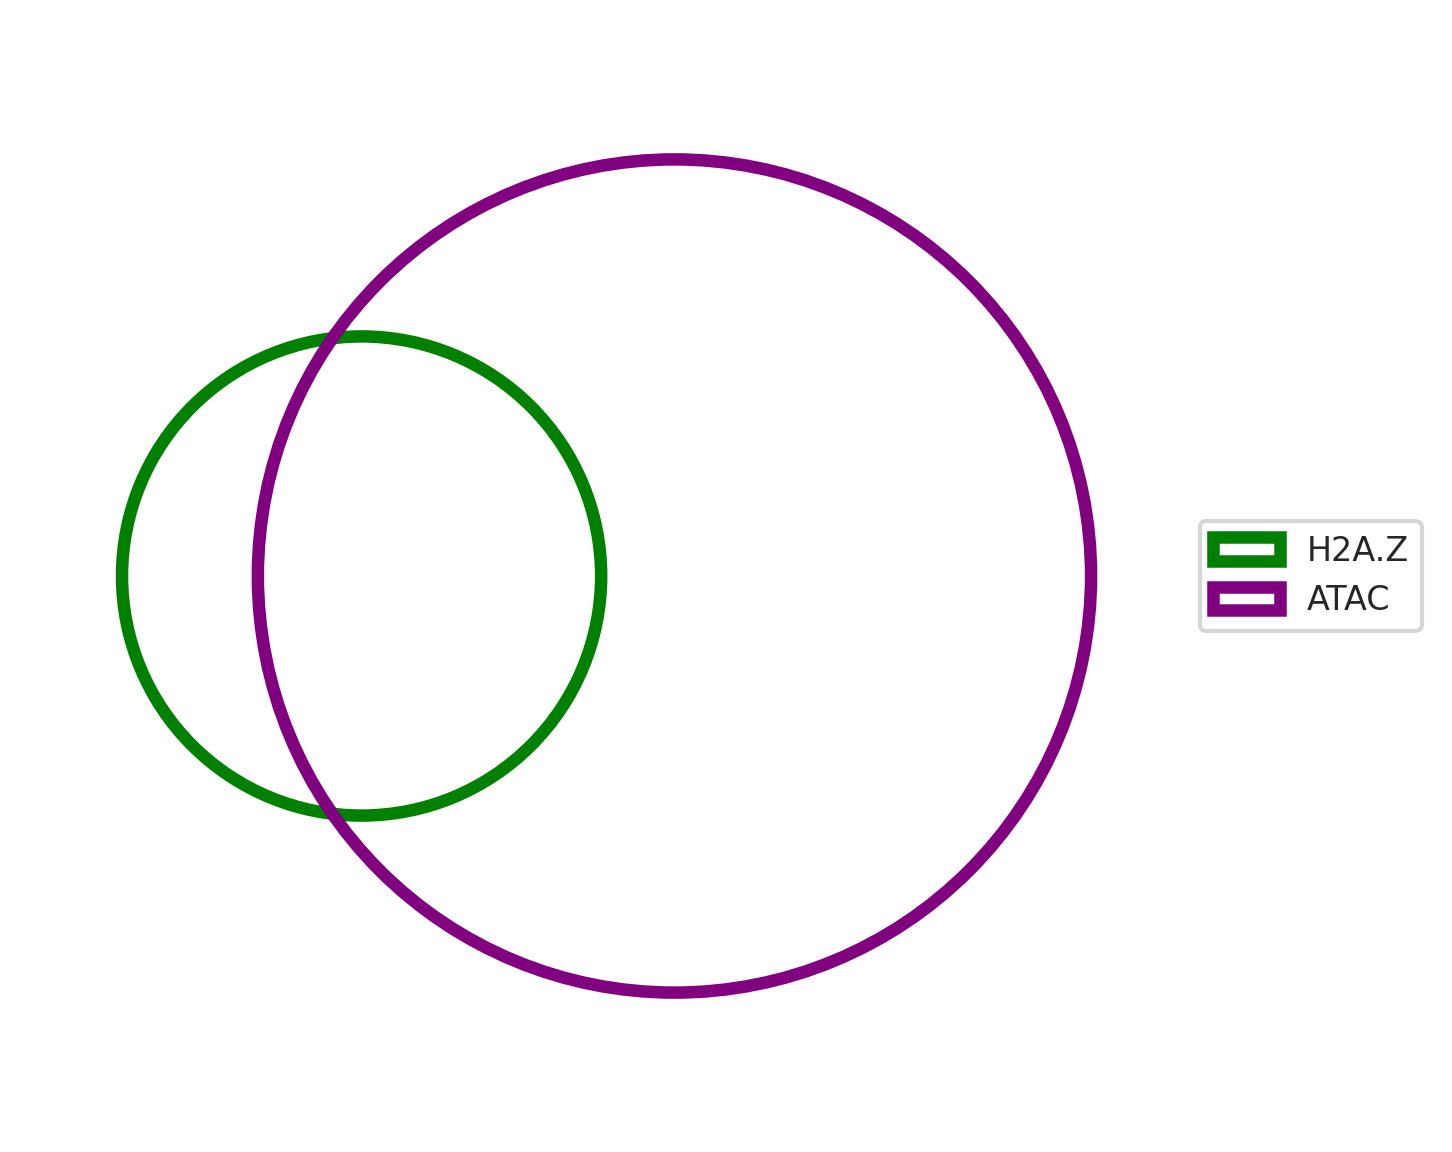

['2805', '9454', '12718']


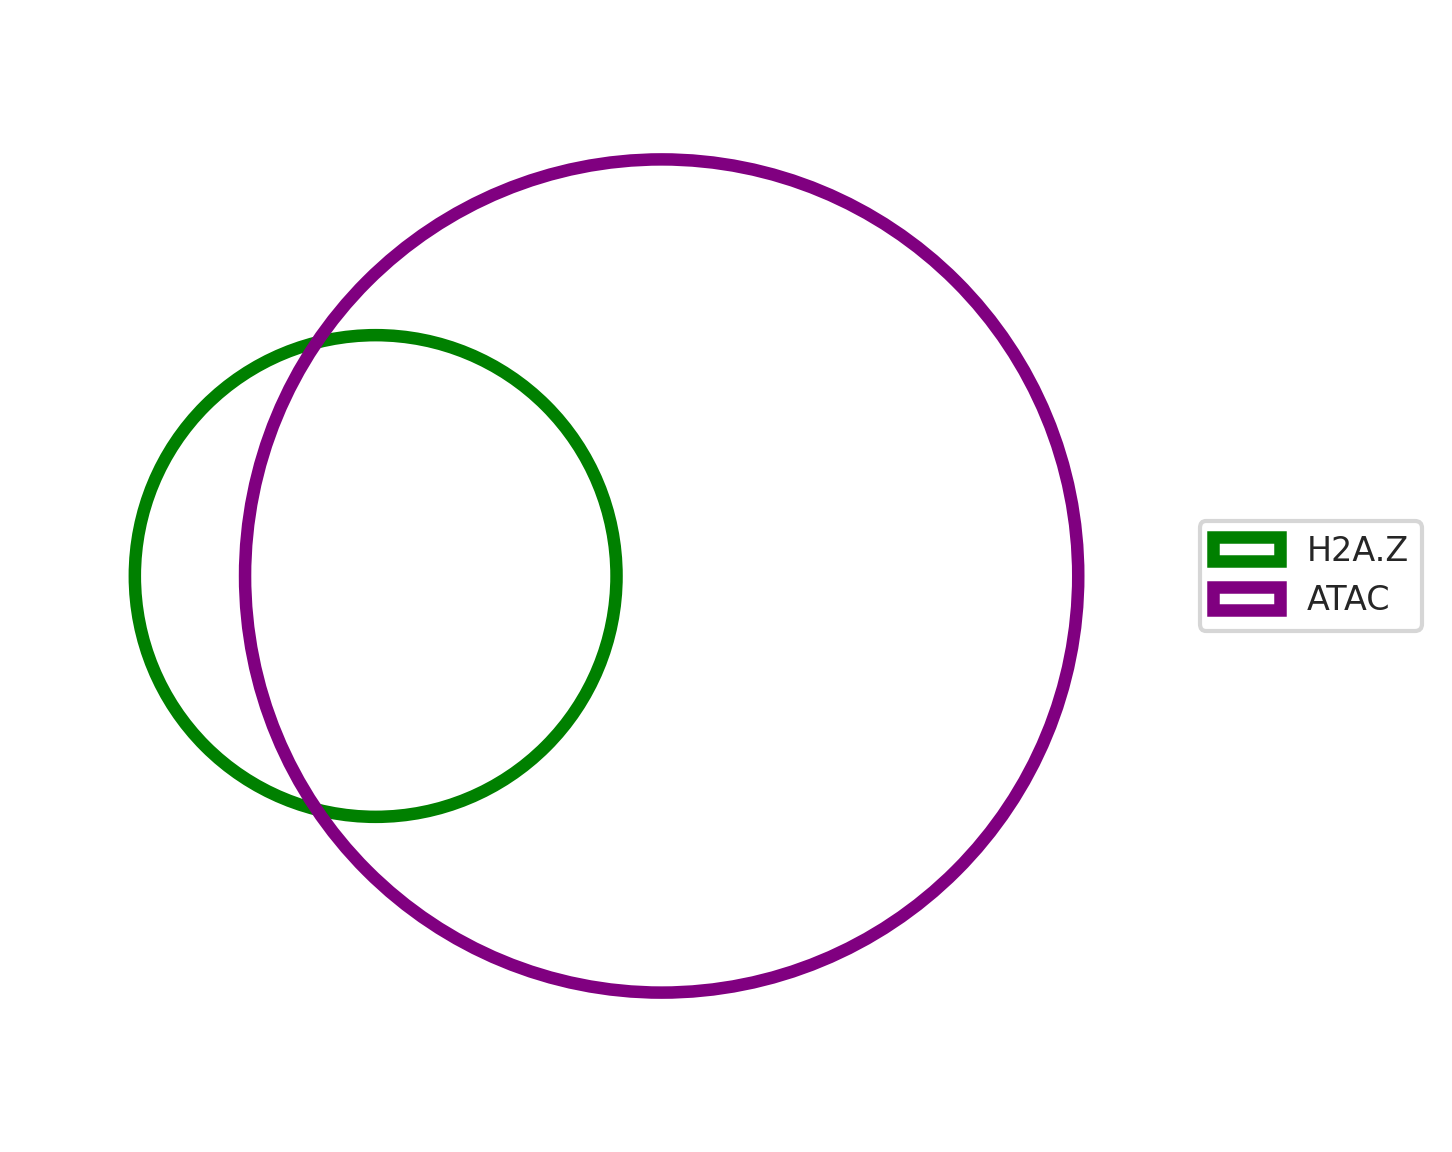

In [71]:
### venn diagram for ATAC total peaks and H2AZ total peaks
venn_mpl(a=H2AZ_plusCL_reprod_peaks_bed, b=ATAC_peaks_reprod_bed['shNT_plusCL'], colors=['green', 'purple'], 
             outfn='Figures/H2AZ_ATAC_peak_venn_shNT_plusCL.pdf', labels=['H2A.Z', 'ATAC'],text=False,
             dpi=300, figsize = (5, 4))

### venn diagram for ATAC peaks and H2AZ peaks in plucCL loops
anchors = shNT_plusCL_allLoop[['chrom1', 'start1', 'end1']].values.tolist()+shNT_plusCL_allLoop[['chrom2', 'start2', 'end2']].values.tolist()
anchors = pd.DataFrame(anchors, columns = ['chrom', 'start', 'end']).drop_duplicates()
anchor_bed = pybedtools.BedTool.from_dataframe(anchors)

H2AZ_plusCL_in_loop = H2AZ_plusCL_reprod_peaks_bed.intersect(anchor_bed, wa = True)
ATAC_plusCL_in_loop = ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(anchor_bed, wa = True)

venn_mpl(a=H2AZ_plusCL_in_loop, b=ATAC_plusCL_in_loop, colors=['green', 'purple'], 
             outfn='Figures/H2AZ_ATAC_peak_venn_shNT_plusCL_loop.pdf', labels=['H2A.Z', 'ATAC'],text=False,
             dpi=300, figsize = (5, 4))



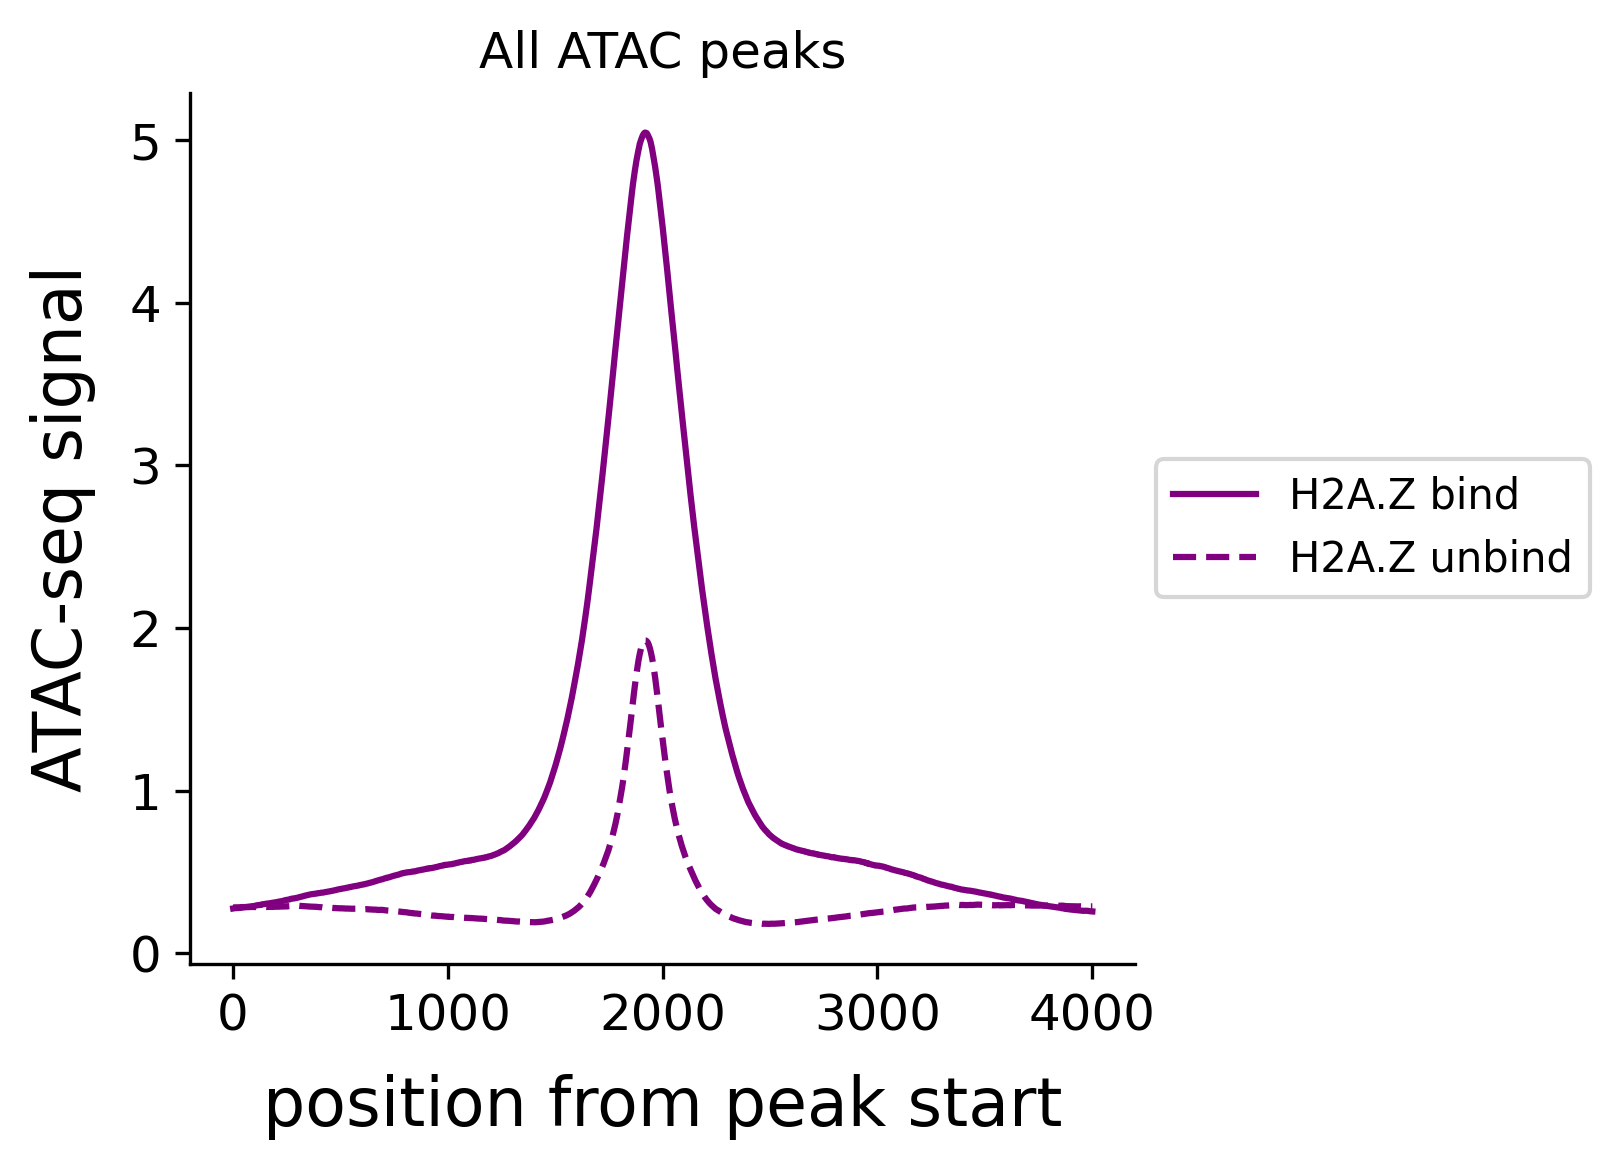

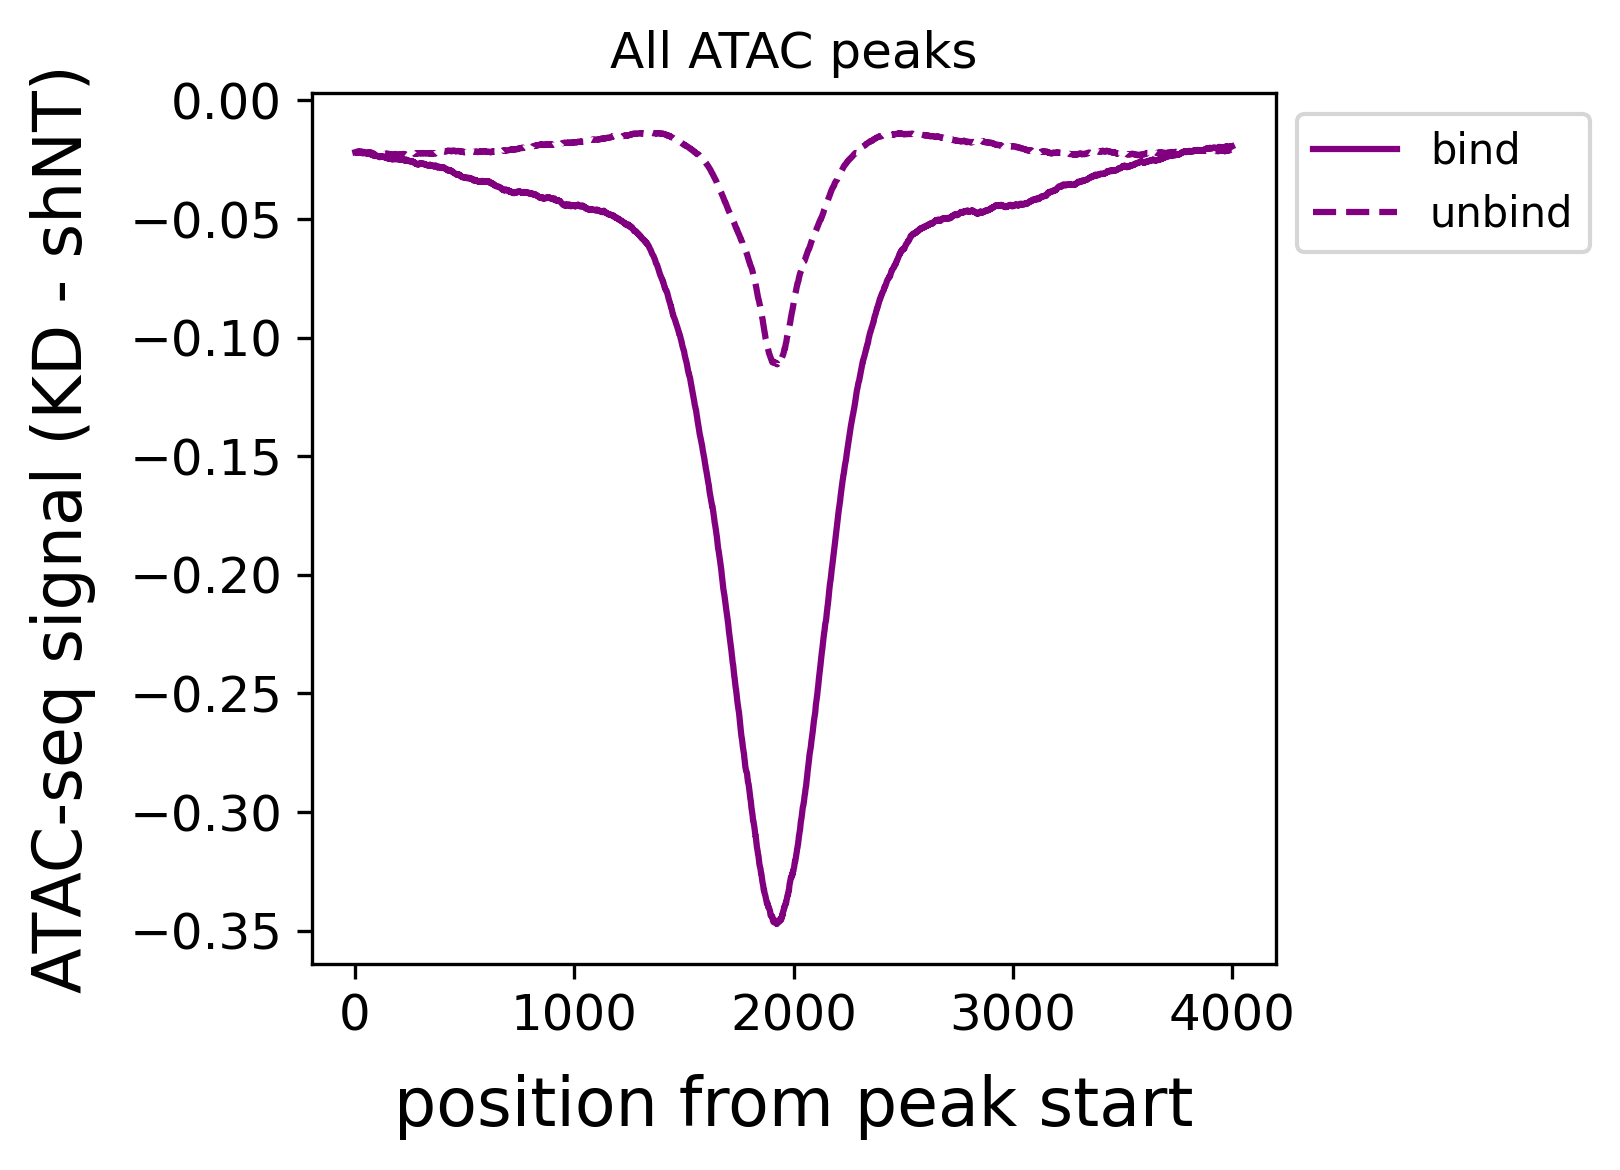

In [7]:
### signal of ATAC-seq in H2AZ peak overlapped peaks and non-overlapped peaks - all peaks
ATAC_withH2AZ =ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(H2AZ_plusCL_reprod_peaks_bed, wa = True).to_dataframe().drop_duplicates()
ATAC_noH2AZ = ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(H2AZ_plusCL_reprod_peaks_bed, v=True, wa = True).to_dataframe().drop_duplicates()

bw_value2 = {'bind':[],'unbind':[]}
d = 2000
bw = pyBigWig.open(bw_path_list['shNT_plusCL_rep2'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['unbind'].append(bw.values(c, center-d, center+d))

bw_value3 = {'bind':[],'unbind':[]}
bw = pyBigWig.open(bw_path_list['shNT_plusCL_rep3'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['unbind'].append(bw.values(c, center-d, center+d))
shNT_bind = np.array(bw_value2['bind']+bw_value3['bind']).mean(axis = 0)
shNT_unbind = np.array(bw_value2['unbind']+bw_value3['unbind']).mean(axis = 0)

    
bw_value2 = {'bind':[],'unbind':[]}
d = 2000
bw = pyBigWig.open(bw_path_list['KD_plusCL_rep2'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['unbind'].append(bw.values(c, center-d, center+d))

bw_value3 = {'bind':[],'unbind':[]}
bw = pyBigWig.open(bw_path_list['KD_plusCL_rep3'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['unbind'].append(bw.values(c, center-d, center+d))
KD_bind = np.array(bw_value2['bind']+bw_value3['bind']).mean(axis = 0)
KD_unbind = np.array(bw_value2['unbind']+bw_value3['unbind']).mean(axis = 0)

fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), shNT_bind, label = 'H2A.Z bind', color = 'purple')
ax.plot(range(1,4001), shNT_unbind, label = 'H2A.Z unbind', color = 'purple', linestyle = 'dashed')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'position from peak start', ylabel = 'ATAC-seq signal',
      title = 'All ATAC peaks')
plt.tight_layout()
sns.despine()
fig.savefig('Figures/ATAC_signal_H2AZ_bind_vs_unbind_plusCL.pdf')
plt.show()
plt.close()


### delta ATAC-seq signal
df_KD_shNT_bind = KD_bind - shNT_bind
df_KD_shNT_unbind = KD_unbind - shNT_unbind

fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), df_KD_shNT_bind, label = 'bind', color = 'purple')
ax.plot(range(1,4001), df_KD_shNT_unbind, label = 'unbind', color = 'purple', linestyle = 'dashed')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_ylim(0, 5.5)
ax.set(xlabel = 'position from peak start', ylabel = 'ATAC-seq signal (KD - shNT)',
      title = 'All ATAC peaks')
plt.tight_layout()
fig.savefig('Figures/ATAC_all_peak_KD_delta_signal_curve_H2AZ_bind_vs_unbind.pdf')
plt.show()
plt.close()


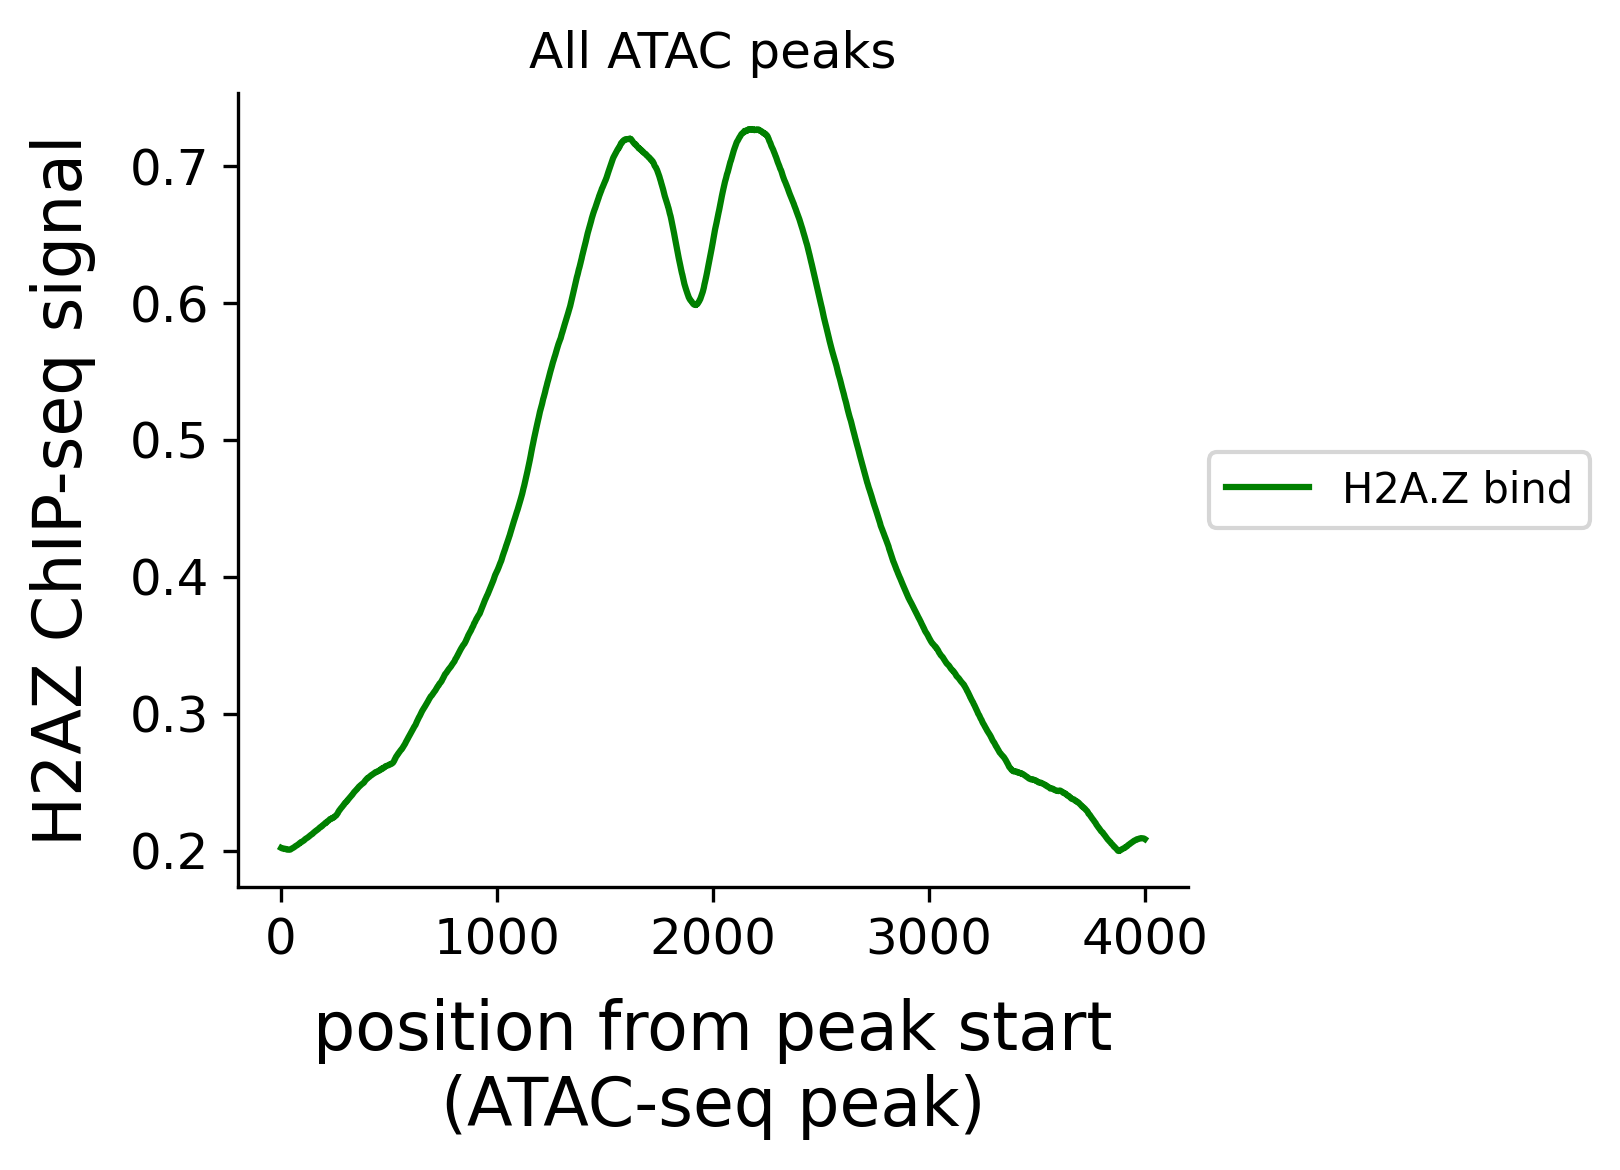

In [19]:
# ## H2AZ signal of ATAC-seq peak aligned - all peaks
# ATAC_withH2AZ =ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(H2AZ_plusCL_reprod_peaks_bed, wa = True).to_dataframe().drop_duplicates()
# ATAC_noH2AZ = ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(H2AZ_plusCL_reprod_peaks_bed, v=True, wa = True).to_dataframe().drop_duplicates()

# H2AZ_bw_value1 = {'bind':[]}
# d = 2000
# bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep1'])
# for i, line in ATAC_withH2AZ.iterrows():
#     c, s, e = line['chrom'], line['start'], line['end']
#     center = s+int((np.abs(s-e)/2))
#     H2AZ_bw_value1['bind'].append(bw.values(c, center-d, center+d))

# H2AZ_bw_value2 = {'bind':[]}
# bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep2'])
# for i, line in ATAC_withH2AZ.iterrows():
#     c, s, e = line['chrom'], line['start'], line['end']
#     center = s+int((np.abs(s-e)/2))
#     H2AZ_bw_value2['bind'].append(bw.values(c, center-d, center+d))

# H2AZ_bw_value3 = {'bind':[]}
# bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep3'])
# for i, line in ATAC_withH2AZ.iterrows():
#     c, s, e = line['chrom'], line['start'], line['end']
#     center = s+int((np.abs(s-e)/2))
#     H2AZ_bw_value3['bind'].append(bw.values(c, center-d, center+d))

# hbv_all = np.array(H2AZ_bw_value1['bind']+H2AZ_bw_value2['bind']+H2AZ_bw_value3['bind']).mean(axis = 0)


fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), hbv_all, label = 'H2A.Z bind', color = 'green')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'position from peak start\n(ATAC-seq peak)', ylabel = 'H2AZ ChIP-seq signal',
      title = 'All ATAC peaks')
plt.tight_layout()
sns.despine()
fig.savefig('Figures/H2AZ_signal_H2AZ_bind_ATAC_peaks_plusCL.pdf')
plt.show()
plt.close()


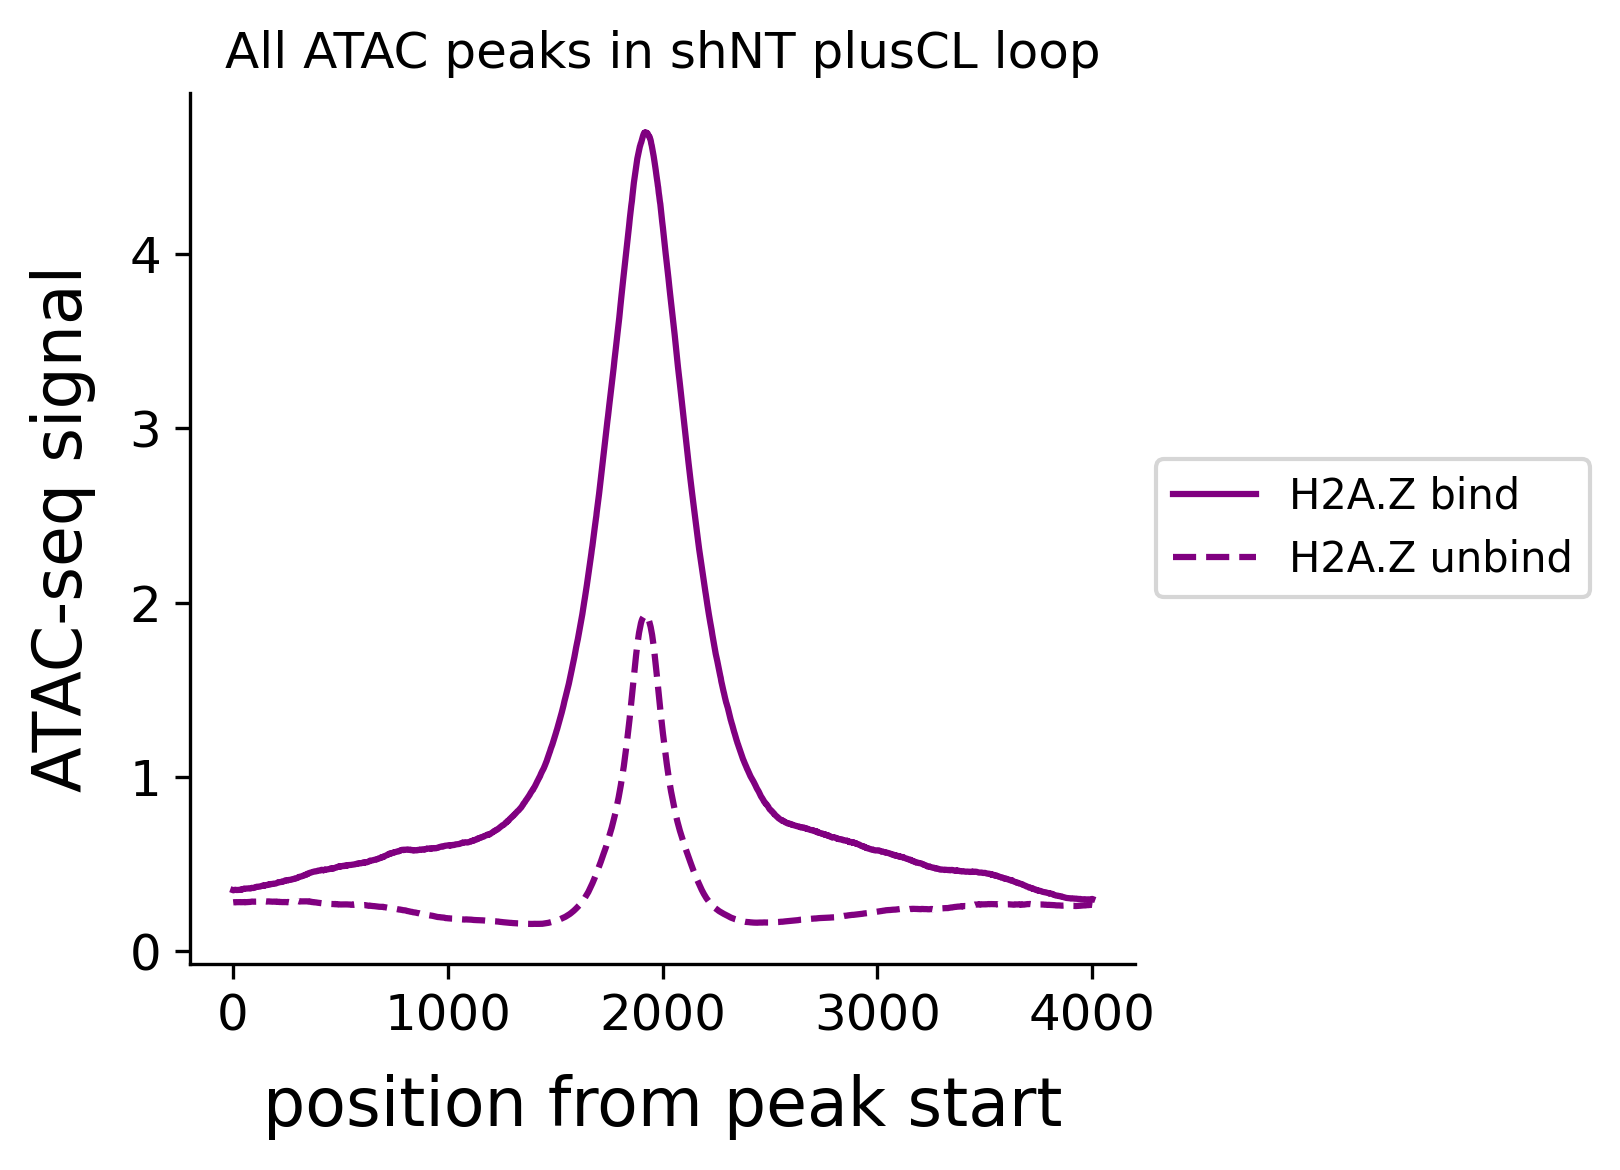

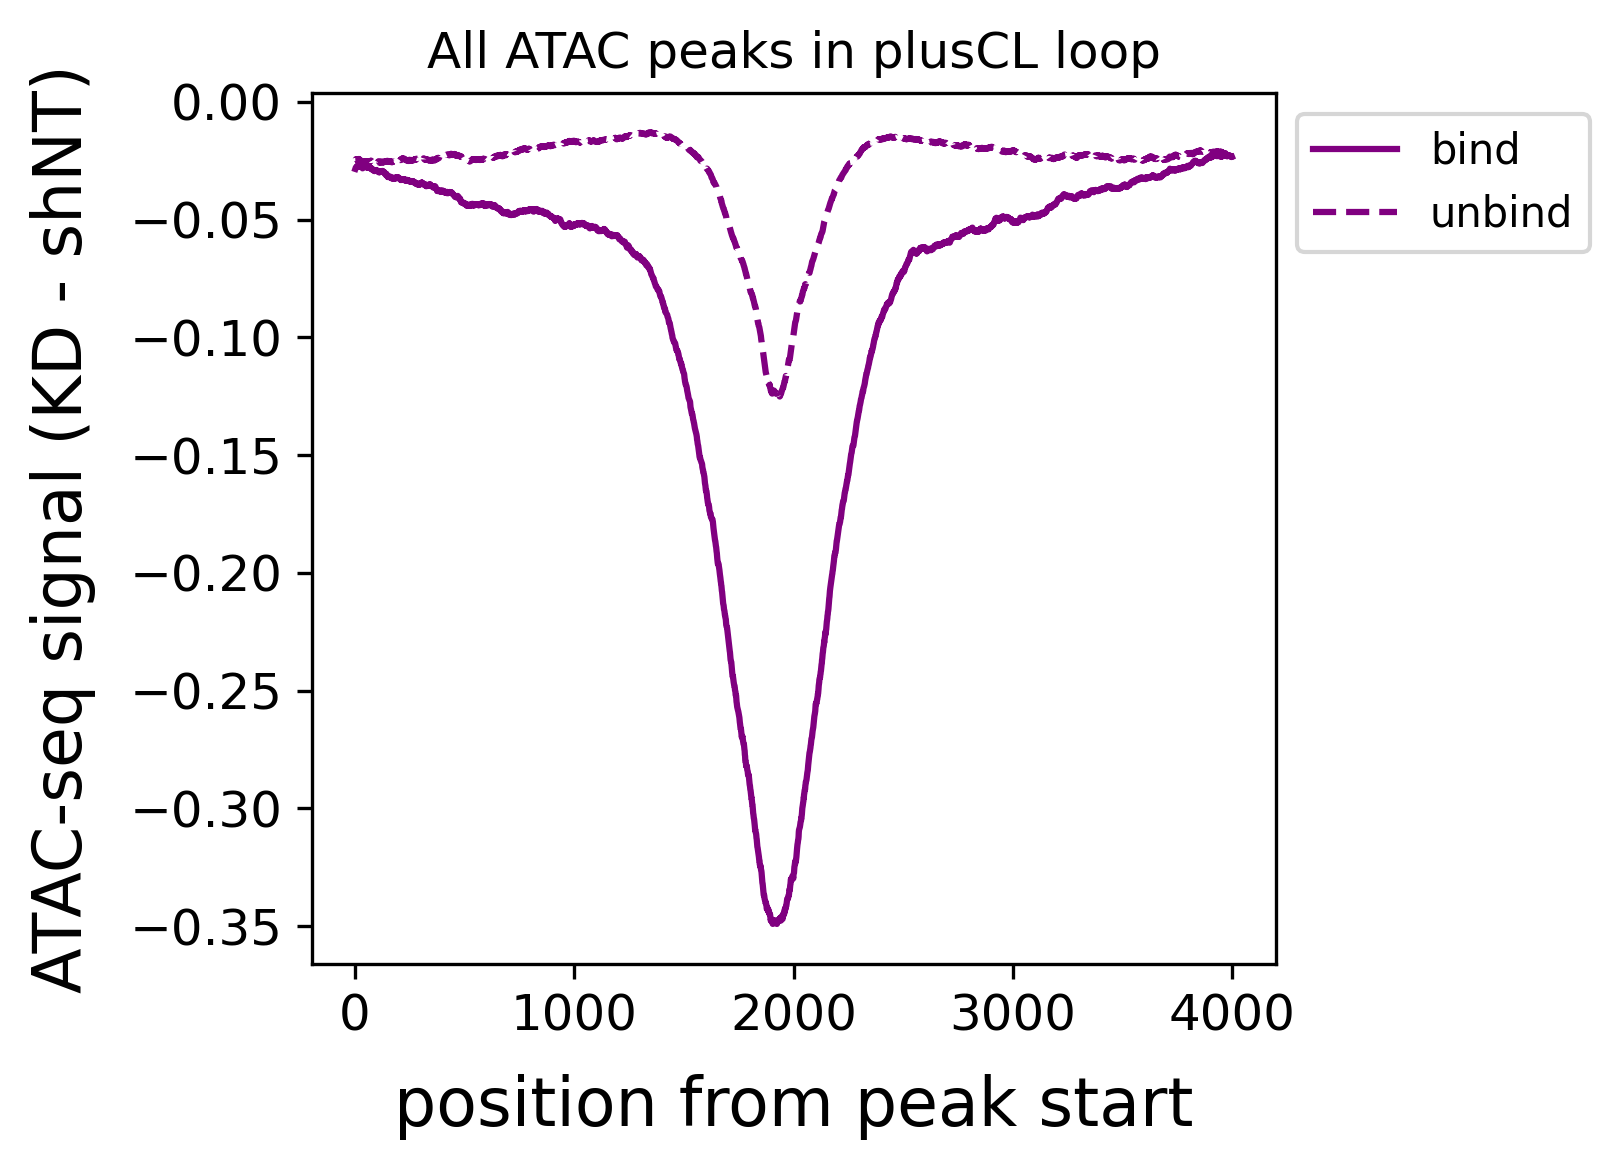

In [10]:
### signal of ATAC-seq in H2AZ peak overlapped peaks and non-overlapped peaks -- within plusCL loop anchors

anchors = shNT_plusCL_allLoop[['chrom1', 'start1', 'end1']].values.tolist()+shNT_plusCL_allLoop[['chrom2', 'start2', 'end2']].values.tolist()
anchors = pd.DataFrame(anchors, columns = ['chrom', 'start', 'end']).drop_duplicates()
anchor_bed = pybedtools.BedTool.from_dataframe(anchors)

H2AZ_plusCL_in_loop = H2AZ_plusCL_reprod_peaks_bed.intersect(anchor_bed, wa = True)
ATAC_plusCL_in_loop = ATAC_peaks_reprod_bed['shNT_plusCL'].intersect(anchor_bed, wa = True)

ATAC_withH2AZ_inloop = ATAC_plusCL_in_loop.intersect(H2AZ_plusCL_reprod_peaks_bed, wa = True).to_dataframe().drop_duplicates()
ATAC_noH2AZ_inloop = ATAC_plusCL_in_loop.intersect(H2AZ_plusCL_reprod_peaks_bed, v=True, wa = True).to_dataframe().drop_duplicates()

bw_value2 = {'bind':[],'unbind':[]}
d = 2000
bw = pyBigWig.open(bw_path_list['shNT_plusCL_rep2'])
for i, line in ATAC_withH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['unbind'].append(bw.values(c, center-d, center+d))

bw_value3 = {'bind':[],'unbind':[]}
bw = pyBigWig.open(bw_path_list['shNT_plusCL_rep3'])
for i, line in ATAC_withH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['unbind'].append(bw.values(c, center-d, center+d))
shNT_bind_inloop = np.array(bw_value2['bind']+bw_value3['bind']).mean(axis = 0)
shNT_unbind_inloop = np.array(bw_value2['unbind']+bw_value3['unbind']).mean(axis = 0)

    
bw_value2 = {'bind':[],'unbind':[]}
d = 2000
bw = pyBigWig.open(bw_path_list['KD_plusCL_rep2'])
for i, line in ATAC_withH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value2['unbind'].append(bw.values(c, center-d, center+d))

bw_value3 = {'bind':[],'unbind':[]}
bw = pyBigWig.open(bw_path_list['KD_plusCL_rep3'])
for i, line in ATAC_withH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['bind'].append(bw.values(c, center-d, center+d))

for i, line in ATAC_noH2AZ_inloop.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    bw_value3['unbind'].append(bw.values(c, center-d, center+d))
KD_bind_inloop = np.array(bw_value2['bind']+bw_value3['bind']).mean(axis = 0)
KD_unbind_inloop = np.array(bw_value2['unbind']+bw_value3['unbind']).mean(axis = 0)

fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), shNT_bind_inloop, label = 'H2A.Z bind', color = 'purple')
ax.plot(range(1,4001), shNT_unbind_inloop, label = 'H2A.Z unbind', color = 'purple', linestyle = 'dashed')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'position from peak start', ylabel = 'ATAC-seq signal',
      title = 'All ATAC peaks in shNT plusCL loop')
plt.tight_layout()
sns.despine()
fig.savefig('Figures/ATAC_signal_H2AZ_bind_vs_unbind_plusCL_in_shNT_plusCL_loops.v2.pdf')
plt.show()
plt.close()


### delta ATAC-seq signal
df_KD_shNT_bind_inloop = KD_bind_inloop - shNT_bind_inloop
df_KD_shNT_unbind_inloop = KD_unbind_inloop - shNT_unbind_inloop

fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), df_KD_shNT_bind_inloop, label = 'bind', color = 'purple')
ax.plot(range(1,4001), df_KD_shNT_unbind_inloop, label = 'unbind', color = 'purple', linestyle = 'dashed')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.set_ylim(0, 5.5)
ax.set(xlabel = 'position from peak start', ylabel = 'ATAC-seq signal (KD - shNT)',
      title = 'All ATAC peaks in plusCL loop')
plt.tight_layout()
fig.savefig('Figures/ATAC_in_plusCL_loop_KD_delta_signal_curve_H2AZ_bind_vs_unbind.pdf')
plt.show()
plt.close()


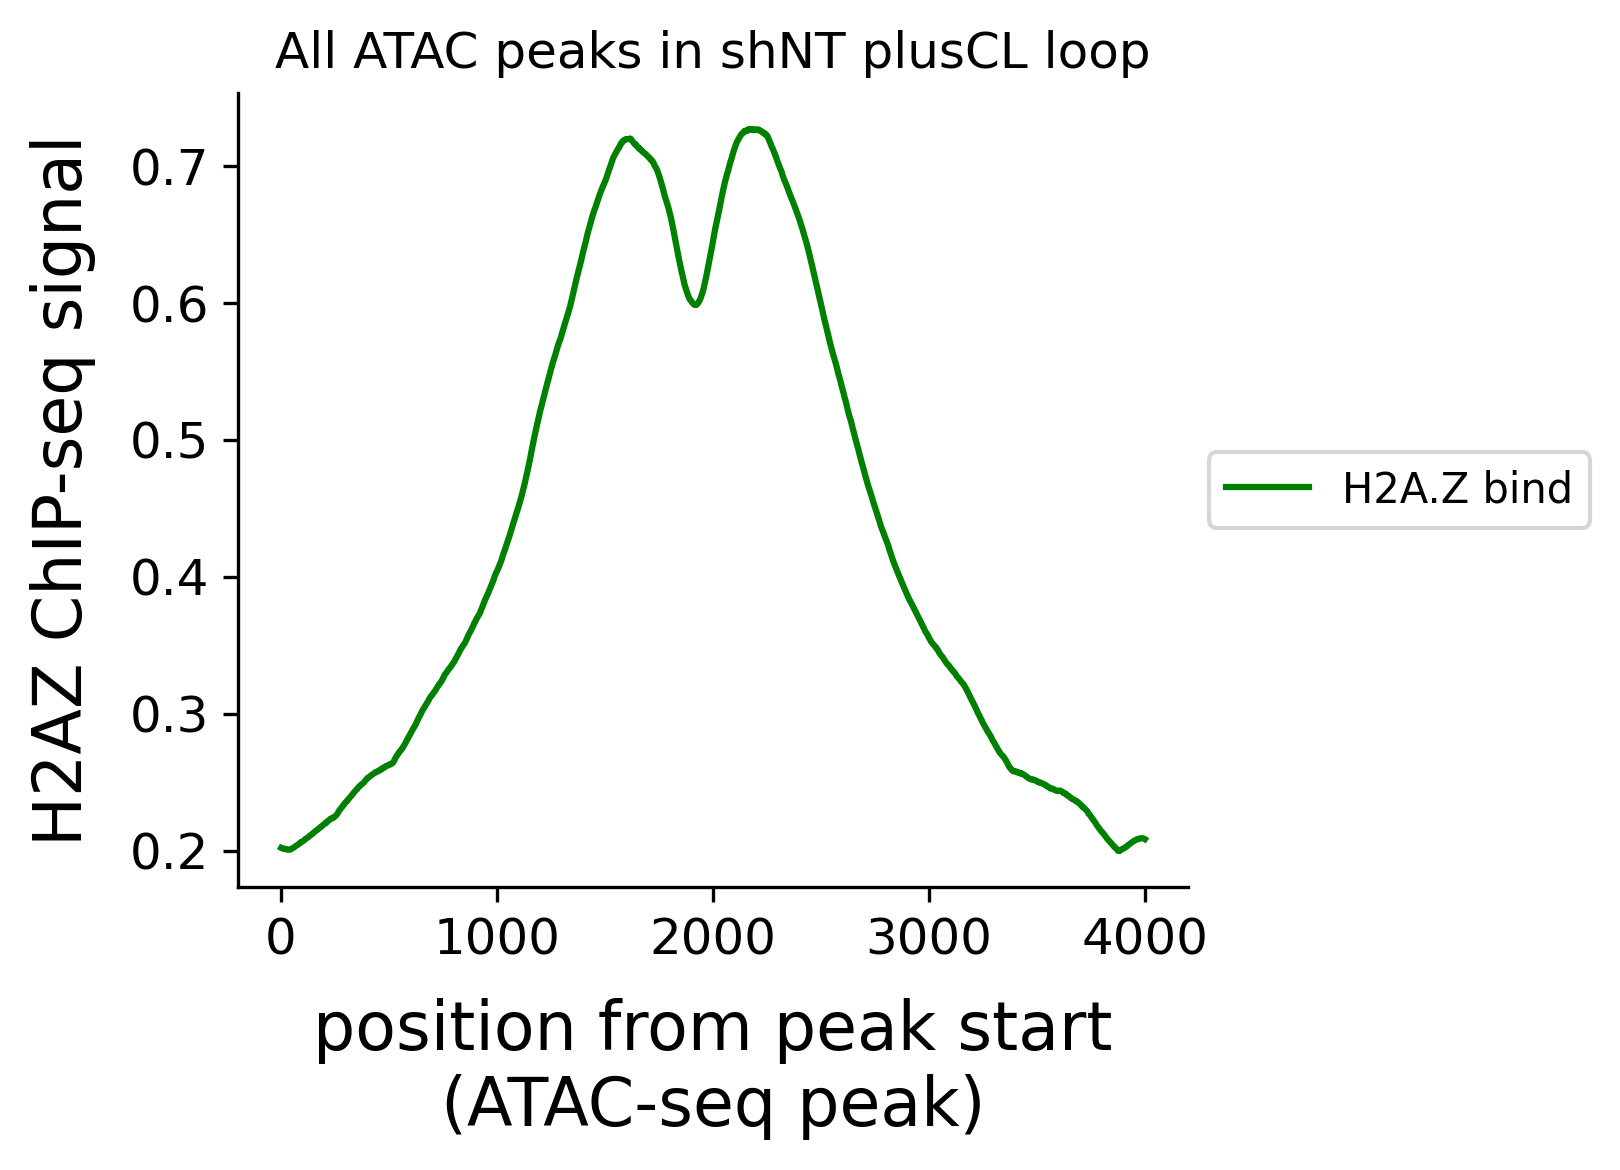

In [18]:
## H2AZ signal of ATAC-seq peak aligned -- within plusCL loop anchors

H2AZ_bw_value1 = {'bind':[]}
d = 2000
bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep1'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    H2AZ_bw_value1['bind'].append(bw.values(c, center-d, center+d))

H2AZ_bw_value2 = {'bind':[]}
bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep2'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    H2AZ_bw_value2['bind'].append(bw.values(c, center-d, center+d))

H2AZ_bw_value3 = {'bind':[]}
bw = pyBigWig.open(H2AZ_bw['ChIP_04082022_H2AZ_plusCL_rep3'])
for i, line in ATAC_withH2AZ.iterrows():
    c, s, e = line['chrom'], line['start'], line['end']
    center = s+int((np.abs(s-e)/2))
    H2AZ_bw_value3['bind'].append(bw.values(c, center-d, center+d))

hbv = np.array(H2AZ_bw_value1['bind']+H2AZ_bw_value2['bind']+H2AZ_bw_value3['bind']).mean(axis = 0)


fig,ax = plt.subplots(figsize = (5.5, 4))
ax.plot(range(1,4001), hbv, label = 'H2A.Z bind', color = 'green')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(xlabel = 'position from peak start\n(ATAC-seq peak)', ylabel = 'H2AZ ChIP-seq signal',
      title = 'All ATAC peaks in shNT plusCL loop')
plt.tight_layout()
sns.despine()
fig.savefig('Figures/H2AZ_signal_H2AZ_bind_ATAC_peaks_plusCL_in_shNT_plusCL_loops.pdf')
plt.show()
plt.close()


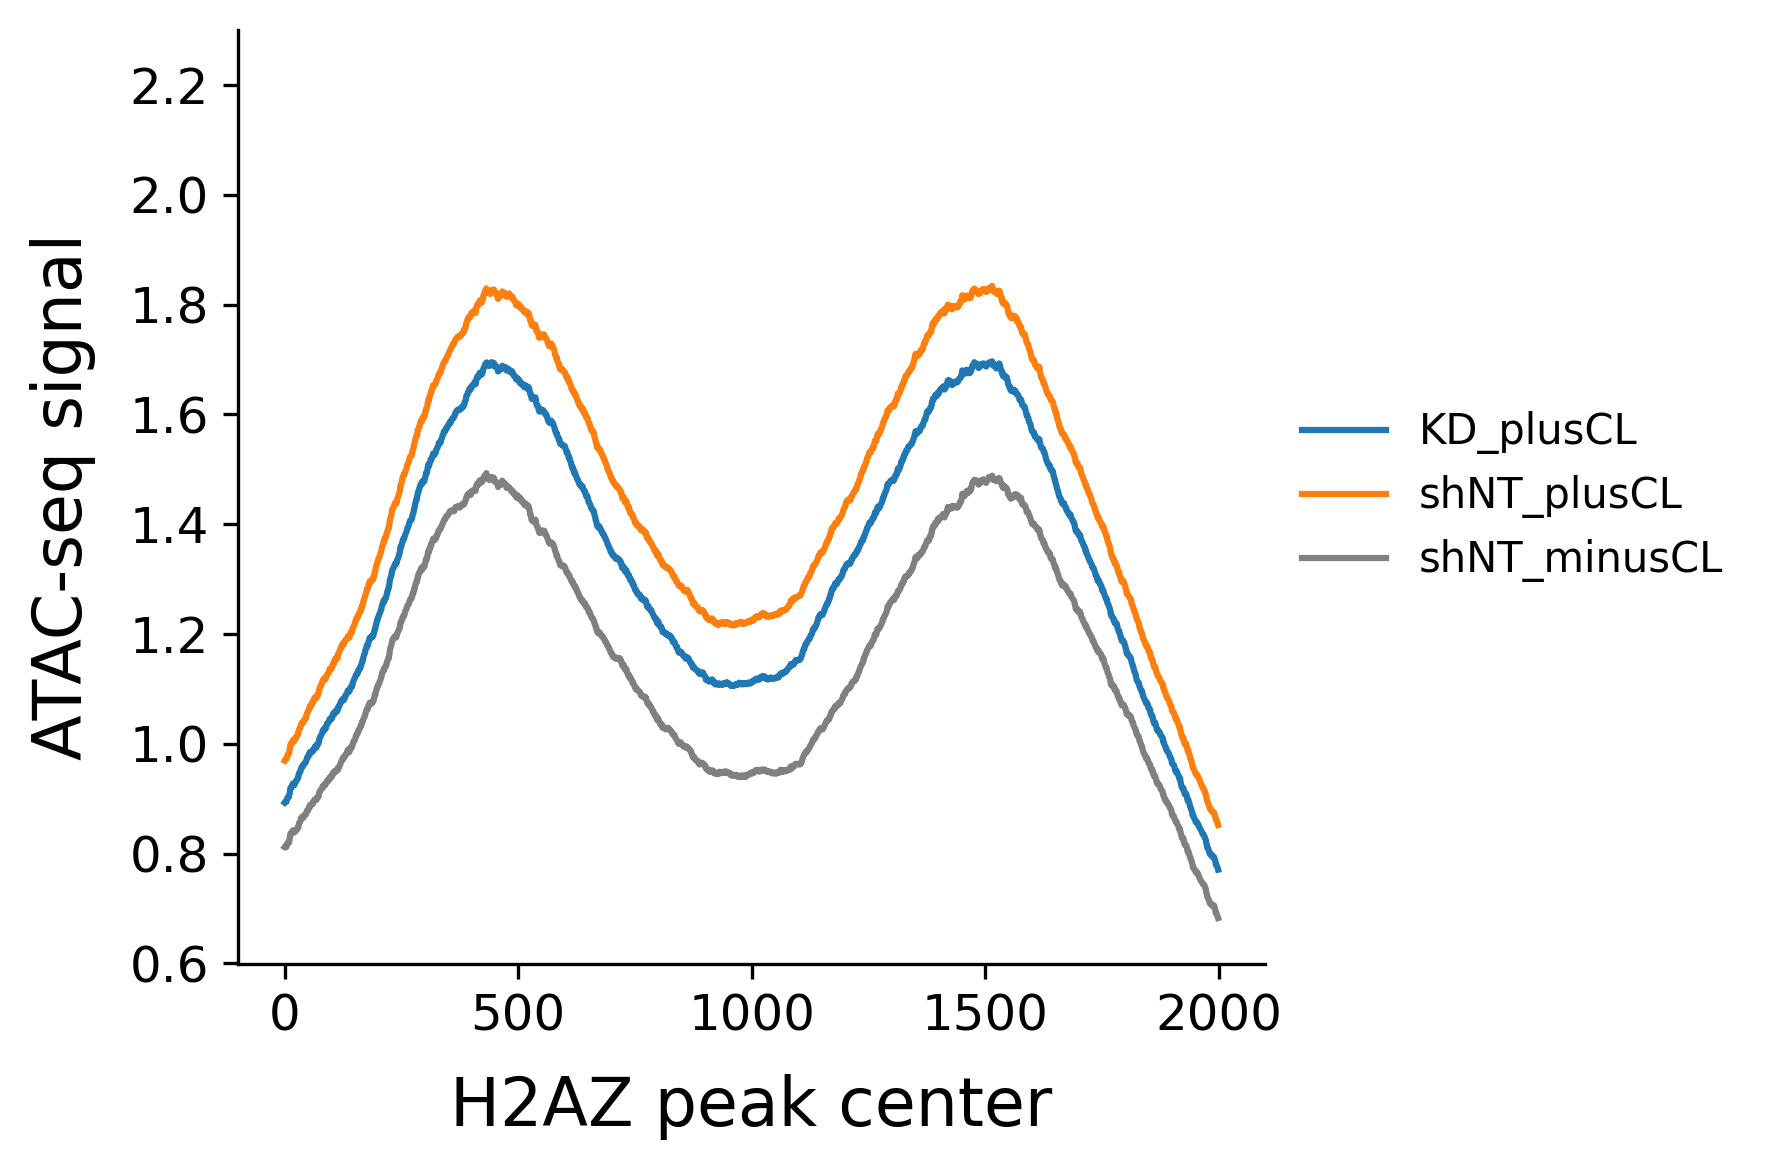

In [13]:
### ATAC-seq signal at H2AZ site in H2AZ occupied loops in three conditions
bw_H2AZ_site_values={}
for t, r, l in [['EP', EP_res, CL_induce_KD_down_EP],
         ['PP', PP_res, CL_induce_KD_down_PP],
         ['PO', PO_res, CL_induce_KD_down_PO],
         ['OO', OO_res, CL_induce_KD_down_OO]]:
    H2AZ_bind_loops = pd.concat([r['H2AZ_peak']['loops']['either'], r['H2AZ_peak']['loops']['both']])
    H2AZ_bind_loops['anchor1'] = H2AZ_bind_loops['chrom1']+':'+H2AZ_bind_loops['start1'].astype('str')+'-'+H2AZ_bind_loops['end1'].astype('str')
    H2AZ_bind_loops['anchor2'] = H2AZ_bind_loops['chrom2']+':'+H2AZ_bind_loops['start2'].astype('str')+'-'+H2AZ_bind_loops['end2'].astype('str')
   
    bind_anchors = pd.DataFrame(H2AZ_bind_loops[['chrom1', 'start1', 'end1']].values.tolist()+H2AZ_bind_loops[['chrom2', 'start2', 'end2']].values.tolist())
    bind_anchors_bed = pybedtools.BedTool.from_dataframe(bind_anchors)
    H2AZ_site = H2AZ_plusCL_reprod_peaks_bed.intersect(bind_anchors_bed, wa = True).to_dataframe().drop_duplicates()
    H2AZ_site['start'] = H2AZ_site['start'] + ((H2AZ_site['start']-H2AZ_site['end'])/2).abs().astype('int')
    
    d = 2000
    bw_H2AZ_site_values[t] = []
    for path in bw_path_list:
        bw = pyBigWig.open(bw_path_list[path])
        for i, line in H2AZ_site.iterrows():
            line['bw'] = bw.values(line['chrom'], line['start']-d, line['start']+d)
            bw_H2AZ_site_values[t].append(line.values.tolist()+[path])


df = pd.concat([pd.DataFrame(bw_H2AZ_site_values['EP']),
               pd.DataFrame(bw_H2AZ_site_values['PP']),
               pd.DataFrame(bw_H2AZ_site_values['PO']),
               pd.DataFrame(bw_H2AZ_site_values['OO'])]).groupby(9).apply(lambda d: pd.DataFrame(d[8].tolist()).mean())

df['cond'] = [x.replace('_rep2', '').replace('_rep3', '') for x in df.index.tolist()]
df = df.groupby('cond').mean()

df22 = df.loc[:,range(1000, 3000)]
fig,ax = plt.subplots(figsize = (6, 4))
ax.plot(range(0, df22.shape[1]), df22.loc['KD_plusCL',:], label = 'KD_plusCL', linewidth = 1.5)
ax.plot(range(0, df22.shape[1]), df22.loc['shNT_plusCL',:], label = 'shNT_plusCL', linewidth = 1.5)
ax.plot(range(0, df22.shape[1]), df22.loc['shNT_minusCL',:], label = 'shNT_minusCL', linewidth = 1.5, color = 'grey')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon = False)
ax.set(xlabel = 'H2AZ peak center', ylabel = 'ATAC-seq signal')
sns.despine()
ax.set_ylim(0.6, 2.3)
plt.tight_layout()
fig.savefig('Figures/ATAC_signal_at_H2AZ_site_in_H2AZ_dependant_loops_three_condition.pdf')
plt.show()


### Integrate GWAS with loops and H2AZ peaks


In [17]:
### read GWAS data - downloaded from UCSC table browser
hg38_gwas = pd.read_csv('./hg38_GWAScatelog_UCSC.tsv', sep = '\t')
hg38_gwas = hg38_gwas.query('pValue < 1e-8')## select significant associations
hg38_gwas = hg38_gwas.drop_duplicates(['chrom', 'chromStart','chromEnd', 'name', 'trait'])
hg38_gwas['label'] = hg38_gwas['chrom']+':'+hg38_gwas['chromStart'].astype('str')+'-'+hg38_gwas['chromEnd'].astype('str')+'_'+hg38_gwas['name']+'_'+hg38_gwas['trait']

hg38_gwas_bed = pybedtools.BedTool.from_dataframe(hg38_gwas[['chrom','chromStart','chromEnd','label']])

### load genomic locations that liftover from mouse to human genome
hg38_liftover_cl_stable_loop = pd.read_csv('./CL_stable_loop_anchors_hg38_liftover.bed', sep = '\t', header = None).drop_duplicates()
hg38_liftover_cl_stable_loop.columns = ['chrom', 'start', 'end', 'mm10_site', 'value']
hg38_liftover_cl_stable_loop_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_cl_stable_loop)

hg38_liftover_cl_up_loop = pd.read_csv('./CL_up_loop_anchors_hg38_liftover.bed', sep = '\t', header = None).drop_duplicates()
hg38_liftover_cl_up_loop.columns = ['chrom', 'start', 'end', 'mm10_site', 'value']
hg38_liftover_cl_up_loop_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_cl_up_loop)

hg38_liftover_H2AZ = pd.read_csv('./H2AZ_plusCL_reprod_peaks_liftover_hg38.bed', sep = '\t', header = None).drop_duplicates()
hg38_liftover_H2AZ.columns = ['chrom', 'start', 'end', 'mm10_site', 'value']
## set a 5kb window, so will be the same size with a loop size
hg38_liftover_H2AZ['start'] = hg38_liftover_H2AZ['start'] + ((hg38_liftover_H2AZ['start'] - hg38_liftover_H2AZ['end']).abs()/2).astype('int') - 2500
hg38_liftover_H2AZ['end'] = hg38_liftover_H2AZ['end'] + 2500
hg38_liftover_H2AZ_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_H2AZ)


In [20]:
## convert loop sets to be bed format by focusing on anchors 
KD_down_loop_anchor1 = KD_down_loop['chrom1']+':'+(KD_down_loop['start1']+1).astype('str')+'-'+KD_down_loop['end1'].astype('str')
KD_down_loop_anchor2 = KD_down_loop['chrom2']+':'+(KD_down_loop['start2']+1).astype('str')+'-'+KD_down_loop['end2'].astype('str')

H2AZ_bind_loops = pd.DataFrame()
for t, r, l in [['EP', EP_res, CL_induce_KD_down_EP],
         ['PP', PP_res, CL_induce_KD_down_PP],
         ['PO', PO_res, CL_induce_KD_down_PO],
         ['OO', OO_res, CL_induce_KD_down_OO]]:
    tmp = pd.concat([r['H2AZ_peak']['loops']['either'], r['H2AZ_peak']['loops']['both']])
    tmp['anchor1'] = tmp['chrom1']+':'+tmp['start1'].astype('str')+'-'+tmp['end1'].astype('str')
    tmp['anchor2'] = tmp['chrom2']+':'+tmp['start2'].astype('str')+'-'+tmp['end2'].astype('str')
    H2AZ_bind_loops = pd.concat([H2AZ_bind_loops, tmp])
    
CL_induce_KD_down_withH2AZbind_anchor1 = H2AZ_bind_loops['chrom1']+':'+(H2AZ_bind_loops['start1']+1).astype('str')+'-'+H2AZ_bind_loops['end1'].astype('str')
CL_induce_KD_down_withH2AZbind_anchor2 = H2AZ_bind_loops['chrom2']+':'+(H2AZ_bind_loops['start2']+1).astype('str')+'-'+H2AZ_bind_loops['end2'].astype('str')

## extract liftover regions for the focused anchors
hg38_liftover_cl_up_KD_down_loop = hg38_liftover_cl_up_loop[hg38_liftover_cl_up_loop['mm10_site'].isin(KD_down_loop_anchor1)|
                                                           hg38_liftover_cl_up_loop['mm10_site'].isin(KD_down_loop_anchor2)]
hg38_liftover_cl_up_KD_down_loop_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_cl_up_KD_down_loop)

hg38_liftover_cl_up_KD_down_H2AZ_bind_loop = hg38_liftover_cl_up_KD_down_loop[hg38_liftover_cl_up_KD_down_loop['mm10_site'].isin(CL_induce_KD_down_withH2AZbind_anchor1)|
                                                           hg38_liftover_cl_up_KD_down_loop['mm10_site'].isin(CL_induce_KD_down_withH2AZbind_anchor2)]
hg38_liftover_cl_up_KD_down_H2AZ_bind_loop_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_cl_up_KD_down_H2AZ_bind_loop)

hg38_liftover_cl_up_KD_down_H2AZ_unbind_loop = hg38_liftover_cl_up_KD_down_loop[~hg38_liftover_cl_up_KD_down_loop['mm10_site'].isin(CL_induce_KD_down_withH2AZbind_anchor1) &
                                                           ~hg38_liftover_cl_up_KD_down_loop['mm10_site'].isin(CL_induce_KD_down_withH2AZbind_anchor2)]
hg38_liftover_cl_up_KD_down_H2AZ_unbind_loop_bed = pybedtools.BedTool.from_dataframe(hg38_liftover_cl_up_KD_down_H2AZ_unbind_loop)

## compute number of overlapped SNPs in GWAS
cl_up_loop_snp = hg38_liftover_cl_up_loop_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
cl_up_loop_snp = cl_up_loop_snp[cl_up_loop_snp['strand'] != '.']
cl_up_loop_snp = pd.merge(cl_up_loop_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

cl_up_KD_down_loop_snp = hg38_liftover_cl_up_KD_down_loop_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
cl_up_KD_down_loop_snp = cl_up_KD_down_loop_snp[cl_up_KD_down_loop_snp['strand'] != '.']
cl_up_KD_down_loop_snp = pd.merge(cl_up_KD_down_loop_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

cl_up_KD_down_H2AZ_bind_loop_snp = hg38_liftover_cl_up_KD_down_H2AZ_bind_loop_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
cl_up_KD_down_H2AZ_bind_loop_snp = cl_up_KD_down_H2AZ_bind_loop_snp[cl_up_KD_down_H2AZ_bind_loop_snp['strand'] != '.']
cl_up_KD_down_H2AZ_bind_loop_snp = pd.merge(cl_up_KD_down_H2AZ_bind_loop_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

cl_up_KD_down_H2AZ_unbind_loop_snp = hg38_liftover_cl_up_KD_down_H2AZ_unbind_loop_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
cl_up_KD_down_H2AZ_unbind_loop_snp = cl_up_KD_down_H2AZ_unbind_loop_snp[cl_up_KD_down_H2AZ_unbind_loop_snp['strand'] != '.']
cl_up_KD_down_H2AZ_unbind_loop_snp = pd.merge(cl_up_KD_down_H2AZ_unbind_loop_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

cl_stable_loop_snp = hg38_liftover_cl_stable_loop_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
cl_stable_loop_snp = cl_stable_loop_snp[cl_stable_loop_snp['strand'] != '.']
cl_stable_loop_snp = pd.merge(cl_stable_loop_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

H2AZ_site_snp = hg38_liftover_H2AZ_bed.intersect(hg38_gwas_bed, wao=True).to_dataframe().drop_duplicates()
H2AZ_site_snp = H2AZ_site_snp[H2AZ_site_snp['strand'] != '.']
H2AZ_site_snp = pd.merge(H2AZ_site_snp, hg38_gwas[['label', 'trait']], left_on = 'itemRgb', right_on = 'label')

## summary of the overlapped SNP numbers per trait
res = pd.concat([cl_up_loop_snp.groupby('trait')['trait'].count(),
                 cl_up_KD_down_loop_snp.groupby('trait')['trait'].count(),
                 cl_up_KD_down_H2AZ_bind_loop_snp.groupby('trait')['trait'].count(),
                 cl_up_KD_down_H2AZ_unbind_loop_snp.groupby('trait')['trait'].count(),
           cl_stable_loop_snp.groupby('trait')['trait'].count(),
                H2AZ_site_snp.groupby('trait')['trait'].count(),], axis = 1).fillna(0)
res.columns = ['CL_up_loop', 'CL_up_KD_down_loop','CL_up_KD_down_bind_loop', 'CL_up_KD_down_unbind_loop', 'CL_stable_loop', 'H2AZ_site']

total_loops_num = pd.Series([hg38_liftover_cl_up_loop.shape[0], hg38_liftover_cl_up_KD_down_loop.shape[0],
                            hg38_liftover_cl_up_KD_down_H2AZ_bind_loop.shape[0], 
                             hg38_liftover_cl_up_KD_down_H2AZ_unbind_loop.shape[0],
                            hg38_liftover_cl_stable_loop.shape[0],
                            hg38_liftover_H2AZ.shape[0]],
                           index= res.columns)

## compute the enrichment score - # of SNP per a thousand loop anchors
res_norm = res.apply(lambda row: row*1000/total_loops_num, axis = 1)

for x in ['CL_up_loop', 'CL_up_KD_down_loop','CL_up_KD_down_bind_loop', 'CL_up_KD_down_unbind_loop', 'CL_stable_loop', 'H2AZ_site']:
    res_norm[x+' - stable'] = res_norm[x] - res_norm['CL_stable_loop']
    res_norm[x+'_vs_stable_lfc'] = np.log2(res_norm[x]+1) - np.log2(res_norm['CL_stable_loop']+1)

res_norm = res_norm.sort_values(['CL_up_KD_down_bind_loop - stable', 'CL_up_KD_down_bind_loop'], ascending = False)


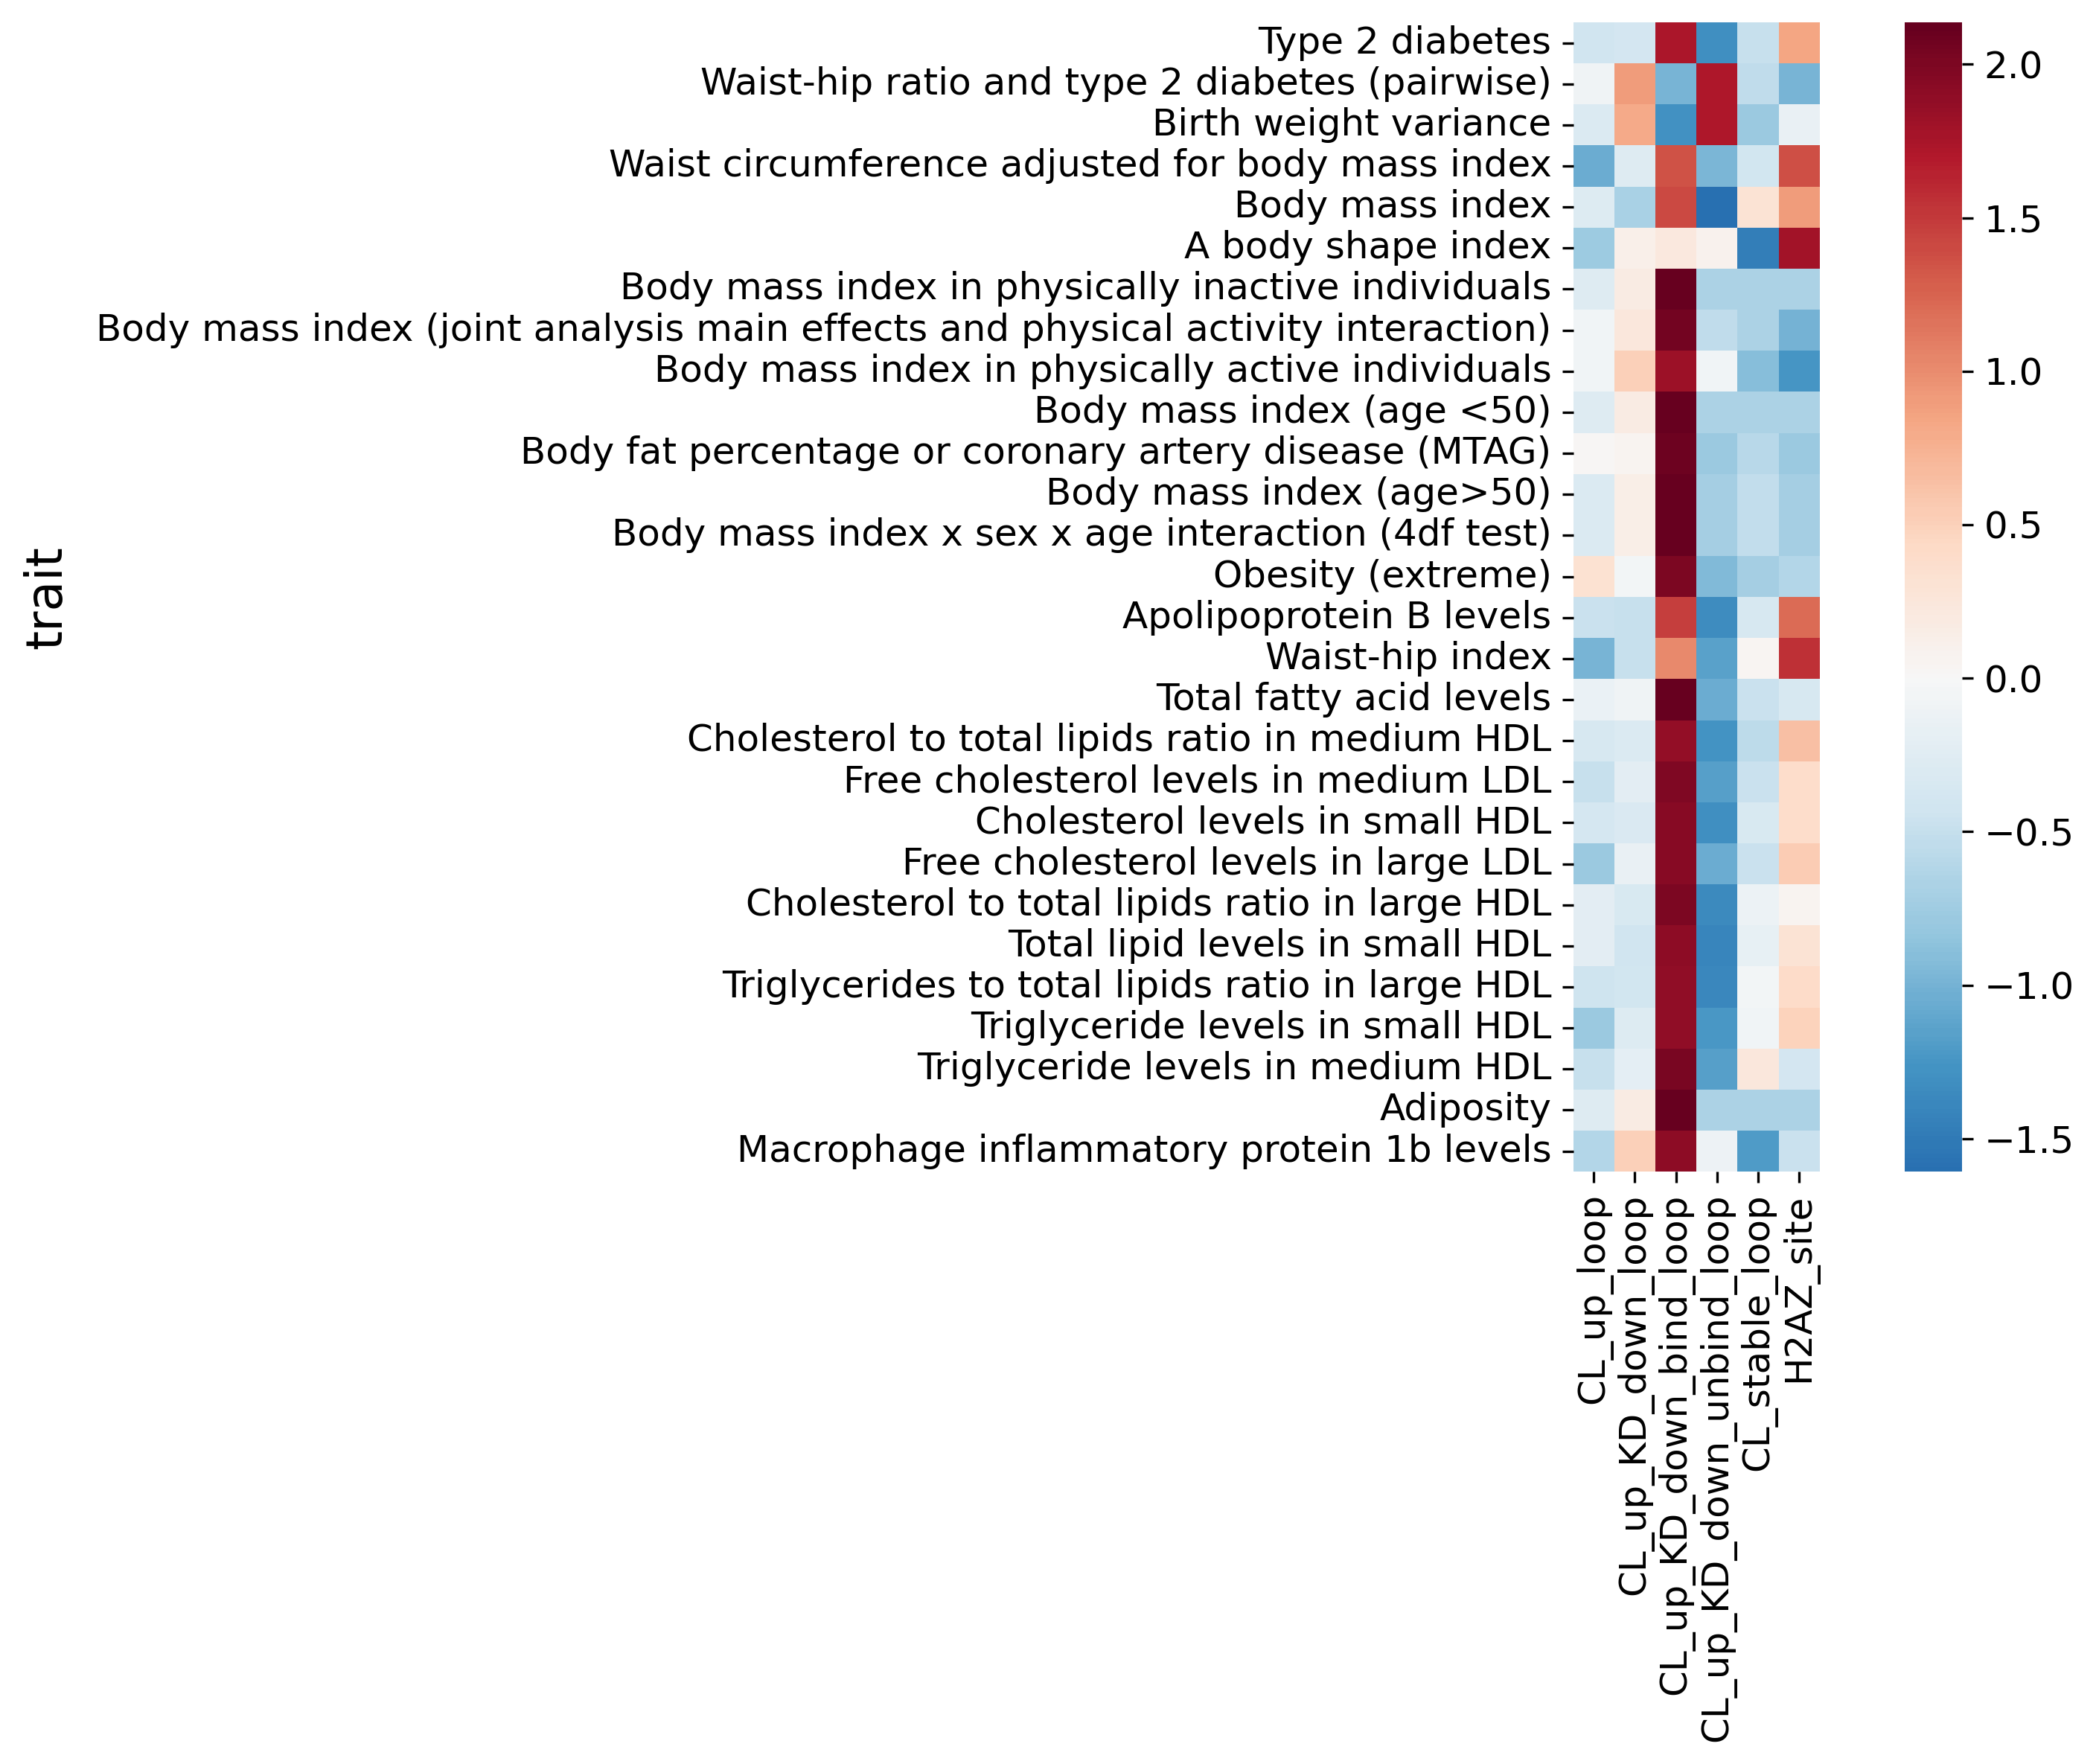

In [22]:
## plot heatmap to show the SNP enrichment 
focus_traits = ["Type 2 diabetes",
"Waist-hip ratio and type 2 diabetes (pairwise)",
"Birth weight variance",
"Waist circumference adjusted for body mass index",
"Body mass index",
"A body shape index",
"Body mass index in physically inactive individuals",
"Body mass index (joint analysis main effects and physical activity interaction)",
"Body mass index in physically active individuals",
"Body mass index (age <50)",
"Body fat percentage or coronary artery disease (MTAG)",
"Body mass index (age>50)",
"Body mass index x sex x age interaction (4df test)",
"Obesity (extreme)",
"Apolipoprotein B levels",
"Waist-hip index",
"Total fatty acid levels",
"Cholesterol to total lipids ratio in medium HDL",
"Free cholesterol levels in medium LDL",
"Cholesterol levels in small HDL",
"Free cholesterol levels in large LDL",
"Cholesterol to total lipids ratio in large HDL",
"Total lipid levels in small HDL",
"Triglycerides to total lipids ratio in large HDL",
"Triglyceride levels in small HDL",
"Triglyceride levels in medium HDL",
"Adiposity",
"Macrophage inflammatory protein 1b levels"]

columns = ['CL_up_loop','CL_up_KD_down_loop','CL_up_KD_down_bind_loop','CL_up_KD_down_unbind_loop','CL_stable_loop','H2AZ_site']

df = res_norm.loc[focus_traits,columns]
df = df.apply(lambda row: (row - np.mean(row))/np.std(row), axis = 1)
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(data = df, cmap = 'RdBu_r', center = 0, square = True)
plt.tight_layout()
fig.savefig('Figures/GWAS_SNP_enrichment.pdf')
plt.show()


## output supplementary tables


In [ ]:
# Supplementary Table 1. Chromatin loops in vehicle-treated and b3-AR stimulated brown adipocytes
with pd.ExcelWriter('SuppTable/SuppTable1.xlsx') as writer:
    shNT_minusCL_allLoop.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='vehicle-treated', index = None)
    shNT_plusCL_allLoop.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='b3-AR stimulated', index = None)

# Supplementary Table 2. Differential loops between vehicle-treated and b3-AR stimulated brown adipocytes
with pd.ExcelWriter('SuppTable/SuppTable2.xlsx') as writer:
    up_loop_union.loc[up_loop['label'],:].iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='UP', index = None)
    down_loop_union.loc[down_loop['label'],:].iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='DOWN', index = None)

# Supplementary Table 3. E-P, P-P, and P-other loops in vehicle-treated and b3-AR stimulated brown adipocytes
with pd.ExcelWriter('SuppTable/SuppTable3.xlsx') as writer:
    shNT_minusCL_EP.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='vehicle-treated_EP', index = None)
    shNT_minusCL_PP.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='vehicle-treated_PP', index = None)
    shNT_minusCL_PO.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='vehicle-treated_PO', index = None)
    shNT_plusCL_EP.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='b3-AR stimulated_EP', index = None)
    shNT_plusCL_PP.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='b3-AR stimulated_PP', index = None)
    shNT_plusCL_PO.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='b3-AR stimulated_PO', index = None)

# Supplementary Table 4. Differential E-P, P-P, and P-other loops between vehicle-treated and b3-AR stimulated brown adipocytes
with pd.ExcelWriter('SuppTable/SuppTable4.xlsx') as writer:
    up_loop_union.query('group == "E-P"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='UP_EP', index = None)
    up_loop_union.query('group == "P-P"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='UP_PP', index = None)
    up_loop_union.query('group == "P-O"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='UP_PO', index = None)
    down_loop_union.query('group == "E-P"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='DOWN_EP', index = None)
    down_loop_union.query('group == "P-P"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='DOWN_PP', index = None)
    down_loop_union.query('group == "P-O"').iloc[:,:10].drop_duplicates().to_excel(writer, sheet_name='DOWN_PO', index = None)

# Supplementary Table 5. Chromatin loops in b3-AR stimulated H2A.Z KD brown adipocytes
with pd.ExcelWriter('SuppTable/SuppTable5.xlsx') as writer:
    KD_plusCL_allLoop.iloc[:,0:8].drop_duplicates().to_excel(writer, sheet_name='b3-AR stimulated H2A.Z KD', index = None)

# Supplementary Table 6. Differential loops by H2A.Z KD
with pd.ExcelWriter('SuppTable/SuppTable6.xlsx') as writer:
    tmp = loop_dots.loc[KD_down_loop['label'],:].iloc[:,0:12].drop(['prob_shNT_minusCL','score_shNT_minusCL'], axis = 1)
    tmp.drop_duplicates().to_excel(writer, sheet_name='DOWN', index = None)
    tmp = loop_dots.loc[KD_up_loop['label'],:].iloc[:,0:12].drop(['prob_shNT_minusCL','score_shNT_minusCL'], axis = 1)
    tmp.drop_duplicates().to_excel(writer, sheet_name='UP', index = None)

# Supplementary Table 7. Dynamic loops affected by H2A.Z KD
with pd.ExcelWriter('SuppTable/SuppTable7.xlsx') as writer:
    CL_induce_KD_down.iloc[:,0:12].drop_duplicates().to_excel(writer, sheet_name='b3-AR_UP_H2AZ_KD_DOWN', index = None)

